#  Base de Datos Olist - Estimación de días de entrega

**Grupo 8 - Integrantes:**
 - Ignacio Cordoba
 - Sebastin Ignacio Lezama
 - Alejandro Mezio
 - Diego Nicolás Zallio

**Datasets tomado de Kaggle:** [link](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)


---
---

## 1.&nbsp;Contexto para la lectura del Notebook y definición de la propuesta de trabajo

Para una correcta interpretación de la secuencia de pasos indicamos la oportunidad de mejora que encontramos:

Al analizar el modelo de negocio de **Olist**, el cual se centra en conectar a pequeñas y medianas empresas con los principales marketplaces (asumiendo un rol de plataforma de gestión y facilitando la venta online), y teniendo en consideración las variables temporales de fecha de entrega y de recepción **observamos que los días estimados por la plataforma eran en su mayoria sobredimensionados en relación a la fecha efectiva de entrega.**

**Es por esto que toda la limpieza y visualización de datos esta orientada a optimizar la estimación de los tiempos de entrega.**

---
---

## 2.&nbsp;Carga de librerías

In [ ]:
# !pip -q install unidecode
# !pip -q install -U ydata-profiling[notebook]
# !pip install kagglehub
# !pip install folium

In [ ]:
import ydata_profiling as pp
from ydata_profiling import ProfileReport

In [ ]:
import os
import json
from pathlib import Path
import kagglehub
from unidecode import unidecode

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = 'raise'

In [2]:
# Función para cargar los dataframes junto con sus diccionarios de datatypes
def load_dataframe(base_path, name):
    dtype_path = Path(base_path) / f"{name}_datatypes.txt"
    csv_path = Path(base_path) / f"{name}.csv"
    
    with open(dtype_path, "r") as file:
        datatypes = json.load(file)

    # Extraemos columnas de fechas
    datetime_cols = [col for col, dtype in datatypes.items() if dtype == 'datetime64[ns]']
    for col in datetime_cols:
        del datatypes[col]

    return pd.read_csv(csv_path, dtype=datatypes, parse_dates=datetime_cols)

---
---

## 3.&nbsp;Carga de datos

Luego de conocer las variables con las que trabajamos, hemos vuelto a este punto y cargamos directamente los datos con su correspondientes datatype.

* Los datos que son enteros los cargamos como tipo `Int64`, ya que éste admite valores NaN.
* Las fechas son indicadas en una lista.
* Algunas variables podrían cargarse como tipo "category", pero hemos tenido problemas a la hora de efectuar operaciones. En términos prácticos no afecta que se carguen como "object", que es el datatype por defecto.

In [4]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ale\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


In [5]:
customers_datatypes = {
    'customer_zip_code_prefix': 'Int64',
    # 'customer_state': 'category',
    # 'customer_city': 'category',
}
file = path + f'\olist_customers_dataset.csv'
customers = pd.read_csv(file, dtype=customers_datatypes, index_col=False)

In [6]:
orders_datatypes = {
    # 'order_status': 'category',
}
cols_dates = ['order_purchase_timestamp',
              'order_approved_at',
              'order_delivered_carrier_date',
              'order_delivered_customer_date',
              'order_estimated_delivery_date']
file = path + f'\olist_orders_dataset.csv'
orders = pd.read_csv(file, dtype=orders_datatypes, parse_dates=cols_dates, index_col=False)

In [7]:
orders_items_datatypes = {
    'order_item_id': 'Int64',
    'price': 'float64',
    'freight_value': 'float64',
}
cols_dates = ['shipping_limit_date']
file = path + f'\olist_order_items_dataset.csv'
order_items = pd.read_csv(file,dtype=orders_items_datatypes,parse_dates=cols_dates, index_col=False)

In [8]:
orders_payments_datatypes = {
    'payment_sequential': 'Int64',
    # 'payment_type': 'category',
    'payment_installments': 'Int64',
    'payment_value': 'float64',
}
file = path + f'\olist_order_payments_dataset.csv'
order_payments = pd.read_csv(file, dtype=orders_payments_datatypes, index_col=False)

In [9]:
order_reviews_datatypes = {
    'review_score': 'Int64'}
cols_dates = ['review_creation_date',
              'review_answer_timestamp']
file = path + f'\olist_order_reviews_dataset.csv'
order_reviews = pd.read_csv(file, dtype=order_reviews_datatypes, parse_dates=cols_dates, index_col=False)

In [10]:
sellers_datatypes = {
    'seller_zip_code_prefix': 'Int64',
    # 'seller_city': 'category',
    # 'seller_state': 'category',
}
file = path + f'\olist_sellers_dataset.csv'
sellers = pd.read_csv(file, dtype=sellers_datatypes, index_col=False)

In [11]:
products_datatypes = {
    # 'product_category_name': 'category',
    'product_name_lenght': 'Int64',
    'product_description_lenght': 'Int64',
    'product_photos_qty': 'Int64',
    'product_weight_g': 'Int64',
    'product_length_cm': 'Int64',
    'product_height_cm': 'Int64',
    'product_width_cm': 'Int64',
}
file = path + f'\olist_products_dataset.csv'
products = pd.read_csv(file, dtype=products_datatypes, index_col=False)

In [12]:
product_category_name_datatypes = {
    # 'product_category_name': 'category',
    # 'product_category_name_english': 'category',
}
file = path + f'\product_category_name_translation.csv'
product_category_name = pd.read_csv(file,dtype=product_category_name_datatypes, index_col=False)

In [13]:
geolocation_datatypes = {
    'geolocation_zip_code_prefix': 'Int64',
    'geolocation_lat': 'float64',
    'geolocation_lng': 'float64',
    # 'geolocation_city': 'category',
    # 'geolocation_state': 'category',
}
file = path + f'\olist_geolocation_dataset.csv'
geolocation = pd.read_csv(file, dtype=geolocation_datatypes, index_col=False)

In [14]:
# customers.head()
# orders.head()
# order_items.head()
# order_payments.head()
# order_reviews.head()
# sellers.head()
# products.head()
# product_category_name.head()
# geolocation.head()

---
---

## 4.&nbsp;Profiling (opcional)

Con las siguientes líneas generamos un reporte de profiling para cada dataframe y lo guardamos como html en la carpeta "profiling". Luego podemos explorar cada uno por separado.

Estos reportes permiten un primer acercamiento a los datos.

In [15]:
# profile_customers= ProfileReport(customers,title="Customers Report",html={'style':{'full_width':True}})
# profile_orders= ProfileReport(orders,title="Orders Report",html={'style':{'full_width':True}})
# profile_order_items= ProfileReport(order_items,title="Order_items Report",html={'style':{'full_width':True}})
# profile_order_payments= ProfileReport(order_payments,title="Order_payments Report",html={'style':{'full_width':True}})
# profile_order_reviews= ProfileReport(order_reviews,title="Oder_reviews Report",html={'style':{'full_width':True}})
# profile_sellers= ProfileReport(sellers,title="Sellers Report",html={'style':{'full_width':True}})
# profile_products= ProfileReport(products,title="Products Report",html={'style':{'full_width':True}})
# profile_product_category_name= ProfileReport(product_category_name,title="Product_category_name Report",html={'style':{'full_width':True}})
# profile_geolocation= ProfileReport(geolocation,title="Geolocation Report",html={'style':{'full_width':True}})

In [16]:
# !mkdir profiling

# profile_customers.to_file("./profiling/customers_report.html")
# profile_orders.to_file("./profiling/orders_report.html")
# profile_order_items.to_file("./profiling/order_items_report.html")
# profile_order_payments.to_file("./profiling/order_payments_report.html")
# profile_order_reviews.to_file("./profiling/order_reviews_report.html")
# profile_sellers.to_file("./profiling/sellers_report.html")
# profile_products.to_file("./profiling/products_report.html")
# profile_product_category_name.to_file("./profiling/product_category_name_report.html")
# profile_geolocation.to_file("./profiling/geolocation_report.html")

En caso de querer ver los reportes en este notebook, usar el código a continuación (con las correspondientes líneas previas descomentadas):

In [17]:
# profile_customers.to_notebook_iframe()
# profile_orders.to_notebook_iframe()
# profile_order_items.to_notebook_iframe()
# profile_order_payments.to_notebook_iframe()
# profile_order_reviews.to_notebook_iframe()
# profile_sellers.to_notebook_iframe()
# profile_products.to_notebook_iframe()
# profile_product_category_name.to_notebook_iframe()
# profile_geolocation.to_notebook_iframe()

---
---

## 5.&nbsp;EDA individual y primer limpieza

Vamos a explorar y hacer una limpieza inicial de cada dataset por separado.

Lugo, en la siguiente sección uniremos todos y obtendremos un único dataset final sobre el cual trabajar.

In [ ]:
os.makedirs('./bbdd_limpia', exist_ok=True)

---

### ORDERS (99441 filas)

<u>Variables:</u>

*   `order_id`: identificador único de la orden
*   `customer_id`: clave hacia el dataset customer. Cada orden tiene un `customer_id` único.
*   `order_status`: delivered, shipped, canceled, unavailable, invoiced, processing, created, approved.
    * Esta varaible está desbalanceada: 97 % es `delivered`. Le sigue `shipped` con 1.1 %.
*   `order_purchase_timestamp`: Momento de la compra.
*   `order_approved_at`: Momento de aprobación del pago.
    * Tiene algunos missing (160)
    * El 90 % de esos missing es `order_status=cancelled`.
*   `order_delivered_carrier_date`: Momento  en que la órden fue entregada a la empresa de logísitca (despacho?).
    * Tiene algunos missing (1783).
*   `order_delivered_customer_date`: Momento en que el producto fue finalmente entregado al cliente.
    * Tiene algunos missing (2965).
    * Los missing de `delivered_carrier_date` y/o `delivered_customer_date` se corresponden con todos los `shipped`, `unavailable`, `invoiced`, `processing`, `created`, `approved` y casi todos los `canceled`.
*   `order_estimated_delivery_date`: Fecha estimada de entrega. Fecha de entrega que le fue informada al cliente en el momento de la compra.
    * Esta variable, que es un dato estimado que se le provee al cliente, es la que nos proponemos mejorar. Pero NO es nuestra variable target. Nuestro target tiene que ser el tiempo REAL que tardó el envío.

In [18]:
# profile_orders.to_notebook_iframe()

In [19]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

In [20]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

La mayoría de las órdenes tienen status "delivered":

In [21]:
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Veamos qué status tienen las órdenes con alguna celda vacía

In [22]:
orders_with_missing_carrier_date = orders[orders['order_delivered_carrier_date'].isna()]
orders_with_missing_carrier_date['order_status'].value_counts()

order_status
unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: count, dtype: int64

In [23]:
orders_with_missing_delivered_customer_date = orders[orders['order_delivered_customer_date'].isna()]
orders_with_missing_delivered_customer_date['order_status'].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

In [24]:
orders_with_missing_approved_at = orders[orders['order_approved_at'].isna()]
orders_with_missing_approved_at['order_status'].value_counts()

order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

Veamos ahora las que no tienen `order_status=delivered` y cuántas corresponden a celdas vacías:

In [25]:
order_not_delivered = orders[orders['order_status']!='delivered']
order_not_delivered.head()

order_id                       customer_id  \
6    136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
44   ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   
103  0760a852e4e9d89eb77bf631eaaf1c84  d2a79636084590b7465af8ab374a8cf5   
128  15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   
154  6942b8da583c2f9957e990d028607019  52006a9383bf149a4fb24226b173106f   

    order_status order_purchase_timestamp   order_approved_at  \
6       invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
44       shipped      2018-06-04 16:44:48 2018-06-05 04:31:18   
103     invoiced      2018-08-03 17:44:42 2018-08-07 06:15:14   
128   processing      2017-09-03 14:22:03 2017-09-03 14:30:09   
154      shipped      2018-01-10 11:33:07 2018-01-11 02:32:30   

    order_delivered_carrier_date order_delivered_customer_date  \
6                            NaT                           NaT   
44           2018-06-05 14:32:00                           NaT   
103                          NaT                           NaT   
128                          NaT                           NaT   
154          2018-01-11 19:39:23                           NaT   

    order_estimated_delivery_date  
6                      2017-05-09  
44                     2018-06-28  
103                    2018-08-21  
128                    2017-10-03  
154                    2018-02-07

In [26]:
print(order_not_delivered['order_approved_at'].isna().sum())
print(order_not_delivered['order_delivered_carrier_date'].isna().sum())
print(order_not_delivered['order_delivered_customer_date'].isna().sum())


146
1781
2957


La mayoría de los missings tienen ``order_status`` distintos de ``'delivered'``.

Además, para nuestro objetivo queremos utilizar datos que cumplan todo el ciclo de una compra exitosa, por consecuencia nos interesa solamente las órdenes con `order_status='delivered'`.

**Nos quedamos con las órdenes con status `delivered`.**

**Además, eliminamos las filas con celdas sin datos que queden.**

In [27]:
orders_delivered_limpio = orders[orders['order_status']=='delivered']
orders_delivered_limpio.dropna(inplace=True)
orders_delivered_limpio.reset_index(drop=True, inplace=True)
orders_delivered_limpio.shape

(96455, 8)

In [28]:
orders_delivered_limpio.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04  
3                    2017-12-15  
4                    2018-02-26

Nos deshacemos de la columna ``order_status``

In [29]:
orders_delivered_limpio.drop(columns=['order_status'], inplace=True)

Además de los id de órden y cliente, solamente quedan columnas de fechas.

Veamos la correlación entre ellas:

In [30]:
orders_delivered_limpio[[
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
    ]].corr().style.background_gradient(cmap='coolwarm')

In [31]:
print('MIN of order_purchase_timestamp',orders_delivered_limpio['order_purchase_timestamp'].values.min())
print('MAX of order_purchase_timestamp',orders_delivered_limpio['order_purchase_timestamp'].values.max())

MIN of order_purchase_timestamp 2016-09-15T12:16:38.000000000
MAX of order_purchase_timestamp 2018-08-29T15:00:37.000000000


La correlación entre las distintas variables de fecha son todas muy cercanas a 1.

¿Cómo se puede entender esto?

Vemos que el rango de fechas es muy grande, casi 2 años. Y además todas las fechas ocurren una cierta cantidad de días después de `order_purchase_timestamp`. Esa cantidad de días es pequeña comparada con el rango total de 2 años. Entonces, cada variable graficada frente a `order_purchase_timestamp` será muy parecida a una recta a 45 grados.

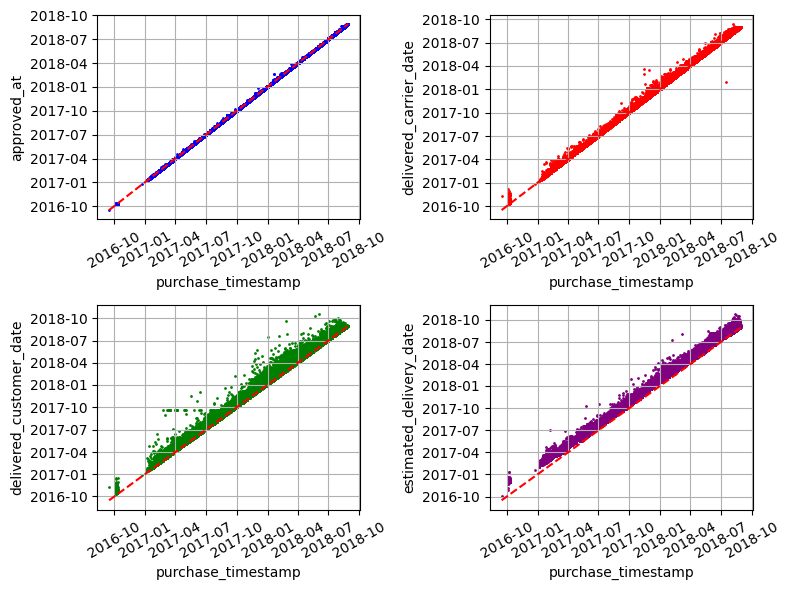

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

x = orders_delivered_limpio['order_purchase_timestamp']
min_val = min(x) ; max_val = max(x) # línea x=y

y1 = orders_delivered_limpio['order_approved_at']
axes[0, 0].scatter(x, y1,color='blue',s=1)
axes[0, 0].set_xlabel('purchase_timestamp') ; axes[0, 0].set_ylabel('approved_at')
axes[0, 0].tick_params(axis='x', labelrotation=30) ; axes[0, 0].grid(True)
axes[0, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

y2 = orders_delivered_limpio['order_delivered_carrier_date']
axes[0, 1].scatter(x, y2, color='red',s=1)
axes[0, 1].set_xlabel('purchase_timestamp') ; axes[0, 1].set_ylabel('delivered_carrier_date')
axes[0, 1].tick_params(axis='x', labelrotation=30) ; axes[0, 1].grid(True)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

y3 = orders_delivered_limpio['order_delivered_customer_date']
axes[1, 0].scatter(x, y3, color='green',s=1)
axes[1, 0].set_xlabel('purchase_timestamp') ; axes[1, 0].set_ylabel('delivered_customer_date')
axes[1, 0].tick_params(axis='x', labelrotation=30) ; axes[1, 0].grid(True)
axes[1, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

y4 = orders_delivered_limpio['order_estimated_delivery_date']
axes[1, 1].scatter(x, y4, color='purple',s=1)
axes[1, 1].set_xlabel('purchase_timestamp') ; axes[1, 1].set_ylabel('estimated_delivery_date')
axes[1, 1].tick_params(axis='x', labelrotation=30) ; axes[1, 1].grid(True)
axes[1, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

plt.tight_layout()
plt.show()

Viendo más cerca algunas fechas, por ejemplo una semana de Febrero 2018:

In [33]:
start_date = '2018-02-02' ; end_date = '2018-02-09'
orders_2018_02 = orders_delivered_limpio[orders_delivered_limpio['order_purchase_timestamp'].between(start_date, end_date)]

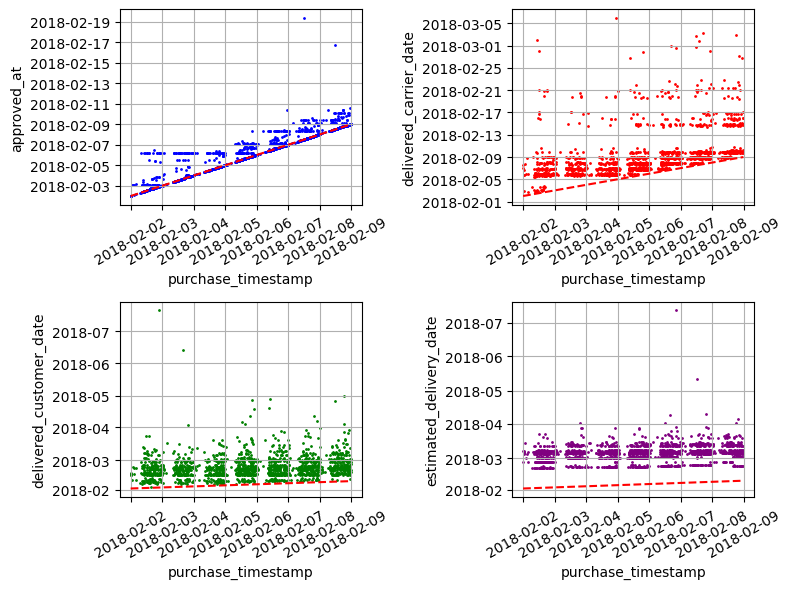

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(8,6))

x = orders_2018_02['order_purchase_timestamp']
min_val = min(x) ; max_val = max(x)

y1 = orders_2018_02['order_approved_at']
axes[0, 0].scatter(x, y1,color='blue',s=1)
axes[0, 0].set_xlabel('purchase_timestamp') ; axes[0, 0].set_ylabel('approved_at')
axes[0, 0].tick_params(axis='x', labelrotation=30) ; axes[0, 0].grid(True)
axes[0, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

y2 = orders_2018_02['order_delivered_carrier_date']
axes[0, 1].scatter(x, y2, color='red',s=1)
axes[0, 1].set_xlabel('purchase_timestamp') ; axes[0, 1].set_ylabel('delivered_carrier_date')
axes[0, 1].tick_params(axis='x', labelrotation=30) ; axes[0, 1].grid(True)
axes[0, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

y3 = orders_2018_02['order_delivered_customer_date']
axes[1, 0].scatter(x, y3, color='green',s=1)
axes[1, 0].set_xlabel('purchase_timestamp') ; axes[1, 0].set_ylabel('delivered_customer_date')
axes[1, 0].tick_params(axis='x', labelrotation=30) ; axes[1, 0].grid(True)
axes[1, 0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

y4 = orders_2018_02['order_estimated_delivery_date']
axes[1, 1].scatter(x, y4, color='purple',s=1)
axes[1, 1].set_xlabel('purchase_timestamp') ; axes[1, 1].set_ylabel('estimated_delivery_date')
axes[1, 1].tick_params(axis='x', labelrotation=30) ; axes[1, 1].grid(True)
axes[1, 1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x=y Line')

plt.tight_layout()
plt.show()

Las franjas horizontales sin datos, seguramente se relacionan a los fines de semana.

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Tomamos algunas ideas del siguiente notebook: [https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp](https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp)

**Armaremos columnas extras con la fecha de compra `order_purchase_timestamp`:**

* número año
* número mes
* número día del mes
* número día de la semana
* string año-mes
* string año-mes-dia
* hora del día
* momento del día

**Estas nos permitirán graficar la distribución temporal de las compras.**


In [35]:
orders_delivered_limpio['order_purchase_year'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.year)
orders_delivered_limpio['order_purchase_month'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.month)
orders_delivered_limpio['order_purchase_dayofmonth'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.day)
orders_delivered_limpio['order_purchase_dayofweek'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders_delivered_limpio['order_purchase_year_month'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
orders_delivered_limpio['order_purchase_year_month_day'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

orders_delivered_limpio['order_purchase_hour'] = orders_delivered_limpio['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [0, 6, 12, 18, 24]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
orders_delivered_limpio['order_purchase_time_day'] = pd.cut(orders_delivered_limpio['order_purchase_hour'], hours_bins, labels=hours_labels, right=False)

In [36]:
orders_delivered_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96455 entries, 0 to 96454
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96455 non-null  object        
 1   customer_id                    96455 non-null  object        
 2   order_purchase_timestamp       96455 non-null  datetime64[ns]
 3   order_approved_at              96455 non-null  datetime64[ns]
 4   order_delivered_carrier_date   96455 non-null  datetime64[ns]
 5   order_delivered_customer_date  96455 non-null  datetime64[ns]
 6   order_estimated_delivery_date  96455 non-null  datetime64[ns]
 7   order_purchase_year            96455 non-null  int64         
 8   order_purchase_month           96455 non-null  int64         
 9   order_purchase_dayofmonth      96455 non-null  int64         
 10  order_purchase_dayofweek       96455 non-null  int64         
 11  order_purchase_

C:\Users\Ale\AppData\Local\Temp\ipykernel_12092\2322518505.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


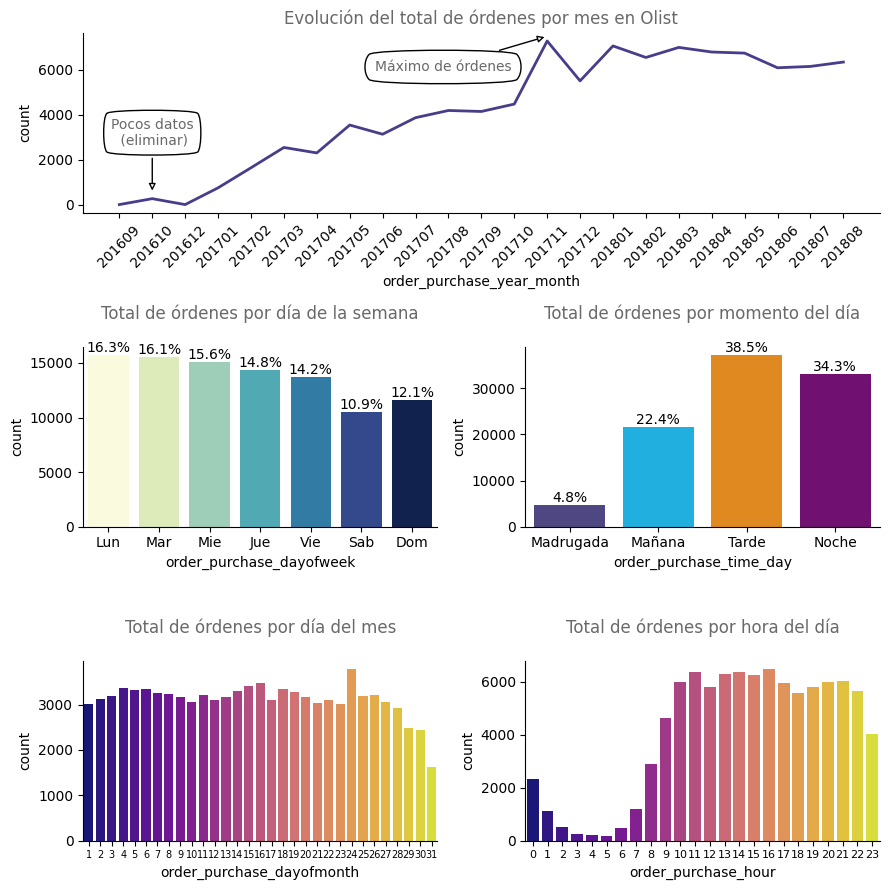

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(9, 9))
gs =  GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0]) ; ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0]) ; ax5 = fig.add_subplot(gs[2, 1])

# Lineplot - Evolution of e-commerce orders_delivered_limpio by month
sns.lineplot(data=orders_delivered_limpio['order_purchase_year_month'].value_counts().sort_index(),
             ax=ax1, color='darkslateblue', linewidth=2)
ax1.annotate(f'Máximo de órdenes', (13, 7500), xytext=(-75, -25),
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Pocos datos\n (eliminar)', (1, 500), xytext=(0, 35),
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.6),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.spines['top'].set_visible(False) ; ax1.spines['right'].set_visible(False)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolución del total de órdenes por mes en Olist', size=12, color='dimgrey')

# Barchart - Total of orders_delivered_limpio by day of week
sns.countplot(orders_delivered_limpio, x='order_purchase_dayofweek', hue='order_purchase_dayofweek',
              legend=False, ax=ax2, palette='YlGnBu')
weekday_label = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']
ax2.set_xticks(ax2.get_xticks()) # esto lo agregué para evitar un Warning
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total de órdenes por día de la semana', size=12, color='dimgrey', pad=20)
ax2.spines['top'].set_visible(False) ; ax2.spines['right'].set_visible(False)
# Showing frequency
ncount = len(orders_delivered_limpio)
for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0] ; y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom', size=10)

# Barchart - Total of orders_delivered_limpio by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
sns.countplot(orders_delivered_limpio, x='order_purchase_time_day', hue='order_purchase_time_day',
              legend=False, ax=ax3, palette=day_color_list)
momento_dia = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
ax3.set_xticks(ax3.get_xticks()) # esto lo agregué para evitar un Warning
ax3.set_xticklabels(momento_dia)
ax3.set_title('Total de órdenes por momento del día', size=12, color='dimgrey', pad=20)
ax3.spines['top'].set_visible(False) ; ax3.spines['right'].set_visible(False)
# Showing frequency
ncount = len(orders_delivered_limpio)
for p in ax3.patches:
    x=p.get_bbox().get_points()[:,0] ; y=p.get_bbox().get_points()[1,1]
    ax3.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom', size=10)

# Barchart - Total of orders_delivered_limpio by day of month
sns.countplot(orders_delivered_limpio, x='order_purchase_dayofmonth', hue='order_purchase_dayofmonth',
              legend=False, ax=ax4, palette='plasma')
ax4.set_title('Total de órdenes por día del mes', size=12, color='dimgrey', pad=20)
ax4.tick_params(axis='x', labelsize=7)
ax4.spines['top'].set_visible(False) ; ax4.spines['right'].set_visible(False)

# Barchart - Total of orders_delivered_limpio by hour of day
sns.countplot(orders_delivered_limpio, x='order_purchase_hour', hue='order_purchase_hour',
              legend=False, ax=ax5, palette='plasma')
ax5.set_title('Total de órdenes por hora del día', size=12, color='dimgrey', pad=20)
ax5.tick_params(axis='x', labelsize=8)
ax5.spines['top'].set_visible(False) ; ax5.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [38]:
orders_delivered_limpio['order_purchase_year_month'].value_counts().sort_index().head(8)

order_purchase_year_month
201609       1
201610     265
201612       1
201701     748
201702    1641
201703    2546
201704    2303
201705    3545
Name: count, dtype: int64

Vemos que hay datos incompletos en Septiembre y Diciembre de 2016. Los vamos a eliminar.

Además, eliminaremos los datos de Octubre 2016 y Enero 2017 ya que su volumen de compras es bajo comparado con los meses subsiguientes.


**Una pregunta que queda para pensar: hay un cambio significativo en el volumen de órdenes entre los años 2017 y 2018. Quizás a la hora de entrenar un modelo podemos elegir quedarnos solamente con los datos de 2018, ya que aspiramos a mejorar el actual modelo de predicción de fecha de entrega.**

In [39]:
mask = (orders_delivered_limpio['order_purchase_year_month']=='201609') | (orders_delivered_limpio['order_purchase_year_month']=='201610') | (orders_delivered_limpio['order_purchase_year_month']=='201612') | (orders_delivered_limpio['order_purchase_year_month']=='201701')

orders_delivered_limpio = orders_delivered_limpio[~mask]

In [40]:
orders_delivered_limpio['order_purchase_year_month'].value_counts().sort_index().head(5)

order_purchase_year_month
201702    1641
201703    2546
201704    2303
201705    3545
201706    3135
Name: count, dtype: int64

In [41]:
orders_delivered_limpio.shape

(95440, 15)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

Guardamos en la carpeta "bbdd_limpia":

In [ ]:
# orders_delivered_limpio_datatypes = orders_delivered_limpio.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/orders_delivered_limpio_datatypes.txt', "w") as file:
#     json.dump(orders_delivered_limpio_datatypes, file, indent=4)
# orders_delivered_limpio.to_csv('./bbdd_limpia/orders_delivered_limpio.csv', index=False)

---
### ORDER_PAYMENTS (103886 filas)

<u>Variables:</u>

*   `order_id`
    * Hay valores duplicados, resultan ser las órdenes que tienen `payment_sequential` mayor a 1. Y si sumamos el `payment_value` de esos duplicados nos da el valor total de la factura (que es igual a `price`+`freight_value` de cada item incluido en la factura como aparecen en el dataset `order_items`).
*   `payment_type`: tipo de pago. Variable desbalanceada:
    * `credit_card` es el 73.9%. Cuidado que hay 2 órdenes con "0" cuotas (ver `payment_installments`).
    * `boleto` el 19%. Entendemos que es generar un boleto de pago, código QR o de barras, que después uno puede ir a pagar en efectivo en un simil "rapipago". Todos tienen `payment_installments=1` y `payment_sequential=1`, excepto la siguiente órden: `order_id=931a32b4ca3fdc36741af29ea645d8bf`, tiene `payment_sequential=2` pero no está repetida (raro).
    * `voucher` el 5.6%
    * `debito` sólo el 1.5%.
    *  `not_defined` hay solamente 3 órdenes, tienen `payment_value=0`, asi que deberíamos eliminarlas. En  bbdd `orders` su `order_status=canceled`.
*   `payment_installments`: es pago en cuotas.
    * Todos los mayores a 1 tienen `payment_type=credit_card`.
    * 1 cuota: 50.6% , 2 cuotas: 11.9%, 3 cuotas: 10.1%, 4 cuotas: 6.8%, 5 cuotas: 5.0% y 6 cuotas: 3.8%, sumando un total de 88.2%.
    * Hay 2 órdenes con `payment_installments=0`.  Serán error de tipeo? Ver qué hacemos con las mismas:
        - `744bade1fcf9ff3f31d860ace076d422`
        - `1a57108394169c0b47d8f876acc9ba2d`
*   `payment_sequential`: Deducimos que es similar a un plan de pago.
    * 1 pago: 95.6%, 2 pagos: 2.9% y 3 pagos: 0.6%, lo cual acumula el 99.1%.
    * El monto total no se divide en partes iguales.
    * Todas las órdenes con `payment_value=0` que no son las 3 nombradas antes (not_defined), tienen `payment_sequential` > 1.
    * Cada pago de un tramo, genera una fila en esta base de datos, por lo que las órdenes repetidas deberían ser las que tienen `payment_sequential` > 1 (excepto la nombrada antes con `payment_type=boleto`).
*   `payment_value`. Es el monto que se paga en cada instancia. Si sumamos todos los correspondientes a cada `order_id` nos da el valor total de la factura.
    * Tiene algunos valores cero y varios que valen centavos. Parece ser que tiene que ver con los `payment_sequential`.

<u>Otras observaciones:</u>

* También hay órdenes que tienen `payment_sequential` mayor a 1 (o sea, aparecen mas de una vez), pero que además a algunas de esas instancias de pago las abonan con tarjeta de crédito en varias cuotas. Ver por ejemplo:
  * `1389d3b1fab26d87e40c382d11a8ac3c`
  * `a079628ac8002126e75f86b0f87332e4`
  * `7dc27189eb855013011423a5dcac71c3`
  * `3c8be270e7e602ffcde3f97cef934376`
* Otra curiosidad, las que son con tarjeta de crédito pero tienen `payment_installments=0` tienen `payment_sequential=2` y no están repetidas.

In [43]:
# profile_order_payments.to_notebook_iframe()

Separamos primero entre órdenes repetidas y no repetidas:

In [44]:
ids = order_payments["order_id"]
order_payments_duplicados = order_payments[ids.isin(ids[ids.duplicated()])]

In [45]:
order_payments_simples = order_payments[~order_payments['order_id'].isin(order_payments_duplicados['order_id'])]

In [46]:
order_payments_duplicados.shape

(7407, 5)

In [47]:
order_payments_simples.shape

(96479, 5)

In [48]:
order_payments_duplicados.nunique()

order_id                2961
payment_sequential        29
payment_type               3
payment_installments      15
payment_value           4448
dtype: int64

In [49]:
order_payments_simples.nunique()

order_id                96479
payment_sequential          2
payment_type                5
payment_installments       24
payment_value           27119
dtype: int64

En `order_payments_simples` sólo debería haber órdenes con `payment_sequential=1`, pero parece haber también otro número. Veamos:

In [50]:
order_payments_simples['payment_sequential'].value_counts()

payment_sequential
1    96401
2       78
Name: count, dtype: Int64

Además de la que tiene `payment_type=boleto`, hay 77 más.

In [51]:
order_payments_simples_sequential_2 =order_payments_simples.loc[order_payments_simples['payment_sequential']==2]
order_payments_simples_sequential_2.sort_values(by='payment_value')

order_id  payment_sequential payment_type  \
62609   0fdb6f73fab7005c84d4a43d8a93682b                   2   debit_card   
3071    d7d9f1ff0b6aa62f2d4e7fc99e60e8ea                   2   debit_card   
74449   9e20564752c879d871ac6c809777e4d1                   2   debit_card   
44717   8c13aa9bfa920854ca73694d94387d40                   2   debit_card   
85339   cb6c4a73c3a96d368b2eb15d29d0a243                   2   debit_card   
...                                  ...                 ...          ...   
45014   b6424d3ecaedf5f49836d503d4f0d671                   2  credit_card   
62964   229d2824e311bf2592b6b7ce32af04a8                   2  credit_card   
103462  d1c8a4c31e8c7baecf7db50c988e5527                   2   debit_card   
85318   389a9ea0a3b847e32aafa6fc297e2a9d                   2  credit_card   
68560   45acb6840b062e10dd63454b19ce5212                   2   debit_card   

        payment_installments  payment_value  
62609                      1          34.13  
3071                       1          35.00  
74449                      1          35.00  
44717                      1          35.77  
85339                      1          37.04  
...                      ...            ...  
45014                      4         422.47  
62964                      8         437.26  
103462                     1         584.33  
85318                      3         828.65  
68560                      1         847.38  

[78 rows x 5 columns]

Si asumimos para estas órdenes que hay otra instancia de pago, la número 1, que no aparece, entonces el monto de `payment_value` no debería ser el total. Comparemos con el valor total de cada órden construido a partir del dataset `order_item` (analizaremos con detalle este dataset mas adelante)

In [52]:
ordenes_aux = order_payments_simples_sequential_2['order_id']

from_order_items = order_items[order_items['order_id'].isin(ordenes_aux)].groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
}).reset_index()
from_order_items['total_value'] = from_order_items['price'] + from_order_items['freight_value']
from_order_items.sort_values(by='total_value')

order_id   price  freight_value  total_value
5   0fdb6f73fab7005c84d4a43d8a93682b   15.90          18.23        34.13
43  9e20564752c879d871ac6c809777e4d1   19.90          15.10        35.00
66  d7d9f1ff0b6aa62f2d4e7fc99e60e8ea   19.90          15.10        35.00
37  8c13aa9bfa920854ca73694d94387d40   27.90           7.87        35.77
56  cb6c4a73c3a96d368b2eb15d29d0a243   18.00          19.04        37.04
..                               ...     ...            ...          ...
49  b6424d3ecaedf5f49836d503d4f0d671  297.00         125.47       422.47
10  229d2824e311bf2592b6b7ce32af04a8  397.79          39.47       437.26
62  d1c8a4c31e8c7baecf7db50c988e5527  529.90          54.43       584.33
17  389a9ea0a3b847e32aafa6fc297e2a9d  799.90          28.75       828.65
23  45acb6840b062e10dd63454b19ce5212  779.90          67.48       847.38

[77 rows x 4 columns]

Los montos aparentan ser iguales. Chequeemos:

In [53]:
order_payments_simples_sequential_2.set_index('order_id', inplace=True)
from_order_items.set_index('order_id', inplace=True)
diferencia = order_payments_simples_sequential_2['payment_value']-from_order_items['total_value']
diferencia.dropna().sort_values()

order_id
1896e8b8fd196151559b02e31e98ce89   -1.000000e-02
3263e5243c28ebe706f7500cf88054ad   -1.000000e-02
4018300cd8f4f33f0791e63dd085a089   -2.842171e-14
66b28b67d37eb8809a5cf1cc3ceb8310   -2.842171e-14
4b2dcf714729a31ae2d3b69b1dd35629   -2.842171e-14
                                        ...     
de1c6db658e84e0ba847b2c1bc857bb5    1.421085e-14
931a32b4ca3fdc36741af29ea645d8bf    1.421085e-14
b74ea2b3c3e2bbe005621c14ca939889    1.421085e-14
cc809786d515550e76739eda2f98973e    5.684342e-14
d1c8a4c31e8c7baecf7db50c988e5527    1.136868e-13
Length: 77, dtype: float64

In [54]:
diferencia.sum()

np.float64(-0.019999999999939178)

Entonces, las órdenes NO repetidas en `order_payment` pero que tienen un `payment_sequential=2` poseen un monto de pago igual al valor total de la factura, es decir como si tuvieran `payment_sequential=1`.

**Decidimos entonces cambiar, en esas órdenes, el `payment sequential` al valor 1.**

In [55]:
order_payments.loc[order_payments['order_id'].isin(ordenes_aux),'payment_sequential']=1

Chequeamos:

In [56]:
ids = order_payments["order_id"]
order_payments_simples = order_payments[~ids.isin(ids[ids.duplicated()])]

print(order_payments_simples.shape)
order_payments_simples['payment_sequential'].value_counts()

(96479, 5)


payment_sequential
1    96479
Name: count, dtype: Int64

In [57]:
order_payments[order_payments['order_id']=='931a32b4ca3fdc36741af29ea645d8bf']

order_id  payment_sequential payment_type  \
80759  931a32b4ca3fdc36741af29ea645d8bf                   1       boleto   

       payment_installments  payment_value  
80759                     1           94.4

Veamos ahora qué hacer con las que tiene `payment_type=credit_card` y `payment_installments=0`.

In [58]:
order_payments.loc[order_payments['payment_installments']==0]

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   1  credit_card   
79014  1a57108394169c0b47d8f876acc9ba2d                   1  credit_card   

       payment_installments  payment_value  
46982                     0          58.69  
79014                     0         129.94

¿Cuánto sería el monto total de la factura?

In [59]:
order_items.loc[(order_items['order_id']=='744bade1fcf9ff3f31d860ace076d422') | (order_items['order_id']=='1a57108394169c0b47d8f876acc9ba2d') ,['order_id','price','freight_value']]

order_id  price  freight_value
11589  1a57108394169c0b47d8f876acc9ba2d  41.69          23.28
11590  1a57108394169c0b47d8f876acc9ba2d  41.69          23.28
51167  744bade1fcf9ff3f31d860ace076d422  45.90          12.79

In [60]:
print(45.90+12.79)
print(2*(41.69+23.28))

58.69
129.94


Entonces, todo indica que `payment_installments=0` es un error de typeo. Puede ser que no se guardó el número de cuotas, o que debían ser 10 y se borró el 1.

**Decidimos cambiarlo a 1.**

In [61]:
order_payments.loc[order_payments['payment_installments']==0,'payment_installments']=1

Chequeo:

In [62]:
order_payments.loc[(order_payments['order_id']=='744bade1fcf9ff3f31d860ace076d422') | (order_payments['order_id']=='1a57108394169c0b47d8f876acc9ba2d')]

order_id  payment_sequential payment_type  \
46982  744bade1fcf9ff3f31d860ace076d422                   1  credit_card   
79014  1a57108394169c0b47d8f876acc9ba2d                   1  credit_card   

       payment_installments  payment_value  
46982                     1          58.69  
79014                     1         129.94

Exploremos ahora las que tienen `payment_type=not_defined`

In [63]:
orders_not_defined = order_payments[order_payments['payment_type']=='not_defined']
orders_not_defined

order_id  payment_sequential payment_type  \
51280  4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411  00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
94427  c8c528189310eaa44a745b8d9d26908b                   1  not_defined   

       payment_installments  payment_value  
51280                     1            0.0  
57411                     1            0.0  
94427                     1            0.0

Busquemos su status en el dataset `orders`:

In [64]:
orders[orders['order_id'].isin(orders_not_defined['order_id'])]

order_id                       customer_id  \
1130   00b1cb0320190ca0daa2c88b35206009  3532ba38a3fd242259a514ac2b6ae6b6   
39919  4637ca194b6387e2d538dc89b124b0ee  a73c1f73f5772cf801434bf984b0b1a7   
40235  c8c528189310eaa44a745b8d9d26908b  197a2a6a77da93f678ea0d379f21da0a   

      order_status order_purchase_timestamp order_approved_at  \
1130      canceled      2018-08-28 15:26:39               NaT   
39919     canceled      2018-09-03 14:14:25               NaT   
40235     canceled      2018-08-28 20:05:14               NaT   

      order_delivered_carrier_date order_delivered_customer_date  \
1130                           NaT                           NaT   
39919                          NaT                           NaT   
40235                          NaT                           NaT   

      order_estimated_delivery_date  
1130                     2018-09-12  
39919                    2018-09-10  
40235                    2018-09-11

Vemos que están canceladas.

**Más adelante las vamos a eliminar de este datafame, aunque igualmente ya fueron eliminadas del dataframe orders.**

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Separamos de nuevo entre duplicados y no-duplicados, con la planilla modificada.

In [65]:
ids = order_payments["order_id"]
order_payments_simples = order_payments[~ids.isin(ids[ids.duplicated()])]
order_payments_duplicados = order_payments[ids.isin(ids[ids.duplicated()])]

In [66]:
order_payments_simples['payment_type'].value_counts()

payment_type
credit_card    73972
boleto         19784
debit_card      1526
voucher         1194
not_defined        3
Name: count, dtype: int64

In [67]:
order_payments_duplicados['payment_type'].value_counts()

payment_type
voucher        4581
credit_card    2823
debit_card        3
Name: count, dtype: int64

Una observación a hacer es que para las órdenes cuyo monto total ha sido dividido (o sea, `payment_sequential` mayor a 1) casi todos los pagos se hacen con **voucher** o **tarjeta de crédito**.

Sólo 3 de esos se pagaron con **debit_card**.

Veamos:

In [68]:
order_payments_duplicados[order_payments_duplicados['payment_type']=='debit_card']

order_id  payment_sequential payment_type  \
36471  a079628ac8002126e75f86b0f87332e4                   2   debit_card   
60570  a4431cbd79dbddaae7988ce6091cbc3c                   2   debit_card   
90465  a4431cbd79dbddaae7988ce6091cbc3c                   3   debit_card   

       payment_installments  payment_value  
36471                     1           50.0  
60570                     1           26.2  
90465                     1           20.0

veamos todas las filas que corresponden a esas órdenes:

In [69]:
seleccion=order_payments[
    (order_payments['order_id']=='a079628ac8002126e75f86b0f87332e4') |
    (order_payments['order_id']=='a4431cbd79dbddaae7988ce6091cbc3c')
]
seleccion

order_id  payment_sequential payment_type  \
10258  a079628ac8002126e75f86b0f87332e4                   3  credit_card   
36471  a079628ac8002126e75f86b0f87332e4                   2   debit_card   
60570  a4431cbd79dbddaae7988ce6091cbc3c                   2   debit_card   
90465  a4431cbd79dbddaae7988ce6091cbc3c                   3   debit_card   

       payment_installments  payment_value  
10258                     3         102.82  
36471                     1          50.00  
60570                     1          26.20  
90465                     1          20.00

Estás 2 órdenes no tienen instancia con `payment_sequential=1`. ¿Qué querrá decir?

Chequeamos si el monto total pagado se corresponden con el monto calculado del dataframe order_items.

In [70]:
seleccion.groupby('order_id').agg({
    'payment_value': 'sum',
})

payment_value
order_id                                       
a079628ac8002126e75f86b0f87332e4         152.82
a4431cbd79dbddaae7988ce6091cbc3c          46.20

In [71]:
order_items.loc[(order_items['order_id']=='a079628ac8002126e75f86b0f87332e4') | (order_items['order_id']=='a4431cbd79dbddaae7988ce6091cbc3c')]

order_id  order_item_id  \
70329  a079628ac8002126e75f86b0f87332e4              1   
72009  a4431cbd79dbddaae7988ce6091cbc3c              1   

                             product_id                         seller_id  \
70329  0983cd4a5cabf1099659ce461511963c  3d2531eccfbde1d7c8db7a3a12fb267a   
72009  89321f94e35fc6d7903d36f74e351d40  16090f2ca825584b5a147ab24aa30c86   

      shipping_limit_date  price  freight_value  
70329 2018-05-03 11:31:22  99.99          52.83  
72009 2018-06-21 13:16:55  27.90          18.30

In [72]:
print(99.99+52.83)
print(27.90+18.30)

152.82
46.2


Entonces no parece haber órdenes perdidas, y que falten los pagos con `payment_sequential=1` es un error que bien podría ser de tipeo.

**Decidimos renumerar los `payment_sequential`de éstas órdenes.**

In [73]:
seleccion

order_id  payment_sequential payment_type  \
10258  a079628ac8002126e75f86b0f87332e4                   3  credit_card   
36471  a079628ac8002126e75f86b0f87332e4                   2   debit_card   
60570  a4431cbd79dbddaae7988ce6091cbc3c                   2   debit_card   
90465  a4431cbd79dbddaae7988ce6091cbc3c                   3   debit_card   

       payment_installments  payment_value  
10258                     3         102.82  
36471                     1          50.00  
60570                     1          26.20  
90465                     1          20.00

In [74]:
order_payments.loc[10258,'payment_sequential']=2
order_payments.loc[36471,'payment_sequential']=1
order_payments.loc[60570,'payment_sequential']=1
order_payments.loc[90465,'payment_sequential']=2

Chequeamos:

In [75]:
order_payments[
    (order_payments['order_id']=='a079628ac8002126e75f86b0f87332e4') |
    (order_payments['order_id']=='a4431cbd79dbddaae7988ce6091cbc3c')
]

order_id  payment_sequential payment_type  \
10258  a079628ac8002126e75f86b0f87332e4                   2  credit_card   
36471  a079628ac8002126e75f86b0f87332e4                   1   debit_card   
60570  a4431cbd79dbddaae7988ce6091cbc3c                   1   debit_card   
90465  a4431cbd79dbddaae7988ce6091cbc3c                   2   debit_card   

       payment_installments  payment_value  
10258                     3         102.82  
36471                     1          50.00  
60570                     1          26.20  
90465                     1          20.00

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Una pregunta que nos surge luego de estos últimos pasos es si habrá otras órdenes que tengan errores en la numeracion de `sequential`.

Podemos pensarlo asi:
* Para `sequential` igual a 2, ese `order_id` debería tener otra instancia con `sequential` igual a 1.
* Para `sequential` igual a 3, ese `order_id` debería tener otras dos instancias con `sequential` 1 y 2.
* etc.

Entonces, podemos sumar los `payment_sequential` para cada `order_id`  y verificar que estén en la secuencia de números 1, 3, 6, 10, 15... que sale de sumar todos los enteros hasta un valor. Si hay $n$ pagos, esta suma dará $n (n+1)/2$.

Veamos primero cuál es el sequential máximo y armamos una lista con la suma hasta ese valor:

In [76]:
order_payments['payment_sequential'].max()

np.int64(29)

In [77]:
lista = list()
for i in range(1,30):
  lista.append(i*(i+1)/2)
print(lista)

[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0, 36.0, 45.0, 55.0, 66.0, 78.0, 91.0, 105.0, 120.0, 136.0, 153.0, 171.0, 190.0, 210.0, 231.0, 253.0, 276.0, 300.0, 325.0, 351.0, 378.0, 406.0, 435.0]


Agrupamos por `order_id`.

A `payment_sequential` lo sumamos y luego compararemos con la lista. Para `payment_type` tomamos el valor más repetido, para `payment_installments` tomamos el máximo (mayor número de cuotas usadas), y a `payment_value` lo sumamos para obtener el valor total de la órden.

In [78]:
payments_agrupados = order_payments.groupby('order_id').agg({
    'payment_sequential': 'sum',
    'payment_type': lambda x: x.mode().iat[0],
    'payment_installments': 'max',
    'payment_value': 'sum',
})
payments_agrupados.head()

payment_sequential payment_type  \
order_id                                                            
00010242fe8c5a6d1ba2dd792cb16214                   1  credit_card   
00018f77f2f0320c557190d7a144bdd3                   1  credit_card   
000229ec398224ef6ca0657da4fc703e                   1  credit_card   
00024acbcdf0a6daa1e931b038114c75                   1  credit_card   
00042b26cf59d7ce69dfabb4e55b4fd9                   1  credit_card   

                                  payment_installments  payment_value  
order_id                                                               
00010242fe8c5a6d1ba2dd792cb16214                     2          72.19  
00018f77f2f0320c557190d7a144bdd3                     3         259.83  
000229ec398224ef6ca0657da4fc703e                     5         216.87  
00024acbcdf0a6daa1e931b038114c75                     2          25.78  
00042b26cf59d7ce69dfabb4e55b4fd9                     3         218.04

Verificamos si están todos en la lista:

In [79]:
payments_agrupados['payment_sequential'].apply(lambda x: x in lista).sum()

np.int64(99440)

In [80]:
payments_agrupados.shape

(99440, 4)

**csvente. Todos los pagos con `payment_sequential` están en orden.**

---
Eliminamos ahora los "not_defined":

In [81]:
mask = order_payments['payment_type']=='not_defined'

order_payments_limpio = order_payments[~mask]

In [82]:
order_payments_limpio.shape

(103883, 5)

In [83]:
order_payments_limpio['payment_type'].value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
Name: count, dtype: int64

Distribución final de los métodos de pago:

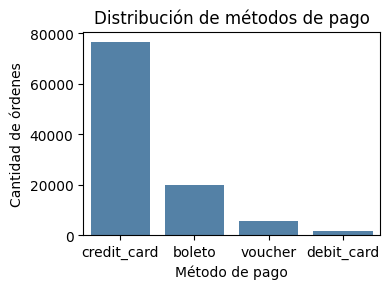

In [84]:
plt.figure(figsize=(4,3))
sns.countplot(data=order_payments_limpio,x='payment_type',
              order=order_payments_limpio['payment_type'].value_counts().index,
              color='steelblue')
plt.title('Distribución de métodos de pago')
plt.xlabel('Método de pago') ; plt.ylabel('Cantidad de órdenes')
plt.tight_layout() ; plt.show()

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Chequeamos también si los montos totales obtenidos de `order_payments` coinciden con los montos totales obtenidos de `order_items`:

In [85]:
order_payments_total = order_payments_limpio.groupby('order_id').agg({
    'payment_value': 'sum',
}).reset_index()
order_payments_total

order_id  payment_value
0      00010242fe8c5a6d1ba2dd792cb16214          72.19
1      00018f77f2f0320c557190d7a144bdd3         259.83
2      000229ec398224ef6ca0657da4fc703e         216.87
3      00024acbcdf0a6daa1e931b038114c75          25.78
4      00042b26cf59d7ce69dfabb4e55b4fd9         218.04
...                                 ...            ...
99432  fffc94f6ce00a00581880bf54a75a037         343.40
99433  fffcd46ef2263f404302a634eb57f7eb         386.53
99434  fffce4705a9662cd70adb13d4a31832d         116.85
99435  fffe18544ffabc95dfada21779c9644f          64.71
99436  fffe41c64501cc87c801fd61db3f6244          55.79

[99437 rows x 2 columns]

In [86]:
ordenes_aux = order_payments_total['order_id']

from_order_items = order_items[order_items['order_id'].isin(ordenes_aux)].groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
}).reset_index()

from_order_items['total_value'] = from_order_items['price'] + from_order_items['freight_value']
from_order_items.sort_values(by='total_value')

order_payments_total.set_index('order_id', inplace=True)
from_order_items.set_index('order_id', inplace=True)

comparacion = order_payments_total.merge(from_order_items, left_index=True, right_index=True)

comparacion.dropna(inplace=True)
comparacion['diferencia']=(comparacion['payment_value']-from_order_items['total_value']).abs()
comparacion['diferencia']=comparacion['diferencia'].round(2)
comparacion

payment_value   price  freight_value  \
order_id                                                                 
00010242fe8c5a6d1ba2dd792cb16214          72.19   58.90          13.29   
00018f77f2f0320c557190d7a144bdd3         259.83  239.90          19.93   
000229ec398224ef6ca0657da4fc703e         216.87  199.00          17.87   
00024acbcdf0a6daa1e931b038114c75          25.78   12.99          12.79   
00042b26cf59d7ce69dfabb4e55b4fd9         218.04  199.90          18.14   
...                                         ...     ...            ...   
fffc94f6ce00a00581880bf54a75a037         343.40  299.99          43.41   
fffcd46ef2263f404302a634eb57f7eb         386.53  350.00          36.53   
fffce4705a9662cd70adb13d4a31832d         116.85   99.90          16.95   
fffe18544ffabc95dfada21779c9644f          64.71   55.99           8.72   
fffe41c64501cc87c801fd61db3f6244          55.79   43.00          12.79   

                                  total_value  diferencia  
order_id                                                   
00010242fe8c5a6d1ba2dd792cb16214        72.19         0.0  
00018f77f2f0320c557190d7a144bdd3       259.83         0.0  
000229ec398224ef6ca0657da4fc703e       216.87         0.0  
00024acbcdf0a6daa1e931b038114c75        25.78         0.0  
00042b26cf59d7ce69dfabb4e55b4fd9       218.04         0.0  
...                                       ...         ...  
fffc94f6ce00a00581880bf54a75a037       343.40         0.0  
fffcd46ef2263f404302a634eb57f7eb       386.53         0.0  
fffce4705a9662cd70adb13d4a31832d       116.85         0.0  
fffe18544ffabc95dfada21779c9644f        64.71         0.0  
fffe41c64501cc87c801fd61db3f6244        55.79         0.0  

[98665 rows x 5 columns]

Diferencias mayores a 10 centavos de real:

In [87]:
comparacion['diferencia'].loc[comparacion['diferencia'] > 0.1].sort_values()

order_id
b38b3526b8b8fdc807e8a0a42ab78573      0.13
e393acae9e64be5b2a7d48ef2ae87710      0.35
2240d9349c55949c40dbfcc98ece280c      0.36
af9f47d85cb6d0717a873ddb331a1b6b      0.37
3ff25314bbe9dc1ec7c983499bdff8f2      0.59
                                     ...  
70b7e94ea46d3e8b5bc12a50186edaf0     61.69
996c7e73600ad3723e8627ab7bef81e4     76.53
70b742795bc441e94a44a084b6d9ce7a    111.89
6e5fe7366a2e1bfbf3257dba0af1267f    119.01
ce6d150fb29ada17d2082f4847107665    182.81
Name: diferencia, Length: 259, dtype: float64

Entonces, hay 259 id de órdenes cuyo monto calculado desde order_payments difiere en mas de 10 centavos de Real del calculado desde order_items.

Mayor a 1 Real?

In [88]:
comparacion['diferencia'].loc[comparacion['diferencia'] > 1.0].sort_values()

order_id
bcb9cb204fb7137dcb5dc3fdb94f11e5      1.01
aa962f90c14940f2df3c6184f35a2184      1.23
c253cb678b5c3b8e8c9a13fc97d8e7f5      1.24
57a82955454fb2a9a18633d841ac480d      1.29
5af817dcc7682f13101dbdef134be4e0      1.33
                                     ...  
70b7e94ea46d3e8b5bc12a50186edaf0     61.69
996c7e73600ad3723e8627ab7bef81e4     76.53
70b742795bc441e94a44a084b6d9ce7a    111.89
6e5fe7366a2e1bfbf3257dba0af1267f    119.01
ce6d150fb29ada17d2082f4847107665    182.81
Name: diferencia, Length: 249, dtype: float64

Vamos a eliminar estas órdenes aquí, y guardar los `order_id` para eliminarlas también en los dataframes `orders` y `order_items`.

In [89]:
comparacion.reset_index(inplace=True)

In [90]:
ids_borrar_de_items_y_orders = comparacion[comparacion['diferencia'] > 1.0]['order_id']
ids_borrar_de_items_y_orders.head()

165     00789ce015e7e5791c7914f32bb4fad4
525     016726239765c18f66826453f39c64e3
724     01e51b7c3025655646143d09b911e1d7
965     028aa7c930356788f861ed1b7f984819
1123    02f4dd90ba0feb8ec394cac05862d2b5
Name: order_id, dtype: object

In [91]:
order_payments_limpio = order_payments_limpio[~order_payments_limpio['order_id'].isin(ids_borrar_de_items_y_orders)]

In [92]:
order_payments_limpio.shape

(103623, 5)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

In [ ]:
# ids_borrar_de_items_y_orders.to_csv('./bbdd_limpia/ids_borrar_de_items_y_orders.csv', index=False)
# order_payments_limpio_datatypes = order_payments_limpio.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/order_payments_limpio_datatypes.txt', "w") as file:
#     json.dump(order_payments_limpio_datatypes, file, indent=4)
# order_payments_limpio.to_csv('./bbdd_limpia/order_payments_limpio.csv', index=False)

---
---
### ORDER_ITEMS (112650 filas)

<u>Variables:</u>

*   `order_id`
*   `order_item_id`: Número secuencial que identifica la posición en que el item fue incluido en la orden.
    * Órdenes con 1 item 87.6 %, 2 items 8.7 % y 3 items 2 %. Con hasta 2 items explican 96.3 % de las órdenes, con hasta 3 items explican el 98.3 %.
    * Esta variable debería cumplir con la misma propiedad que `payment_sequential` en order_payments, es decir, si hay un item con `order_item_id=3` entonces debería haber 2 más con la misma `order_id` que dan cuenta de los items 1 y 2.
*   `product_id`: Identificador de producto.
*   `seller_id`: Identificador de vendedor.
*   `shipping_limit_date`: "*Shows the seller shipping limit date for handling the order over to the logistic partner*." Es la fecha límite que tiene el vendedor para despachar el paquete.
    * Tiene 4 valores desubicados fechados en 2020.
    * Comparando esta variable con `order_delivered_carrier_date` (en `orders`) podríamos obtener información sobre la efectividad o compromiso del vendedor.
*   `price`: precio del item.
    * Tiene un mínimo de 0.85 reales. Si hubiese items de valor cero tendríamos que ver con más detalle.
    * La mayoría de los items valen menos de 200 reales.
*   `freight_value`: Valor de flete. Si una orden tiene más de un item, el flete se divide entre los items. Es decir, el valor de flete es para cada item.
    * Tiene algunas filas con valor cero.
    * Para gran cantidad de items (93 %) el flete vale 40 reales o menos.

In [94]:
# profile_order_items.to_notebook_iframe()

In [95]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  Int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(2), object(3)
memory usage: 6.1+ MB


In [96]:
order_items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Realizamos con `order_item_id` el mismo análisis que con `payment_sequential`:

In [97]:
order_items['order_item_id'].value_counts().head()

order_item_id
1    98666
2     9803
3     2287
4      965
5      460
Name: count, dtype: Int64

In [98]:
order_items['order_item_id'].max()

np.int64(21)

In [99]:
lista = list()
for i in range(1,22):
  lista.append(i*(i+1)/2)

items_agrupados = order_items.groupby('order_id').agg({
    'order_item_id': 'sum', # sumo la numeración de items agregados
    'seller_id': lambda x: x.mode().iat[0], # elijo el seller más repetido
    'shipping_limit_date': 'min', # la fecha límite de despacho más temprana
    'price': 'sum', # sumo precio de los items
    'freight_value': 'sum', # sumo valor de fletes
})

In [100]:
print(lista)

[1.0, 3.0, 6.0, 10.0, 15.0, 21.0, 28.0, 36.0, 45.0, 55.0, 66.0, 78.0, 91.0, 105.0, 120.0, 136.0, 153.0, 171.0, 190.0, 210.0, 231.0]


In [101]:
items_agrupados['order_item_id'].value_counts().sort_index()

order_item_id
1      88863
3       7516
6       1322
10       505
15       204
21       198
28        22
36         8
45         3
55         8
66         4
78         5
91         1
105        2
120        2
210        2
231        1
Name: count, dtype: Int64

In [102]:
print(items_agrupados['order_item_id'].apply(lambda x: x in lista).sum())
print(items_agrupados.shape[0])


98666
98666


**Vemos que finalmente no hay problemas con `order_item_id`**

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Veamos los casos de `shipping_limit_date` posterior a Septiembre 2018 (que es el último mes de las compras):

In [103]:
order_items[order_items['shipping_limit_date'] >= '2018-10-01']

order_id  order_item_id  \
8643   13bdf405f961a6deec817d817f5c6624              1   
68516  9c94a4ea2f7876660fa6f1b59b69c8e6              1   
85729  c2bb89b5c1dd978d507284be78a04cb2              1   
85730  c2bb89b5c1dd978d507284be78a04cb2              2   

                             product_id                         seller_id  \
8643   96ea060e41bdecc64e2de00b97068975  7a241947449cc45dbfda4f9d0798d9d0   
68516  282b126b2354516c5f400154398f616d  7a241947449cc45dbfda4f9d0798d9d0   
85729  87b92e06b320e803d334ac23966c80b1  7a241947449cc45dbfda4f9d0798d9d0   
85730  87b92e06b320e803d334ac23966c80b1  7a241947449cc45dbfda4f9d0798d9d0   

      shipping_limit_date  price  freight_value  
8643  2020-02-05 03:30:51  69.99          14.66  
68516 2020-02-03 20:23:22  75.99          14.70  
85729 2020-04-09 22:35:08  99.99          61.44  
85730 2020-04-09 22:35:08  99.99          61.44

Seleccionemos éstas órdenes y veamos sus características en el dataset "orders":

In [104]:
shipping_late = ['13bdf405f961a6deec817d817f5c6624','9c94a4ea2f7876660fa6f1b59b69c8e6','c2bb89b5c1dd978d507284be78a04cb2']
# order_items[order_items['order_id'].isin(shipping_late)]
orders[orders['order_id'].isin(shipping_late)]

order_id                       customer_id  \
36034  13bdf405f961a6deec817d817f5c6624  b279a1d441c73c1974d7a63618855aa0   
55368  9c94a4ea2f7876660fa6f1b59b69c8e6  22e922696a7d1ab9a19c6b702fedc387   
86444  c2bb89b5c1dd978d507284be78a04cb2  6357fffb5704244d552615bbfcea1442   

      order_status order_purchase_timestamp   order_approved_at  \
36034     canceled      2017-03-16 02:30:51 2017-03-16 02:30:51   
55368      shipped      2017-03-14 19:23:22 2017-03-14 19:23:22   
86444    delivered      2017-05-23 22:28:36 2017-05-24 22:35:08   

      order_delivered_carrier_date order_delivered_customer_date  \
36034                          NaT                           NaT   
55368          2017-03-16 14:31:15                           NaT   
86444          2017-05-29 02:03:28           2017-06-09 13:35:54   

      order_estimated_delivery_date  
36034                    2017-08-08  
55368                    2017-08-04  
86444                    2017-10-11

Solamente la última (`id=c2bb89b5c1dd978d507284be78a04cb2`) estará en `order_delivered_limpio`, y al parece no hubo problemas en el envío.

Eliminamos las otras 2 en `order_items`:

In [105]:
mask = (order_items['order_id']=='13bdf405f961a6deec817d817f5c6624') | (order_items['order_id']=='9c94a4ea2f7876660fa6f1b59b69c8e6')
order_items_limpio = order_items[~mask]
# order_items_limpio = order_items.drop([8643,68516], axis=0)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Borramos las órdenes cuyos montos totales pagados difierán en mas de 1 Real del obtenido en `order_payments` (al igual que ya los eliminamos en `order_payments`):

In [106]:
order_items_limpio = order_items_limpio[~order_items_limpio['order_id'].isin(ids_borrar_de_items_y_orders)]

In [107]:
order_items_limpio.shape

(112369, 7)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

In [108]:
# order_items_limpio_datatypes = order_items_limpio.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/order_items_limpio_datatypes.txt', "w") as file:
#     json.dump(order_items_limpio_datatypes, file, indent=4)
# order_items_limpio.to_csv('./bbdd_limpia/order_items_limpio.csv', index=False)

---
---
### CUSTOMERS (99441 filas)

<u>Variables:</u>

*   `customer_id`: Clave que relaciona con el dataset de órdenes. Cada órden tiene un `customer_id` único.
*   `customer_unique_id`: Identificador único del comprador.
    * Hay menor cantidad de `customer_unique_id` (identifica a cada cliente individual) que `customer_id` (relaciona cada fila de esta tabla con la tabla de órdenes). Esto quiere decir que hay algunos clientes que han comprado más de una vez. No parece ser más del 3 % de las compras.
*   `customer_zip_code_prefix`: Primeros 5 dígitos del código postal del comprador.
*   `customer_city`: Nombre de ciudad del comprador.
    * Tiene alta cardinalidad, o sea que hay muchas ciudades con uno o pocos usuarios/customers (lo mismo pasa con `zip_code` y `state`, pero el profiling no lo muestra porque son variables categoricas).
*   `customer_state`: Estado (provincia) del comprador.
    * Hay alta correlación entre `customer_zip_code_prefix` y `customer_state`, obviamente.

In [109]:
# profile_customers.to_notebook_iframe()

In [110]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [111]:
1.-96096/99441

0.033638036624732304

Normalizamos nombres de ciudades y pasamos a minúsculas:

In [112]:
customers['customer_city'] = customers['customer_city'].apply(lambda x: unidecode(x).lower())

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

¿Cómo es la distribución de compradores por estado?

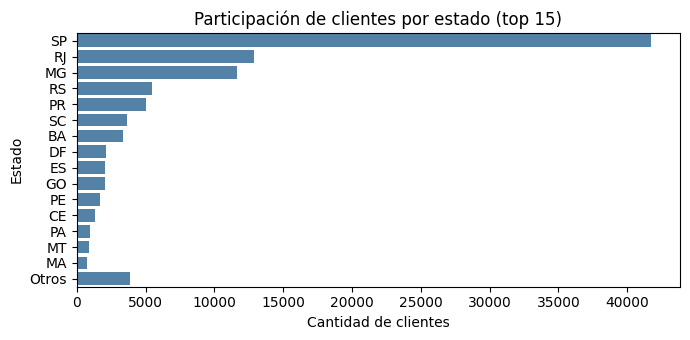

In [113]:
state_counts = customers['customer_state'].value_counts()
top15        = state_counts.nlargest(15)
serie_plot  = pd.concat([top15,
                         pd.Series({'Otros': state_counts.sum() - top15.sum()})]
                       ).sort_values(ascending=False)

orden = list(top15.index) + ['Otros']
serie_plot = serie_plot.reindex(orden)

# grafico
plt.figure(figsize=(7, 3.5))
sns.barplot(x=serie_plot.values, y=serie_plot.index, color='steelblue')
plt.title('Participación de clientes por estado (top 15)')
plt.xlabel('Cantidad de clientes')
plt.ylabel('Estado')
plt.tight_layout()
plt.show()

Este dataset parece no tener por ahora ningún otro problema de limpieza.

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

In [114]:
# customers_limpio_datatypes = customers.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/customers_limpio_datatypes.txt', "w") as file:
#     json.dump(customers_limpio_datatypes, file, indent=4)
# customers.to_csv('./bbdd_limpia/customers_limpio.csv', index=False)

---
---
### SELLERS (3095 filas)

<u>Variables</u> (similares a `customers`):

*   `seller_id`
*   `seller_zip_code_prefix`
*   `seller_city`
     * Tiene alta cardinalidad, como sucedía en Customer.
*   `seller_state`
    * El 59.7% es de Sao Paulo (SP)
    *   Hay correlación entre `seller_zip_code_prefix` y `seller_state`, igual que en Customer.

In [115]:
# profile_sellers.to_notebook_iframe()

In [116]:
sellers['seller_state'].value_counts()

seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
RO       2
SE       2
AC       1
PI       1
MA       1
AM       1
PA       1
Name: count, dtype: int64

In [117]:
1849 / sellers.shape[0]

0.5974151857835218

60 % de los sellers son de la provincia de Sao Paulo (SP). Veamos esto en una gráfica:

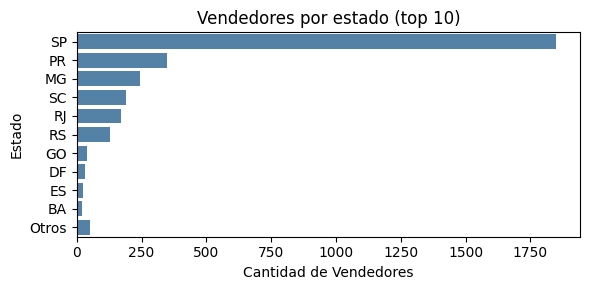

In [118]:
state_counts = sellers['seller_state'].value_counts()
top10        = state_counts.nlargest(10)
serie_plot   = pd.concat([top10,
                         pd.Series({'Otros': state_counts.sum() - top10.sum()})]
                       ).sort_values(ascending=False)

orden = list(top10.index) + ['Otros']
serie_plot = serie_plot.reindex(orden)

plt.figure(figsize=(6, 3))
sns.barplot(x=serie_plot.values, y=serie_plot.index, color='steelblue')
plt.title('Vendedores por estado (top 10)')
plt.xlabel('Cantidad de Vendedores') ; plt.ylabel('Estado')
plt.tight_layout() ; plt.show()

Y por ciudades?

In [119]:
sellers.groupby(['seller_state','seller_city']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=[False])

seller_state       seller_city  counts
590           SP         sao paulo     694
166           PR          curitiba     124
238           RJ    rio de janeiro      93
57            MG    belo horizonte      66
555           SP    ribeirao preto      52
..           ...               ...     ...
7             BA          guanambi       1
6             BA  feira de santana       1
5             BA         eunapolis       1
4             BA        barro alto       1
3             BA             bahia       1

[636 rows x 3 columns]

Un tercio (37 %) de los vendedores del estado de SP son también de la ciudad de Sao Paulo.

Normalizamos nombres de ciudades y pasamos a minúscula:

In [120]:
sellers['seller_city'] = sellers['seller_city'].apply(lambda x: unidecode(x).lower())

Volvamos a ver la distribución por estado y ciudad:

In [121]:
sellers.groupby(['seller_state','seller_city']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=[False])

seller_state                seller_city  counts
589           SP                  sao paulo     695
166           PR                   curitiba     124
238           RJ             rio de janeiro      93
57            MG             belo horizonte      66
555           SP             ribeirao preto      52
..           ...                        ...     ...
597           SP              sao sebastiao       1
598           SP  sao sebastiao da grama/sp       1
599           SP                sao vicente       1
1             AM                     manaus       1
617           SP                     taruma       1

[634 rows x 3 columns]

Apareció un "sao paulo" más!

Esto nos llama la atención de que las ciudades puedan estar escritas de diferentes maneras. Lo tendremos en cuenta para más adelante, tanto en el dataset de sellers como de customers.

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

In [122]:
# sellers_limpio_datatypes = sellers.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/sellers_limpio_datatypes.txt', "w") as file:
#     json.dump(sellers_limpio_datatypes, file, indent=4)
# sellers.to_csv('./bbdd_limpia/sellers_limpio.csv', index=False)

---
---
### PRODUCT_CATEGORY_NAMES (71 filas)

Este dataframe es un diccionario ingles-portugués para las categorías de productos. Lo utilizaremos para traducir las categorías de productos a inglés.

 No se necesita limpieza de este dataset.

In [123]:
# profile_product_category_name.to_notebook_iframe()

In [124]:
product_category_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [125]:
product_category_name

product_category_name product_category_name_english
0                    beleza_saude                 health_beauty
1          informatica_acessorios         computers_accessories
2                      automotivo                          auto
3                 cama_mesa_banho                bed_bath_table
4                moveis_decoracao               furniture_decor
..                            ...                           ...
66                         flores                       flowers
67             artes_e_artesanato         arts_and_craftmanship
68                fraldas_higiene           diapers_and_hygiene
69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70             seguros_e_servicos         security_and_services

[71 rows x 2 columns]

---
---
### PRODUCTS (32951 filas)

<u>Variables:</u>

*   `product_id`: Identificador del producto
*   `product_category_name`: Categoría del producto.
    * Son 73 categorías (en `product_category_name` eran 71!).
    * Tiene 610 missings
*   `product_name_lenght`: Longitud del nombre del producto.
    * Tiene 610 missings
*   `product_description_lenght`: Longitud de la descripción del producto.
    * Tiene 610 missings
    * Hay descripciones de hasta casi 4000 carácteres. Parece mucho.
    * Habría que pensar si podemos decir algo a partir de esta variable junto con `product_name_lenght`. Length está mal escrito acá.
*   `product_photos_qty`: Cantidad de fotos en la publicación del producto.
    * Tiene 610 missings
*   `product_weight_g`: Peso en gramos del producto.
    * Tiene 2 missings
*   `product_length_cm`: Longitud del producto en centímetros.
    * Tiene 2 missings
*   `product_height_cm`: Altura del producto en centímetros.
    * Tiene 2 missings
*   `product_width_cm`: Ancho del producto en centímetros.
    * Tiene 2 missings
    * `length`, `width`, `height` y `weight` están correlacionados.

In [126]:
# profile_products.to_notebook_iframe()

In [127]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   product_id                  32951 non-null  object
 1   product_category_name       32341 non-null  object
 2   product_name_lenght         32341 non-null  Int64 
 3   product_description_lenght  32341 non-null  Int64 
 4   product_photos_qty          32341 non-null  Int64 
 5   product_weight_g            32949 non-null  Int64 
 6   product_length_cm           32949 non-null  Int64 
 7   product_height_cm           32949 non-null  Int64 
 8   product_width_cm            32949 non-null  Int64 
dtypes: Int64(7), object(2)
memory usage: 2.5+ MB


Traduzcamos `product_category_name` a inglés usando el dataframe correspondiente

In [128]:
mapping_dict = dict(zip(product_category_name['product_category_name'], product_category_name['product_category_name_english']))
products['product_category_name'] = products['product_category_name'].replace(mapping_dict)

La traducción es para 71 productos. Veamos cuales quedaron sin reemplazar:

In [129]:
productos_no_traducidos = products[~products['product_category_name'].isin(product_category_name['product_category_name_english'])]

In [131]:
productos_no_traducidos['product_category_name'].value_counts().head()

product_category_name
portateis_cozinha_e_preparadores_de_alimentos    10
pc_gamer                                          3
Name: count, dtype: int64

Entonces sólo falta traducir "portateis_cozinha_e_preparadores_de_alimentos" ("pc_gamer" ya está).

In [132]:
products['product_category_name'] = products['product_category_name'].replace({'portateis_cozinha_e_preparadores_de_alimentos':'portable_kitchen_and_food_preparation'})

In [133]:
products['product_category_name'].nunique()

73

Chequeamos:

In [134]:
products[~products['product_category_name'].isin(product_category_name['product_category_name_english'])]['product_category_name'].value_counts().head()

product_category_name
portable_kitchen_and_food_preparation    10
pc_gamer                                  3
Name: count, dtype: int64

Entonces, las 73 categorías están traducidas.

Falta decidir que hacer con las cateogrías cuyo valor es "NaN".

In [135]:
products.groupby('product_category_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(20)
# products['product_category_name'].value_counts()

product_category_name  counts
7                    bed_bath_table    3029
67                   sports_leisure    2867
39                  furniture_decor    2657
43                    health_beauty    2444
49                       housewares    2335
5                              auto    1900
15            computers_accessories    1639
71                             toys    1411
72                    watches_gifts    1329
70                        telephony    1134
6                              baby     919
60                        perfumery     868
68                       stationery     849
28         fashion_bags_accessories     849
20                       cool_stuff     789
42                     garden_tools     753
61                         pet_shop     719
26                      electronics     517
17  construction_tools_construction     400
44                  home_appliances     370

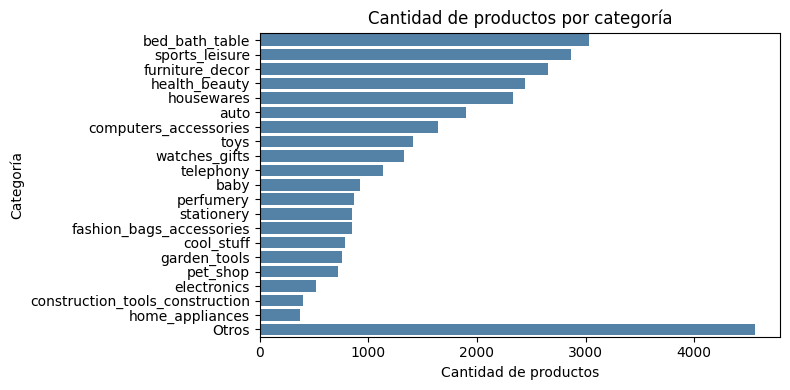

In [138]:
category_counts = products['product_category_name'].value_counts()
top20        = category_counts.nlargest(20)
serie_plot  = pd.concat([top20,
                         pd.Series({'Otros': category_counts.sum() - top20.sum()})]
                       ).sort_values(ascending=False)

orden = list(top20.index) + ['Otros']
serie_plot = serie_plot.reindex(orden)

plt.figure(figsize=(8, 4))
sns.barplot(x=serie_plot.values, y=serie_plot.index, color='steelblue')
plt.title('Cantidad de productos por categoría')
plt.xlabel('Cantidad de productos') ; plt.ylabel('Categoría')
plt.tight_layout() ; plt.show()

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Exploremos los valores missings

In [139]:
productos_category_nan = products[products['product_category_name'].isna()]
productos_category_nan.shape

(610, 9)

In [141]:
productos_category_nan.head()

product_id product_category_name  \
105  a41e356c76fab66334f36de622ecbd3a                   NaN   
128  d8dee61c2034d6d075997acef1870e9b                   NaN   
145  56139431d72cd51f19eb9f7dae4d1617                   NaN   
154  46b48281eb6d663ced748f324108c733                   NaN   
197  5fb61f482620cb672f5e586bb132eae9                   NaN   

     product_name_lenght  product_description_lenght  product_photos_qty  \
105                 <NA>                        <NA>                <NA>   
128                 <NA>                        <NA>                <NA>   
145                 <NA>                        <NA>                <NA>   
154                 <NA>                        <NA>                <NA>   
197                 <NA>                        <NA>                <NA>   

     product_weight_g  product_length_cm  product_height_cm  product_width_cm  
105               650                 17                 14                12  
128               300                 16                  7                20  
145               200                 20                 20                20  
154             18500                 41                 30                41  
197               300                 35                  7                12

Chequeamos si los 610 nan de la variables descriptivas son estas mismas filas:

In [145]:
productos_category_nan.count()

product_id                    610
product_category_name           0
product_name_lenght             0
product_description_lenght      0
product_photos_qty              0
product_weight_g              609
product_length_cm             609
product_height_cm             609
product_width_cm              609
dtype: int64

Lo son. Veamos entonces en qué órdenes aparecen, qué tanto los han comprado.

In [146]:
aux_order_items = order_items[order_items['product_id'].isin(productos_category_nan['product_id'])]
aux_order_items

order_id  order_item_id  \
123     0046e1d57f4c07c8c92ab26be8c3dfc0              1   
125     00482f2670787292280e0a8153d82467              1   
132     004f5d8f238e8908e6864b874eda3391              1   
142     0057199db02d1a5ef41bacbf41f8f63b              1   
171     006cb7cafc99b29548d4f412c7f9f493              1   
...                                  ...            ...   
112306  ff24fec69b7f3d30f9dc1ab3aee7c179              1   
112333  ff3024474be86400847879103757d1fd              1   
112350  ff3a45ee744a7c1f8096d2e72c1a23e4              1   
112438  ff7b636282b98e0aa524264b295ed928              1   
112501  ffa5e4c604dea4f0a59d19cc2322ac19              2   

                              product_id                         seller_id  \
123     ff6caf9340512b8bf6d2a2a6df032cfa  38e6dada03429a47197d5d584d793b41   
125     a9c404971d1a5b1cbc2e4070e02731fd  702835e4b785b67a084280efca355756   
132     5a848e4ab52fd5445cdc07aab1c40e48  c826c40d7b19f62a09e2d7c5e7295ee2   
142     41eee23c25f7a574dfaf8d5c151dbb12  e5a3438891c0bfdb9394643f95273d8e   
171     e10758160da97891c2fdcbc35f0f031d  323ce52b5b81df2cd804b017b7f09aa7   
...                                  ...                               ...   
112306  5a848e4ab52fd5445cdc07aab1c40e48  c826c40d7b19f62a09e2d7c5e7295ee2   
112333  f9b1795281ce51b1cf39ef6d101ae8ab  3771c85bac139d2344864ede5d9341e3   
112350  b61d1388a17e3f547d2bc218df02335b  07017df32dc5f2f1d2801e579548d620   
112438  431df35e52c10451171d8037482eeb43  6cd68b3ed6d59aaa9fece558ad360c0a   
112501  bd421826916d3e1d445cb860cea3c0fb  59cd88080b93f3c18508673122d26169   

       shipping_limit_date   price  freight_value  
123    2017-10-02 15:49:17    7.79           7.78  
125    2017-02-17 16:18:07    7.60          10.96  
132    2018-03-06 09:29:25  122.99          15.61  
142    2018-01-25 09:07:51   20.30          16.79  
171    2018-02-22 13:35:28   56.00          14.14  
...                    ...     ...            ...  
112306 2018-02-01 02:40:12  122.99          15.61  
112333 2017-11-21 03:55:39   39.90           9.94  
112350 2017-05-10 10:15:19  139.00          21.42  
112438 2018-02-22 15:35:35   49.90          15.11  
112501 2017-12-11 08:41:20   29.99          15.10  

[1603 rows x 7 columns]

In [147]:
aux_order_items['order_id'].nunique()

1451

In [148]:
aux_order_items['product_id'].nunique()

610

Es decir que todos esos 610 productos han sido comprados, por lo menos una vez.

In [149]:
aux_orders = orders[orders['order_id'].isin(aux_order_items['order_id'])]
aux_orders

order_id                       customer_id  \
6      136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
107    bfe42c22ecbf90bc9f35cf591270b6a7  803ac05904124294f8767894d6da532b   
180    58ac1947c1a9067b9f416cba6d844a3f  ee8e1d37f563ecc11cc4dcb4dfd794c2   
228    e22b71f6e4a481445ec4527cb4c405f7  1faf89c8f142db3fca6cf314c51a37b6   
263    a094215e786240fcfefb83d18036a1cd  86acfb656743da0c113d176832c9d535   
...                                 ...                               ...   
99069  1a10e938a1c7d8e5eecc3380f71ca76b  8a81607347c25d881d995d94de6ad824   
99215  e33865519137f5737444109ae8438633  64b086bdcc54458af3ea3bd838db54a5   
99222  f0dd9af88d8ef5a8e4670fbbedaf19c4  30ddb50bd22ee927ebe308ea3da60735   
99228  272874573723eec18f23c0471927d778  48e080c8001e92ebea2b64e474f91a60   
99245  dff2b9b8d7cfc595836945e1443789c3  2436fb2666a65fbacae82532e797cabf   

      order_status order_purchase_timestamp   order_approved_at  \
6         invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   
107      delivered      2018-01-27 22:04:34 2018-01-27 22:16:18   
180      delivered      2017-09-13 09:18:50 2017-09-13 13:45:43   
228      delivered      2017-04-22 13:48:18 2017-04-22 14:01:13   
263      delivered      2018-02-08 18:56:45 2018-02-08 19:32:18   
...            ...                      ...                 ...   
99069    delivered      2018-07-25 08:58:35 2018-07-26 03:10:20   
99215    delivered      2018-05-28 00:44:06 2018-05-29 03:31:17   
99222    delivered      2017-09-02 20:38:29 2017-09-05 04:24:12   
99228    delivered      2017-12-20 23:10:33 2017-12-20 23:29:37   
99245    delivered      2018-07-16 12:59:02 2018-07-17 04:21:00   

      order_delivered_carrier_date order_delivered_customer_date  \
6                              NaT                           NaT   
107            2018-02-03 03:56:00           2018-02-09 20:16:40   
180            2017-09-14 21:20:03           2017-09-21 21:16:17   
228            2017-04-24 19:08:53           2017-05-02 15:45:27   
263            2018-02-09 21:41:54           2018-02-19 13:28:50   
...                            ...                           ...   
99069          2018-07-27 11:32:00           2018-08-01 19:28:20   
99215          2018-05-30 13:13:00           2018-06-01 22:25:39   
99222          2017-09-14 23:13:41           2017-09-15 14:59:50   
99228          2017-12-21 21:49:35           2017-12-26 22:29:32   
99245          2018-07-17 15:08:00           2018-07-20 20:41:32   

      order_estimated_delivery_date  
6                        2017-05-09  
107                      2018-02-26  
180                      2017-09-25  
228                      2017-05-11  
263                      2018-02-22  
...                             ...  
99069                    2018-08-10  
99215                    2018-06-20  
99222                    2017-09-19  
99228                    2018-01-09  
99245                    2018-08-07  

[1451 rows x 8 columns]

In [150]:
aux_orders['order_status'].value_counts()

order_status
delivered     1392
shipped         24
canceled        14
processing      13
invoiced         8
Name: count, dtype: int64

Las 59 órdenes que no son "delivered" no estarán en el dataset final.

In [151]:
aux_payments = order_payments[order_payments['order_id'].isin(aux_orders['order_id'])]
aux_payments

order_id  payment_sequential payment_type  \
100     96de2b7f7f3c401fbee3eef068376da6                   1       boleto   
127     f51e3c7f79d1e2c076acbb6af1588b95                   1  credit_card   
203     52636dd3c039f62169b0eb724af63047                   1  credit_card   
262     7cb79316d2abe37e16ec83a07afb2895                   1  credit_card   
694     972c2e78e9af23a750a48184aadfca4d                   1  credit_card   
...                                  ...                 ...          ...   
103747  cf101c3abd3c061ca9f78c1bbb1125af                   3      voucher   
103772  6eb2780615aa0cfbaaef6c8d0aec411a                   1  credit_card   
103776  0e631eca89e976f885d1ef7f7a4a4698                   1  credit_card   
103808  312384a598132f165ae6f58bc210f8fb                   1       boleto   
103826  1ad1ca4550bd6dbd299d8538a86e5400                   1  credit_card   

        payment_installments  payment_value  
100                        1          32.15  
127                        1         130.22  
203                        2          77.77  
262                        1          13.55  
694                        3          51.09  
...                      ...            ...  
103747                     1           8.46  
103772                     7         158.30  
103776                     1         108.89  
103808                     1          45.00  
103826                     1          43.05  

[1543 rows x 5 columns]

No encontramos nuevos argumentos para deshacernos de estos datos, solamente el NaN en `product_category_name` sumado a que no son muchos productos ni órdenes de compra en relación al total. Por ahora los vamos a mantener, recordando en el futuro que hay 610 productos que no tienen categoría.

¿Que hay de los 2 missing en las otras variables? (las de propiedades físicas de los productos)

In [152]:
products[products['product_length_cm'].isna()]

product_id product_category_name  \
8578   09ff539a621711667c43eba6a3bd8466                  baby   
18851  5eb564652db742ff8f28759cd8d2652a                   NaN   

       product_name_lenght  product_description_lenght  product_photos_qty  \
8578                    60                         865                   3   
18851                 <NA>                        <NA>                <NA>   

       product_weight_g  product_length_cm  product_height_cm  \
8578               <NA>               <NA>               <NA>   
18851              <NA>               <NA>               <NA>   

       product_width_cm  
8578               <NA>  
18851              <NA>

Vemos entonces que hay un producto que tiene NaN en todas las categorías excepto el `product_id`, es el producto `product_id=5eb564652db742ff8f28759cd8d2652a`.

Exploremos un poco en qué órdenes, cuántos items y el pago de este producto:

In [153]:
items_producto_todo_nan = order_items[order_items['product_id']=='5eb564652db742ff8f28759cd8d2652a']
items_producto_todo_nan.sort_values(by='order_id')

order_id  order_item_id  \
7098    101157d4fae1c9fb74a00a5dee265c25              1   
9233    1521c6bb7b1028154c8c67cf80fa809f              1   
28715   415cfaaaa8cea49f934470548797fed1              1   
28716   415cfaaaa8cea49f934470548797fed1              2   
39299   595316a07cd3dea9db7adfcc7e247ae7              1   
48424   6e150190fbe04c642a9cf0b80d83ee16              1   
48980   6f497c40431d5fb0cfbd6c943dd29215              1   
71134   a2456e7f02197951664897a94c87242d              1   
73556   a7a43f469c0d7bdb0a23a82db125aefa              1   
82767   bbfc7badbed2f1828e22b6d629201bd4              1   
84199   bf49f84a0580ef6751e13357776b7ed9              1   
85060   c1424efcde3c9e9febd9e1761667789e              1   
93346   d38dcb503cd4ddc6ce7702552918bd8f              1   
93347   d38dcb503cd4ddc6ce7702552918bd8f              2   
97847   ddf16d77e858a32f36e10c289a28ef61              1   
100495  e3daea0200104991cb979c2fcc509ae7              1   
103715  eb855beb3ac99461f7a076b4c3652472              1   

                              product_id                         seller_id  \
7098    5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
9233    5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
28715   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
28716   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
39299   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
48424   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
48980   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
71134   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
73556   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
82767   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
84199   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
85060   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
93346   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
93347   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
97847   5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
100495  5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   
103715  5eb564652db742ff8f28759cd8d2652a  4e922959ae960d389249c378d1c939f5   

       shipping_limit_date  price  freight_value  
7098   2017-04-11 08:02:26   29.0          14.52  
9233   2017-04-07 10:10:16   29.0          16.05  
28715  2017-04-07 10:35:19   29.0          14.52  
28716  2017-04-07 10:35:19   29.0          14.52  
39299  2017-08-18 04:26:04   39.0           9.27  
48424  2017-06-30 16:45:14   39.0          16.79  
48980  2017-04-11 05:55:32   29.0          10.96  
71134  2017-04-06 11:50:09   29.0          24.84  
73556  2017-08-28 13:15:11   39.0          15.10  
82767  2017-07-18 04:04:10   39.0          11.85  
84199  2017-07-09 21:35:18   39.0          15.10  
85060  2017-04-14 02:45:36   29.0          14.52  
93346  2017-06-09 17:55:13   39.0          15.10  
93347  2017-06-09 17:55:13   39.0          15.10  
97847  2017-05-02 10:50:08   29.0          14.52  
100495 2017-04-06 14:22:36   29.0          10.96  
103715 2017-03-30 16:03:46   29.0          14.52

In [154]:
orders[orders['order_id'].isin(items_producto_todo_nan['order_id'])].sort_values(by='order_id')

order_id                       customer_id  \
41192  101157d4fae1c9fb74a00a5dee265c25  f72b2f8d9295ef93fd40a4c49f67a42b   
28142  1521c6bb7b1028154c8c67cf80fa809f  ca29b2bf57243228e98eab2dab805ae9   
35759  415cfaaaa8cea49f934470548797fed1  a8dff6357fea30071032ff2091d16430   
72698  595316a07cd3dea9db7adfcc7e247ae7  696e8f940eeee6b009d1539b59e47366   
7367   6e150190fbe04c642a9cf0b80d83ee16  135a42a465867ff932f1222f71a3efb2   
74479  6f497c40431d5fb0cfbd6c943dd29215  5beb36d1757aa17a044222a7d79b9820   
89298  a2456e7f02197951664897a94c87242d  7317f41f2cf650174af819cdb68284f0   
70083  a7a43f469c0d7bdb0a23a82db125aefa  d7c95dc1ece116c14188092ead3d0951   
54986  bbfc7badbed2f1828e22b6d629201bd4  f25f442c0ff3a9401eed8ed3a686f362   
45718  bf49f84a0580ef6751e13357776b7ed9  e7f41abe62db82cffe5c8f6138f18fb2   
73179  c1424efcde3c9e9febd9e1761667789e  8a80133b8ace6b21415367a131a75a26   
7771   d38dcb503cd4ddc6ce7702552918bd8f  b0a3a02fe893d9a9385a98db1348244b   
18899  ddf16d77e858a32f36e10c289a28ef61  84cc013dd1790fdafb0fa598695cf3c3   
31736  e3daea0200104991cb979c2fcc509ae7  4730251e8934a542a009d77dfd027375   
68045  eb855beb3ac99461f7a076b4c3652472  c91289ce43149a8ea5560d446f1d1dd2   

      order_status order_purchase_timestamp   order_approved_at  \
41192    delivered      2017-04-03 07:54:34 2017-04-04 08:02:26   
28142    delivered      2017-04-02 10:00:43 2017-04-02 10:10:16   
35759    delivered      2017-04-02 10:25:38 2017-04-02 10:35:19   
72698    delivered      2017-08-09 23:50:08 2017-08-11 04:26:04   
7367     delivered      2017-06-24 16:33:35 2017-06-24 16:45:14   
74479    delivered      2017-04-01 14:26:15 2017-04-04 05:55:32   
89298    delivered      2017-03-30 11:39:20 2017-03-30 11:50:09   
70083    delivered      2017-08-21 13:00:05 2017-08-21 13:15:11   
54986    delivered      2017-07-09 10:35:08 2017-07-11 04:04:10   
45718    delivered      2017-07-02 21:25:56 2017-07-02 21:35:18   
73179    delivered      2017-04-07 14:51:01 2017-04-08 02:45:36   
7771     delivered      2017-06-04 17:44:18 2017-06-04 17:55:13   
18899    delivered      2017-04-24 10:36:24 2017-04-24 10:50:08   
31736    delivered      2017-03-30 14:07:44 2017-03-30 14:22:36   
68045    delivered      2017-03-23 15:51:16 2017-03-23 16:03:46   

      order_delivered_carrier_date order_delivered_customer_date  \
41192          2017-04-12 08:58:13           2017-04-13 21:08:08   
28142          2017-04-04 16:19:55           2017-04-18 13:53:58   
35759          2017-04-13 04:37:45           2017-04-29 10:14:19   
72698          2017-08-14 14:46:16           2017-08-17 19:32:48   
7367           2017-06-29 16:08:40           2017-07-07 18:35:52   
74479          2017-04-04 16:19:49           2017-04-06 14:53:18   
89298          2017-03-30 16:45:30           2017-05-04 14:32:43   
70083          2017-08-22 20:43:40           2017-08-28 19:07:55   
54986          2017-07-11 17:20:00           2017-07-18 17:59:36   
45718          2017-07-04 15:35:12           2017-07-11 16:47:17   
73179          2017-04-11 13:15:21           2017-04-17 19:06:00   
7771           2017-06-05 16:13:33           2017-06-14 16:38:11   
18899          2017-04-25 10:59:46           2017-05-05 12:42:39   
31736          2017-03-31 22:06:32           2017-04-07 14:43:38   
68045          2017-03-24 13:38:18           2017-03-30 13:41:24   

      order_estimated_delivery_date  
41192                    2017-05-02  
28142                    2017-05-04  
35759                    2017-05-02  
72698                    2017-08-25  
7367                     2017-07-31  
74479                    2017-04-27  
89298                    2017-05-10  
70083                    2017-09-18  
54986                    2017-08-02  
45718                    2017-07-28  
73179                    2017-05-08  
7771                     2017-07-05  
18899                    2017-05-18  
31736                    2017-04-25  
68045                    2017-04-19

In [155]:
order_payments[order_payments['order_id'].isin(items_producto_todo_nan['order_id'])].sort_values(by='order_id')

order_id  payment_sequential payment_type  \
45931  101157d4fae1c9fb74a00a5dee265c25                   1  credit_card   
95978  1521c6bb7b1028154c8c67cf80fa809f                   1  credit_card   
37011  415cfaaaa8cea49f934470548797fed1                   1  credit_card   
93295  595316a07cd3dea9db7adfcc7e247ae7                   1       boleto   
33157  6e150190fbe04c642a9cf0b80d83ee16                   1  credit_card   
67031  6f497c40431d5fb0cfbd6c943dd29215                   1       boleto   
49657  a2456e7f02197951664897a94c87242d                   1  credit_card   
26718  a7a43f469c0d7bdb0a23a82db125aefa                   1  credit_card   
57808  bbfc7badbed2f1828e22b6d629201bd4                   1       boleto   
22164  bf49f84a0580ef6751e13357776b7ed9                   1  credit_card   
10959  c1424efcde3c9e9febd9e1761667789e                   1       boleto   
18290  d38dcb503cd4ddc6ce7702552918bd8f                   1  credit_card   
30013  ddf16d77e858a32f36e10c289a28ef61                   1  credit_card   
21594  ddf16d77e858a32f36e10c289a28ef61                   2      voucher   
7955   ddf16d77e858a32f36e10c289a28ef61                   3      voucher   
12752  e3daea0200104991cb979c2fcc509ae7                   1  credit_card   
33243  eb855beb3ac99461f7a076b4c3652472                   1  credit_card   

       payment_installments  payment_value  
45931                     1          43.52  
95978                     4          45.05  
37011                     1          87.04  
93295                     1          48.27  
33157                     2          55.79  
67031                     1          39.96  
49657                     1          53.84  
26718                     3          54.10  
57808                     1          50.85  
22164                     6          61.14  
10959                     1          43.52  
18290                     4         108.20  
30013                     1           3.52  
21594                     1          20.00  
7955                      1          20.00  
12752                     3          39.96  
33243                     4          43.52

Si bien tiene datos útiles, vamos a descartar los dos productos que no tienen datos de características físicas, ya que peso o volumen son cantidades que pensamos utilizar para la estimación de fecha de entrega.

In [156]:
products_limpio = products.dropna(subset=['product_weight_g','product_length_cm','product_height_cm','product_width_cm'])

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

¿Podremos decir algo que relacione el peso y las medidas del producto?

In [157]:
products_limpio[['product_weight_g',
          'product_length_cm',
          'product_height_cm',
          'product_width_cm'
          ]].corr().style.background_gradient(cmap='coolwarm')

**PARA TENER EN CUENTA:**

¿Podemos usar las medidas y peso para armar una variable nueva que nos permita relacionarla con el precio del flete en función de distancia entre `customer` y `seller`?

Encontramos que existe el concepto de "peso volumétrico" o "peso tasable", cuyo valor es el volumen dividido algún factor predeterminado. Luego el valor de flete se calcula en función del mayor valor entre ambos pesos (real vs volumétrico).

Ver [link 1](https://support.sendcloud.com/hc/es/articles/360059644051-C%C3%B3mo-calcular-y-automatizar-el-peso-volum%C3%A9trico-de-tus-paquetes), y en particular para Olist [link 2](https://precocerto.helpscoutdocs.com/article/98-regra-de-frete-olist) y [link 3](https://ajuda.olist.com/kb/articles/loja/logistica/tabela-de-frete/como-funcionam-as-tabelas-de-frete-da-olist)




Por ahora, vamos a alcular el volumen en $cm^3$ de cada producto (y deshacernos de las medidas).

In [158]:
products_limpio['product_vol_cm3'] = products_limpio['product_length_cm'].mul(products_limpio['product_height_cm']).mul(products_limpio['product_width_cm'])

In [159]:
products_limpio.drop(columns=['product_length_cm','product_height_cm','product_width_cm'], inplace=True)

In [160]:
products_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32949 entries, 0 to 32950
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   product_id                  32949 non-null  object
 1   product_category_name       32340 non-null  object
 2   product_name_lenght         32340 non-null  Int64 
 3   product_description_lenght  32340 non-null  Int64 
 4   product_photos_qty          32340 non-null  Int64 
 5   product_weight_g            32949 non-null  Int64 
 6   product_vol_cm3             32949 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 2.2+ MB


In [161]:
products_limpio

product_id      product_category_name  \
0      1e9e8ef04dbcff4541ed26657ea517e5                  perfumery   
1      3aa071139cb16b67ca9e5dea641aaa2f                        art   
2      96bd76ec8810374ed1b65e291975717f             sports_leisure   
3      cef67bcfe19066a932b7673e239eb23d                       baby   
4      9dc1a7de274444849c219cff195d0b71                 housewares   
...                                 ...                        ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0            furniture_decor   
32947  bf4538d88321d0fd4412a93c974510e6  construction_tools_lights   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c             bed_bath_table   
32949  83808703fc0706a22e264b9d75f04a2e      computers_accessories   
32950  106392145fca363410d287a815be6de4             bed_bath_table   

       product_name_lenght  product_description_lenght  product_photos_qty  \
0                       40                         287                   1   
1                       44                         276                   1   
2                       46                         250                   1   
3                       27                         261                   1   
4                       37                         402                   4   
...                    ...                         ...                 ...   
32946                   45                          67                   2   
32947                   41                         971                   1   
32948                   50                         799                   1   
32949                   60                         156                   2   
32950                   58                         309                   1   

       product_weight_g  product_vol_cm3  
0                   225             2240  
1                  1000            10800  
2                   154             2430  
3                   371             2704  
4                   625             4420  
...                 ...              ...  
32946             12300            64000  
32947              1700             4864  
32948              1400             5103  
32949               700             8060  
32950              2083              168  

[32949 rows x 7 columns]

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

In [ ]:
# products_limpio_datatypes = products_limpio.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/products_limpio_datatypes.txt', "w") as file:
#     json.dump(products_limpio_datatypes, file, indent=4)
# products_limpio.to_csv('./bbdd_limpia/products_limpio.csv', index=False)

---
---
### ORDER_REVIEWS (99224 filas)

<u>Variables:</u>

*   `review_id`: Identificador del review.
    * Hay duplicados, la mayoría 2 veces, algunos 3 veces.
    * Estos reviews duplicados cada uno apunta a diferentes `order_id`, lo cual resulta extraño. De todas maneras, tienen iguales `review_comment_title` y `review_comment_message`. **Veremos más adelante qué hacer con esto, en principio parece ser un problema de guardado de datos.**
*   `order_id`: órden sobre la cual se emitió el review.
*   `review_score`: Score de satisfacción, 1 a 5.
    * 5 estrellas el 57.8%, 4 estrellas el 19.3%, 3 estrellas el 11.5%. 2 estrellas el 8.2%, 1 estrella el 3.2%.
*   `review_comment_title`: Título del review
    * La mayoría no tiene título (88.3%)
*   `review_comment_message`: Cuerpo del mensaje del review.
    * Mas de la mitad no tiene mensaje (58.7%)
*   `review_creation_date`: Fecha cuando la encuesta de satisfacción fue enviada al comprador.
    * Notemos que el horario de ésta fecha es siempre "00:00:00".
*   `review_answer_timestamp`: Instante en que la encuesta de satisfacción fue respondida/completada por el comprador.
    * No tiene missing. ¿Esto nos dice que todos los customers emitieron reviews? NO, quiere decir que esta tabla está armada con reviews emitidos (pensándolo bien, resulta obvio).
    * La diferencia entre `review_creation_date` y `review_answer_timestamp` podría ayudar a decirnos algo sobre el sentimiento de los compradores.

In [163]:
# profile_order_reviews.to_notebook_iframe()

In [164]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  Int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), object(4)
memory usage: 5.4+ MB


In [165]:
ids = order_reviews["review_id"]
order_reviews_duplicados = order_reviews[ids.isin(ids[ids.duplicated()])]
order_reviews_duplicados.sort_values(by='review_id')

review_id                          order_id  \
46678  00130cbe1f9d422698c812ed8ded1919  dfcdfc43867d1c1381bfaf62d6b9c195   
29841  00130cbe1f9d422698c812ed8ded1919  04a28263e085d399c97ae49e0b477efa   
90677  0115633a9c298b6a98bcbe4eee75345f  78a4201f58af3463bdab842eea4bc801   
63193  0115633a9c298b6a98bcbe4eee75345f  0c9850b2c179c1ef60d2855e2751d1fa   
92876  0174caf0ee5964646040cd94e15ac95e  f93a732712407c02dce5dd5088d0f47b   
...                                 ...                               ...   
31120  fe5c833752953fed3209646f1f63b53c  4863e15fa53273cc7219c58f5ffda4fb   
7870   ff2fc9e68f8aabfbe18d710b83aabd30  2da58e0a7dcfa4ce1e00fad9d03ca3b5   
82521  ff2fc9e68f8aabfbe18d710b83aabd30  1078d496cc6ab9a8e6f2be77abf5091b   
73951  ffb8cff872a625632ac983eb1f88843c  c44883fc2529b4aa03ca90e7e09d95b6   
1985   ffb8cff872a625632ac983eb1f88843c  c88b1d1b157a9999ce368f218a407141   

       review_score review_comment_title  \
46678             1                  NaN   
29841             1                  NaN   
90677             5                  NaN   
63193             5                  NaN   
92876             1                  NaN   
...             ...                  ...   
31120             1                  NaN   
7870              2                  NaN   
82521             2                  NaN   
73951             3                  NaN   
1985              3                  NaN   

                                  review_comment_message review_creation_date  \
46678  O cartucho "original HP" 60XL não é reconhecid...           2018-03-07   
29841  O cartucho "original HP" 60XL não é reconhecid...           2018-03-07   
90677                                                NaN           2017-09-21   
63193                                                NaN           2017-09-21   
92876  Produto entregue dentro de embalagem do fornec...           2018-03-07   
...                                                  ...                  ...   
31120  Comprei dois produtos e ambos, mesmo enviados ...           2018-02-28   
7870                                                 NaN           2018-03-17   
82521                                                NaN           2018-03-17   
73951                                                NaN           2017-07-22   
1985                                                 NaN           2017-07-22   

      review_answer_timestamp  
46678     2018-03-20 18:08:23  
29841     2018-03-20 18:08:23  
90677     2017-09-26 03:27:47  
63193     2017-09-26 03:27:47  
92876     2018-03-08 03:00:53  
...                       ...  
31120     2018-02-28 13:57:52  
7870      2018-03-19 11:44:15  
82521     2018-03-19 11:44:15  
73951     2017-07-26 13:41:07  
1985      2017-07-26 13:41:07  

[1603 rows x 7 columns]

Por lo que vemos aquí, los reviews duplicados pertencen a órdenes diferentes. Pero el "title" y "message" son los mismos. También parecen tener los mismos los timestamps.

Verifiquemos esto último

In [166]:
order_reviews_duplicados.groupby('review_id').agg({
    'review_creation_date': lambda x: x.nunique(),
    'review_answer_timestamp': lambda x: x.nunique(),
}).sum()


review_creation_date       789
review_answer_timestamp    789
dtype: int64

In [167]:
len(order_reviews_duplicados.groupby('review_id'))

789

Quiere decir que también los duplicados tienen igual `review_creation_date` y `review_answer_timestamp`.

**CONCLUSIÓN: Las reviews repetidas SOLAMENTE tienen diferentes `order_id`, el resto es todo igual.**

**¿Qué significa esto?** Exploremos algunos de los casos duplicados:

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Caso 1:

Tomamos la primer review duplicada

`review_id` = `00130cbe1f9d422698c812ed8ded1919`

In [168]:
ejemplo_1 = order_reviews_duplicados.loc[order_reviews_duplicados['review_id']=='00130cbe1f9d422698c812ed8ded1919']
ejemplo_1

review_id                          order_id  \
29841  00130cbe1f9d422698c812ed8ded1919  04a28263e085d399c97ae49e0b477efa   
46678  00130cbe1f9d422698c812ed8ded1919  dfcdfc43867d1c1381bfaf62d6b9c195   

       review_score review_comment_title  \
29841             1                  NaN   
46678             1                  NaN   

                                  review_comment_message review_creation_date  \
29841  O cartucho "original HP" 60XL não é reconhecid...           2018-03-07   
46678  O cartucho "original HP" 60XL não é reconhecid...           2018-03-07   

      review_answer_timestamp  
29841     2018-03-20 18:08:23  
46678     2018-03-20 18:08:23

Y veamos qué pasa con esas 2 órdenes en "orders", "order_items" y "order_payments"

In [169]:
ejemplo_1_orders = orders[orders['order_id'].isin(ejemplo_1['order_id'])]
ejemplo_1_orders

order_id                       customer_id  \
28241  04a28263e085d399c97ae49e0b477efa  fef2e5e63da9f3e1dd89e8e319468657   
74048  dfcdfc43867d1c1381bfaf62d6b9c195  a7026133ddbd2e86c83ecd4dfa4dbe01   

      order_status order_purchase_timestamp   order_approved_at  \
28241    delivered      2018-02-02 18:01:10 2018-02-02 18:31:27   
74048    delivered      2018-02-02 18:01:08 2018-02-02 18:31:17   

      order_delivered_carrier_date order_delivered_customer_date  \
28241          2018-02-21 02:38:29           2018-03-11 11:32:24   
74048          2018-02-05 23:46:29           2018-02-26 18:18:45   

      order_estimated_delivery_date  
28241                    2018-03-05  
74048                    2018-03-09

In [170]:
ejemplo_1_items = order_items[order_items['order_id'].isin(ejemplo_1['order_id'])]
ejemplo_1_items

order_id  order_item_id  \
2058   04a28263e085d399c97ae49e0b477efa              1   
98681  dfcdfc43867d1c1381bfaf62d6b9c195              1   

                             product_id                         seller_id  \
2058   3f14d740544f37ece8a9e7bc8349797e  6973a06f484aacf400ece213dbf3d946   
98681  36f60d45225e60c7da4558b070ce4b60  00fc707aaaad2d31347cf883cd2dfe10   

      shipping_limit_date  price  freight_value  
2058  2018-02-09 18:15:37  84.89          15.34  
98681 2018-02-14 18:15:36  89.15          25.90

In [171]:
ejemplo_1_payments = order_payments[order_payments['order_id'].isin(ejemplo_1['order_id'])]
ejemplo_1_payments

order_id  payment_sequential payment_type  \
10356  04a28263e085d399c97ae49e0b477efa                   1  credit_card   
26708  dfcdfc43867d1c1381bfaf62d6b9c195                   1  credit_card   

       payment_installments  payment_value  
10356                     3         100.23  
26708                     3         115.05

Y veamos también los sellers de esas dos compras:

In [172]:
ejemplo_1_sellers = sellers[sellers['seller_id'].isin(ejemplo_1_items['seller_id'])]
ejemplo_1_sellers

seller_id  seller_zip_code_prefix  \
1954  00fc707aaaad2d31347cf883cd2dfe10                   87025   
2084  6973a06f484aacf400ece213dbf3d946                   12230   

              seller_city seller_state  
1954              maringa           PR  
2084  sao jose dos campos           SP

No parecen tener nada en común, salvo que las compras fueron hechas casi al mismo tiempo (`order_purchase_timestamp`).

Lo más probable es que hayan sido hechas por el mismo usuario, verifiquemos eso:

In [173]:
ejemplo_1_customers = customers[customers['customer_id'].isin(ejemplo_1_orders['customer_id'])]
ejemplo_1_customers

customer_id                customer_unique_id  \
60938  a7026133ddbd2e86c83ecd4dfa4dbe01  f30856ad31d3e74253a3f4ccef670648   
62395  fef2e5e63da9f3e1dd89e8e319468657  f30856ad31d3e74253a3f4ccef670648   

       customer_zip_code_prefix customer_city customer_state  
60938                     71955      brasilia             DF  
62395                     71955      brasilia             DF

Concluimos que es un mismo customer, que creó mas o menos al mismo instante dos órdenes diferentes para comprar dos cosas diferentes de dos sellers diferentes (en dos estados diferentes).

* **¿Se debe esto a que agregó dos items diferentes a un mismo carrito?**

* **Si es así, ¿por qué el review de ambas compras es el mismo?**

* **¿Podría suceder que emitió review por uno de los items, pero el sistema de alguna manera genera 2 entradas en la tabla de Reviews?**

* **¿Cómo podemos saber a que órden es fiel el review?**

chequeamos las fechas del review y del envío:

In [174]:
ejemplo_1[['review_id','order_id','review_creation_date','review_answer_timestamp']]

review_id                          order_id  \
29841  00130cbe1f9d422698c812ed8ded1919  04a28263e085d399c97ae49e0b477efa   
46678  00130cbe1f9d422698c812ed8ded1919  dfcdfc43867d1c1381bfaf62d6b9c195   

      review_creation_date review_answer_timestamp  
29841           2018-03-07     2018-03-20 18:08:23  
46678           2018-03-07     2018-03-20 18:08:23

In [175]:
ejemplo_1_orders[['order_id','order_delivered_customer_date','order_estimated_delivery_date']]

order_id order_delivered_customer_date  \
28241  04a28263e085d399c97ae49e0b477efa           2018-03-11 11:32:24   
74048  dfcdfc43867d1c1381bfaf62d6b9c195           2018-02-26 18:18:45   

      order_estimated_delivery_date  
28241                    2018-03-05  
74048                    2018-03-09

Vemos que para este caso, la encuesta le fue enviada al comprador el 7/3/2018.

* El producto de la orden "04a2826..." no había llegado todavía, pero la fecha estimada de llegada ya había ocurrido (2 días antes).
* El producto de la orden "dfcdfc4..." ya había llegado (9 días antes), pero la fecha estimada era para 2 días después.

Podríamos conjeturar que el review pertenece al producto de la orden "04a2826...".

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Caso 2:

Tomamos la review duplicada

`review_id=0115633a9c298b6a98bcbe4eee75345f`

In [176]:
ejemplo_2 = order_reviews_duplicados.loc[order_reviews_duplicados['review_id']=='0115633a9c298b6a98bcbe4eee75345f']
ejemplo_2_orders = orders[orders['order_id'].isin(ejemplo_2['order_id'])]
ejemplo_2_items = order_items[order_items['order_id'].isin(ejemplo_2['order_id'])]
ejemplo_2_payments = order_payments[order_payments['order_id'].isin(ejemplo_2['order_id'])]
ejemplo_2_sellers = sellers[sellers['seller_id'].isin(ejemplo_2_items['seller_id'])]
ejemplo_2_customers = customers[customers['customer_id'].isin(ejemplo_2_orders['customer_id'])]
ejemplo_2[['review_id','order_id','review_creation_date','review_answer_timestamp']]

review_id                          order_id  \
63193  0115633a9c298b6a98bcbe4eee75345f  0c9850b2c179c1ef60d2855e2751d1fa   
90677  0115633a9c298b6a98bcbe4eee75345f  78a4201f58af3463bdab842eea4bc801   

      review_creation_date review_answer_timestamp  
63193           2017-09-21     2017-09-26 03:27:47  
90677           2017-09-21     2017-09-26 03:27:47

In [177]:
ejemplo_2_orders[['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']]

order_id                       customer_id  \
12100  78a4201f58af3463bdab842eea4bc801  d39c97549a412a82dacf30fe5f144cb0   
28715  0c9850b2c179c1ef60d2855e2751d1fa  3bb15be93abf3c2a684d163ba6faaa5b   

      order_purchase_timestamp order_delivered_customer_date  \
12100      2017-09-04 15:17:12           2017-09-20 22:24:03   
28715      2017-09-04 15:17:11           2017-09-18 19:43:06   

      order_estimated_delivery_date  
12100                    2017-10-03  
28715                    2017-09-29

In [178]:
ejemplo_2_customers

customer_id                customer_unique_id  \
5281   d39c97549a412a82dacf30fe5f144cb0  91ffaf5eb7f4bd6a48b07f3546fb7a99   
13902  3bb15be93abf3c2a684d163ba6faaa5b  91ffaf5eb7f4bd6a48b07f3546fb7a99   

       customer_zip_code_prefix customer_city customer_state  
5281                      65415       coroata             MA  
13902                     65415       coroata             MA

In [179]:
ejemplo_2_items

order_id  order_item_id  \
5583   0c9850b2c179c1ef60d2855e2751d1fa              1   
5584   0c9850b2c179c1ef60d2855e2751d1fa              2   
53019  78a4201f58af3463bdab842eea4bc801              1   

                             product_id                         seller_id  \
5583   7b5d8be0e04080e4c8ee6a7ec2f1f597  1025f0e2d44d7041d6cf58b6550e0bfa   
5584   7b5d8be0e04080e4c8ee6a7ec2f1f597  1025f0e2d44d7041d6cf58b6550e0bfa   
53019  7814c273ab16783d73a9863ebfa8b141  1025f0e2d44d7041d6cf58b6550e0bfa   

      shipping_limit_date  price  freight_value  
5583  2017-09-13 15:24:16   38.4          35.67  
5584  2017-09-13 15:24:16   38.4          35.67  
53019 2017-09-15 15:24:13  229.0          96.41

In [180]:
ejemplo_2_sellers

seller_id  seller_zip_code_prefix seller_city  \
2720  1025f0e2d44d7041d6cf58b6550e0bfa                    3204   sao paulo   

     seller_state  
2720           SP

Este ejemplo es un mismo comprador que compra dos productos diferentes (uno de ellos, compra dos unidades) a un mismo vendedor.

Vendedor y comprador están en estados diferentes.

La encuesta fue enviada al comprador el 21/09/2017.

* Los productos de la orden "0c9850b2c179c..." habían llegado 3 días antes, el 18. La fecha estimada de entrega era el 29/09/2017.
* El producto de la orden "78a4201f58af34..." había llegado 1 día antes, el 20. La fecha estimada de entrega era el 03/10/2017.

Podríamos conjeturar que el review pertenece al producto de la orden "78a4201f58af34..." (que además es el producto más caro).

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Caso 3:

Probemos con un review que se repite 3 veces, `review_id=2d6ac45f859465b5c185274a1c929637`

In [184]:
ejemplo_3 = order_reviews_duplicados.loc[order_reviews_duplicados['review_id']=='2d6ac45f859465b5c185274a1c929637']
ejemplo_3_orders = orders[orders['order_id'].isin(ejemplo_3['order_id'])]
ejemplo_3_items = order_items[order_items['order_id'].isin(ejemplo_3['order_id'])]
ejemplo_3_payments = order_payments[order_payments['order_id'].isin(ejemplo_3['order_id'])]
ejemplo_3_sellers = sellers[sellers['seller_id'].isin(ejemplo_3_items['seller_id'])]
ejemplo_3_customers = customers[customers['customer_id'].isin(ejemplo_3_orders['customer_id'])]

Parece que este usuario compró 3 de lo mismo:

In [185]:
ejemplo_3[['review_id','order_id','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp']]

review_id                          order_id  \
4779   2d6ac45f859465b5c185274a1c929637  ef66cc60de5221417b5fb81b1c42de85   
27666  2d6ac45f859465b5c185274a1c929637  41c284ffd871324eadf06fc989583619   
64510  2d6ac45f859465b5c185274a1c929637  8e17072ec97ce29f0e1f111e598b0c85   

      review_comment_title                             review_comment_message  \
4779                   NaN  Comprei 3 unidades do produto vieram 2 unidade...   
27666                  NaN  Comprei 3 unidades do produto vieram 2 unidade...   
64510                  NaN  Comprei 3 unidades do produto vieram 2 unidade...   

      review_creation_date review_answer_timestamp  
4779            2018-04-07     2018-04-07 21:13:05  
27666           2018-04-07     2018-04-07 21:13:05  
64510           2018-04-07     2018-04-07 21:13:05

Tienen el mismo order_purchase_timestamp:

In [186]:
ejemplo_3_orders[['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']]

order_id                       customer_id  \
3460   41c284ffd871324eadf06fc989583619  b2455d365185ab7c1da94e742e4976ad   
51063  ef66cc60de5221417b5fb81b1c42de85  226d59f9f4b98e228b689eea45d03a6d   
63380  8e17072ec97ce29f0e1f111e598b0c85  9e29cde4ddb42f9330bcf3c9bc23d177   

      order_purchase_timestamp order_delivered_customer_date  \
3460       2018-03-31 15:08:21           2018-04-13 19:58:36   
51063      2018-03-31 15:08:21           2018-04-06 19:06:35   
63380      2018-03-31 15:08:21           2018-04-06 17:38:34   

      order_estimated_delivery_date  
3460                     2018-05-04  
51063                    2018-05-04  
63380                    2018-05-04

Efectivamente, mismo producto del mismo seller:

In [187]:
ejemplo_3_items

order_id  order_item_id  \
28903   41c284ffd871324eadf06fc989583619              1   
62234   8e17072ec97ce29f0e1f111e598b0c85              1   
105390  ef66cc60de5221417b5fb81b1c42de85              1   

                              product_id                         seller_id  \
28903   ac20a9614b6db9e7289b85c4f4b6216a  d91fb3b7d041e83b64a00a3edfb37e4f   
62234   ac20a9614b6db9e7289b85c4f4b6216a  d91fb3b7d041e83b64a00a3edfb37e4f   
105390  ac20a9614b6db9e7289b85c4f4b6216a  d91fb3b7d041e83b64a00a3edfb37e4f   

       shipping_limit_date  price  freight_value  
28903  2018-04-05 15:50:12   40.0          19.32  
62234  2018-04-05 15:50:11   40.0          19.32  
105390 2018-04-05 15:50:13   40.0          19.32

In [188]:
ejemplo_3_sellers

seller_id  seller_zip_code_prefix   seller_city  \
1144  d91fb3b7d041e83b64a00a3edfb37e4f                   11704  praia grande   

     seller_state  
1144           SP

El customer es la misma persona:

In [189]:
ejemplo_3_customers

customer_id                customer_unique_id  \
1139   9e29cde4ddb42f9330bcf3c9bc23d177  66980c3775537536f77b434d74e520f5   
2811   226d59f9f4b98e228b689eea45d03a6d  66980c3775537536f77b434d74e520f5   
81546  b2455d365185ab7c1da94e742e4976ad  66980c3775537536f77b434d74e520f5   

       customer_zip_code_prefix   customer_city customer_state  
1139                      30290  belo horizonte             MG  
2811                      30290  belo horizonte             MG  
81546                     30290  belo horizonte             MG

Y parece que pagó las 3 órdenes de la misma manera:

In [190]:
ejemplo_3_payments

order_id  payment_sequential payment_type  \
33403   41c284ffd871324eadf06fc989583619                   1  credit_card   
85462   ef66cc60de5221417b5fb81b1c42de85                   1  credit_card   
101288  8e17072ec97ce29f0e1f111e598b0c85                   1  credit_card   

        payment_installments  payment_value  
33403                      5          59.32  
85462                      5          59.32  
101288                     5          59.32

Entonces, es un mismo usuario que compra tres unidades del mismo item al mismo vendedor en el mismo instante. Son de estados distintos.

**Lo extraño es que en esta compra se generaron 3 órdenes de compra distintas.**

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Entonces ¿Qué hacemos con los reviews duplicadas?

Para tratar las reviews duplicadas vamos a quedarnos solamente con la que tenga la `order_id` con fecha `order_delivered_customer_date` más cercana a `review_creation_date`.

La conjetura es que la encuesta (review) completada es la generada por el producto que más recientemente llegó a las manos del comprador.

¿Cómo haremos esto?

Sustraemos primero todos los duplicados del dataframe order_reviews, luego identificamos el que corresponde a nuestro criterio, para luego juntarlos con el dataset original.

In [191]:
order_reviews_sin_duplicados = order_reviews.drop_duplicates(subset=['review_id'],keep=False)

chequeo:

In [192]:
ids_en_comun = (order_reviews_duplicados['review_id'].isin(order_reviews_sin_duplicados['review_id']))
ids_en_comun.sum()

np.int64(0)

Agregamos el dato de `order_delivered_customer_date` a los duplicados:

In [193]:
order_reviews_duplicados = pd.merge(left=order_reviews_duplicados, right=orders[['order_id','order_delivered_customer_date']], left_on='order_id', right_on='order_id', how='left')
order_reviews_duplicados

review_id                          order_id  \
0     28642ce6250b94cc72bc85960aec6c62  e239d280236cdd3c40cb2c033f681d1c   
1     a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
2     f4d74b17cd63ee35efa82cd2567de911  f269e83a82f64baa3de97c2ebf3358f6   
3     ecbaf1fce7d2c09bfab46f89065afeaf  2451b9756f310d4cff5c7987b393870d   
4     6b1de94de0f4bd84dfc4136818242faa  92acf87839903a94aeca0e5040d99acb   
...                                ...                               ...   
1598  2c6c08892b83ba4c1be33037c2842294  42ae1967f68c90bb325783ac55d761ce   
1599  6ec93e77f444e0b1703740a69122e35d  e1fdc6e9d1ca132377e862593a7c0bd4   
1600  2afe63a67dfd99b3038f568fb47ee761  c5334d330e36d2a810a7a13c72e135ee   
1601  017808d29fd1f942d97e50184dfb4c13  b1461c8882153b5fe68307c46a506e39   
1602  44d1e9165ec54b1d89d33594856af859  a7dbcf5043158d6fa72859eead2f3d10   

      review_score review_comment_title  \
0                5                  NaN   
1                5                  NaN   
2                3                  NaN   
3                5                  NaN   
4                5                  NaN   
...            ...                  ...   
1598             4                  NaN   
1599             5                  NaN   
1600             5                  NaN   
1601             5                  NaN   
1602             4                  NaN   

                                 review_comment_message review_creation_date  \
0                                                   NaN           2018-03-25   
1                                                   NaN           2018-03-04   
2     A embalagem deixou a desejar, por pouco o prod...           2018-01-12   
3                                                   NaN           2017-07-27   
4                                                   NaN           2018-02-16   
...                                                 ...                  ...   
1598  Chegou um pouco amassada, mas nada de mais, e ...           2017-07-03   
1599              Vendedor compromisso do vou o cliente           2017-10-07   
1600  Muito bom, produto conforme anunciado, entrega...           2018-03-03   
1601                                                NaN           2018-03-02   
1602                                                NaN           2017-05-24   

     review_answer_timestamp order_delivered_customer_date  
0        2018-03-25 21:03:02           2018-03-19 19:41:39  
1        2018-03-06 20:12:53           2018-03-09 12:28:27  
2        2018-01-13 18:46:10           2018-01-11 21:59:07  
3        2017-07-28 16:57:18           2017-07-26 14:07:50  
4        2018-02-19 19:04:21           2018-02-15 20:26:46  
...                      ...                           ...  
1598     2017-07-05 19:06:59           2017-07-02 11:37:22  
1599     2017-10-07 19:47:11           2017-10-06 15:33:36  
1600     2018-03-04 22:56:47           2018-03-02 19:48:41  
1601     2018-03-05 01:43:30           2018-03-01 17:52:00  
1602     2017-05-24 23:15:21           2017-05-23 11:53:40  

[1603 rows x 8 columns]

In [194]:
order_reviews_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   review_id                      1603 non-null   object        
 1   order_id                       1603 non-null   object        
 2   review_score                   1603 non-null   Int64         
 3   review_comment_title           95 non-null     object        
 4   review_comment_message         608 non-null    object        
 5   review_creation_date           1603 non-null   datetime64[ns]
 6   review_answer_timestamp        1603 non-null   datetime64[ns]
 7   order_delivered_customer_date  1492 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](3), object(4)
memory usage: 101.9+ KB


In [195]:
order_reviews_duplicados.nunique()

review_id                         789
order_id                         1412
review_score                        5
review_comment_title               40
review_comment_message            298
review_creation_date              344
review_answer_timestamp           789
order_delivered_customer_date    1307
dtype: int64

Creamos columna con la diferencia entre fecha de entrega y fecha de envío de la encuesta:

In [196]:
order_reviews_duplicados['delta_date'] = (order_reviews_duplicados['order_delivered_customer_date'] - order_reviews_duplicados['review_creation_date']).abs()

In [197]:
order_reviews_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   review_id                      1603 non-null   object         
 1   order_id                       1603 non-null   object         
 2   review_score                   1603 non-null   Int64          
 3   review_comment_title           95 non-null     object         
 4   review_comment_message         608 non-null    object         
 5   review_creation_date           1603 non-null   datetime64[ns] 
 6   review_answer_timestamp        1603 non-null   datetime64[ns] 
 7   order_delivered_customer_date  1492 non-null   datetime64[ns] 
 8   delta_date                     1492 non-null   timedelta64[ns]
dtypes: Int64(1), datetime64[ns](3), object(4), timedelta64[ns](1)
memory usage: 114.4+ KB


Seleccionamos el que tiene la fecha de envío de la encuesta más cercana a la fecha de entrega:

In [198]:
# mask = df['Value'] == df.groupby('Group')['Value'].transform('min')
order_reviews_duplicados['is_min'] = order_reviews_duplicados['delta_date'] == order_reviews_duplicados.groupby('review_id')['delta_date'].transform('min')


In [199]:
order_reviews_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603 entries, 0 to 1602
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   review_id                      1603 non-null   object         
 1   order_id                       1603 non-null   object         
 2   review_score                   1603 non-null   Int64          
 3   review_comment_title           95 non-null     object         
 4   review_comment_message         608 non-null    object         
 5   review_creation_date           1603 non-null   datetime64[ns] 
 6   review_answer_timestamp        1603 non-null   datetime64[ns] 
 7   order_delivered_customer_date  1492 non-null   datetime64[ns] 
 8   delta_date                     1492 non-null   timedelta64[ns]
 9   is_min                         1603 non-null   bool           
dtypes: Int64(1), bool(1), datetime64[ns](3), object(4), timedelta64[ns](1)
m

In [200]:
order_reviews_duplicados

review_id                          order_id  \
0     28642ce6250b94cc72bc85960aec6c62  e239d280236cdd3c40cb2c033f681d1c   
1     a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
2     f4d74b17cd63ee35efa82cd2567de911  f269e83a82f64baa3de97c2ebf3358f6   
3     ecbaf1fce7d2c09bfab46f89065afeaf  2451b9756f310d4cff5c7987b393870d   
4     6b1de94de0f4bd84dfc4136818242faa  92acf87839903a94aeca0e5040d99acb   
...                                ...                               ...   
1598  2c6c08892b83ba4c1be33037c2842294  42ae1967f68c90bb325783ac55d761ce   
1599  6ec93e77f444e0b1703740a69122e35d  e1fdc6e9d1ca132377e862593a7c0bd4   
1600  2afe63a67dfd99b3038f568fb47ee761  c5334d330e36d2a810a7a13c72e135ee   
1601  017808d29fd1f942d97e50184dfb4c13  b1461c8882153b5fe68307c46a506e39   
1602  44d1e9165ec54b1d89d33594856af859  a7dbcf5043158d6fa72859eead2f3d10   

      review_score review_comment_title  \
0                5                  NaN   
1                5                  NaN   
2                3                  NaN   
3                5                  NaN   
4                5                  NaN   
...            ...                  ...   
1598             4                  NaN   
1599             5                  NaN   
1600             5                  NaN   
1601             5                  NaN   
1602             4                  NaN   

                                 review_comment_message review_creation_date  \
0                                                   NaN           2018-03-25   
1                                                   NaN           2018-03-04   
2     A embalagem deixou a desejar, por pouco o prod...           2018-01-12   
3                                                   NaN           2017-07-27   
4                                                   NaN           2018-02-16   
...                                                 ...                  ...   
1598  Chegou um pouco amassada, mas nada de mais, e ...           2017-07-03   
1599              Vendedor compromisso do vou o cliente           2017-10-07   
1600  Muito bom, produto conforme anunciado, entrega...           2018-03-03   
1601                                                NaN           2018-03-02   
1602                                                NaN           2017-05-24   

     review_answer_timestamp order_delivered_customer_date      delta_date  \
0        2018-03-25 21:03:02           2018-03-19 19:41:39 5 days 04:18:21   
1        2018-03-06 20:12:53           2018-03-09 12:28:27 5 days 12:28:27   
2        2018-01-13 18:46:10           2018-01-11 21:59:07 0 days 02:00:53   
3        2017-07-28 16:57:18           2017-07-26 14:07:50 0 days 09:52:10   
4        2018-02-19 19:04:21           2018-02-15 20:26:46 0 days 03:33:14   
...                      ...                           ...             ...   
1598     2017-07-05 19:06:59           2017-07-02 11:37:22 0 days 12:22:38   
1599     2017-10-07 19:47:11           2017-10-06 15:33:36 0 days 08:26:24   
1600     2018-03-04 22:56:47           2018-03-02 19:48:41 0 days 04:11:19   
1601     2018-03-05 01:43:30           2018-03-01 17:52:00 0 days 06:08:00   
1602     2017-05-24 23:15:21           2017-05-23 11:53:40 0 days 12:06:20   

      is_min  
0      False  
1      False  
2       True  
3      False  
4       True  
...      ...  
1598    True  
1599   False  
1600   False  
1601    True  
1602    True  

[1603 rows x 10 columns]

In [201]:
order_reviews_duplicados_limpio = order_reviews_duplicados[order_reviews_duplicados['is_min']]

In [202]:
order_reviews_duplicados_limpio.head()

review_id                          order_id  \
2   f4d74b17cd63ee35efa82cd2567de911  f269e83a82f64baa3de97c2ebf3358f6   
4   6b1de94de0f4bd84dfc4136818242faa  92acf87839903a94aeca0e5040d99acb   
5   957011305e7a4b6c8a266eeeb8e0316d  54b4da510fed5dc3cf3e7a8e50a5f224   
7   d433c252647c51309432ca0b763f969b  448795135b904d057254f5fd0d5a6a4c   
10  62c7722239b976d943ec0d430cfe890e  1d297b4800ed1a3c5b0944d84c01ee99   

    review_score review_comment_title  \
2              3                  NaN   
4              5                  NaN   
5              4                  NaN   
7              1                  NaN   
10             3                  NaN   

                               review_comment_message review_creation_date  \
2   A embalagem deixou a desejar, por pouco o prod...           2018-01-12   
4                                                 NaN           2018-02-16   
5                                                 NaN           2018-03-10   
7                                                 NaN           2017-09-03   
10                                                NaN           2017-10-22   

   review_answer_timestamp order_delivered_customer_date       delta_date  \
2      2018-01-13 18:46:10           2018-01-11 21:59:07  0 days 02:00:53   
4      2018-02-19 19:04:21           2018-02-15 20:26:46  0 days 03:33:14   
5      2018-03-10 23:35:51           2018-03-09 19:41:40  0 days 04:18:20   
7      2017-09-06 16:11:00           2017-08-02 20:34:52 31 days 03:25:08   
10     2017-10-31 15:33:32           2017-10-21 00:22:09  0 days 23:37:51   

    is_min  
2     True  
4     True  
5     True  
7     True  
10    True

Nos deshacemos de las columnas extras que no pertencen al dataset order_reviews:

In [203]:
order_reviews_duplicados_limpio.drop(columns=['order_delivered_customer_date','delta_date','is_min'], inplace=True)

In [204]:
order_reviews_duplicados_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 780 entries, 2 to 1602
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                780 non-null    object        
 1   order_id                 780 non-null    object        
 2   review_score             780 non-null    Int64         
 3   review_comment_title     43 non-null     object        
 4   review_comment_message   295 non-null    object        
 5   review_creation_date     780 non-null    datetime64[ns]
 6   review_answer_timestamp  780 non-null    datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), object(4)
memory usage: 49.5+ KB


In [205]:
order_reviews_sin_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97621 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                97621 non-null  object        
 1   order_id                 97621 non-null  object        
 2   review_score             97621 non-null  Int64         
 3   review_comment_title     11473 non-null  object        
 4   review_comment_message   40369 non-null  object        
 5   review_creation_date     97621 non-null  datetime64[ns]
 6   review_answer_timestamp  97621 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), object(4)
memory usage: 6.1+ MB


Unimos ambos dataframes:

In [206]:
order_reviews_limpio = pd.concat([order_reviews_sin_duplicados, order_reviews_duplicados_limpio])

In [207]:
order_reviews_limpio.shape

(98401, 7)

Borramos los que identificamos en el dataset `order_payments` que tenían diferencia de 1 Real o más en el monto total pagado:

In [208]:
order_reviews_limpio = order_reviews_limpio[~order_reviews_limpio['order_id'].isin(ids_borrar_de_items_y_orders)]

In [209]:
order_reviews_limpio.shape

(98154, 7)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Guardar

In [ ]:
# order_reviews_limpio_datatypes = order_reviews_limpio.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/order_reviews_limpio_datatypes.txt', "w") as file:
#     json.dump(order_reviews_limpio_datatypes, file, indent=4)
# order_reviews_limpio.to_csv('./bbdd_limpia/order_reviews_limpio.csv', index=False)

---
---
### GEOLOCATION (1000163 filas)

<u>Variables:</u>

*   `geolocation_zip_code_prefix`
*   `geolocation_lat`
*   `geolocation_lng`
*   `geolocation_city`
*   `geolocation_state`

 * Este dataset es también un diccionario con información de cada prefijo de código postal. El código postal completo es más largo, pero aqui sólo disponemos de los primeros 5 dígitos, al igual que en los datasets de customers y sellers. De esta manera, habrá varias ciudades diferentes que corresponderán al mismo número.
 * Esto último explica que haya 19015 `zip_code_prefix` distintos, los cuales sólo se diferencian por la combinación latitud-longitud y, a veces, el nombre de ciudad. Esta repetición genera redundancia en zip_code_prefix. ¿Qué hacemos con esto?
 * Hay 261831 entradas duplicadas.
 * Con esta información geográfica construiremos una distancia aproximada entre `seller` y `customer`, y evaluaremos si nos permite explicar la demora en el envío del producto.


In [211]:
# profile_geolocation.to_notebook_iframe()

In [212]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  Int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: Int64(1), float64(2), object(2)
memory usage: 39.1+ MB


Nos inspiramos en la ideas de: [link](https://www.kaggle.com/code/andresionek/geospatial-analysis-of-brazilian-e-commerce)

Primero limpiamos los duplicados:

In [213]:
geolocation.duplicated().sum()

np.int64(261831)

In [214]:
geolocation = geolocation.drop_duplicates()
geolocation.shape

(738332, 5)

Hay algunas coordenadas fuera de Brasil. Es probable que se deban a errores en la carga de datos.
Vamos a remover esos "outliers"

In [215]:
geolocation = geolocation[geolocation.geolocation_lat <= 5.27438888]
geolocation = geolocation[geolocation.geolocation_lat >= -33.75116944]
geolocation = geolocation[geolocation.geolocation_lng >= -73.98283055]
geolocation = geolocation[geolocation.geolocation_lng <=  -34.79314722]

In [216]:
geolocation.shape

(738299, 5)

In [217]:
geolocation.nunique()

geolocation_zip_code_prefix     19010
geolocation_lat                717327
geolocation_lng                717580
geolocation_city                 8006
geolocation_state                  27
dtype: int64

##### ¿Qué hacemos con los zip_codes duplicados?

Tienen distinta longitud y latitud, pero no tengo forma de saber a cuál de ellos está refiriendo el zip_code de `sellers` y `customers`.


Creamos un nuevo dataframe donde vamos a quedarnos con la longitud y latitud promedio de cada zip code, y el nombre de ciudad va a ser la más repetida.

Normalizamos los nombres de las ciudades. Esto quita acentos y los caracteres no ascii:

In [218]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(lambda x: unidecode(x).lower())

In [219]:
geolocation.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

Ahora si, nuevo data frame con lat y long promedio y ciudad más repetida

In [ ]:
geolocation_limpio = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'median',
    'geolocation_lng': 'median',
    'geolocation_city': lambda x: x.mode().iat[0],
    'geolocation_state': lambda x: x.mode().iat[0]
}).reset_index()
geolocation_limpio.columns = ['zipcode_prefix', 'zipcode_lat', 'zipcode_lon', 'city', 'state']
geolocation_limpio.head()

zipcode_prefix  zipcode_lat  zipcode_lon       city state
0            1001   -23.549951   -46.634027  sao paulo    SP
1            1002   -23.548228   -46.635247  sao paulo    SP
2            1003   -23.548977   -46.635313  sao paulo    SP
3            1004   -23.549550   -46.634771  sao paulo    SP
4            1005   -23.549763   -46.636100  sao paulo    SP

#### Guardar

In [ ]:
# geolocation_limpio_datatypes = geolocation_limpio.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/geolocation_limpio_datatypes.txt', "w") as file:
#     json.dump(geolocation_limpio_datatypes, file, indent=4)
# geolocation_limpio.to_csv('./bbdd_limpia/geolocation_limpio.csv', index=False)

## 6.&nbsp;Unión de dataframes

### Carga de datos limpios

Pueden cargarse los datasets individuales limpios descomentando las siguientes dos cajas de código:

In [ ]:
# base = "./bbdd_limpia"
# tables = [
#     "orders_delivered_limpio",
#     "order_payments_limpio",
#     "order_items_limpio",
#     "customers_limpio",
#     "sellers_limpio",
#     "products_limpio",
#     "order_reviews_limpio",
#     "geolocation_limpio"
# ]
# dfs = {name: load_dataframe(base, name) for name in tables}

# orders_delivered_limpio = dfs["orders_delivered_limpio"]
# order_payments_limpio   = dfs["order_payments_limpio"]
# order_items_limpio      = dfs["order_items_limpio"]
# customers_limpio        = dfs["customers_limpio"]
# sellers_limpio          = dfs["sellers_limpio"]
# products_limpio         = dfs["products_limpio"]
# order_reviews_limpio    = dfs["order_reviews_limpio"]
# geolocation_limpio      = dfs["geolocation_limpio"]

---
### Limpieza de Orders

Antes de unir, borramos del dataset `orders` las órdenes que identificamos en `payments` que diferían en montos totales pagados en más de 1 Real:

In [ ]:
# csv_path = "./bbdd_limpia/ids_borrar_de_items_y_orders.csv"
# ids_borrar_de_items_y_orders = pd.read_csv(csv_path)

In [6]:
orders_delivered_limpio.shape

(95440, 15)

In [7]:
orders_delivered_limpio = orders_delivered_limpio[~orders_delivered_limpio['order_id'].isin(ids_borrar_de_items_y_orders)]

In [8]:
orders_delivered_limpio.shape

(95440, 15)

Curiosamente, estas órdenes no están en el dataset `orders` que ya habíamos limpiado.

---
### Geolocalización de Sellers

Vamos a incorporar los datos de geolocalización a los sellers

In [9]:
sellers_limpio_geolocation = pd.merge(left=sellers_limpio, right=geolocation_limpio, left_on='seller_zip_code_prefix', right_on='zipcode_prefix', how='left')
sellers_limpio_geolocation.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  zipcode_prefix  zipcode_lat  zipcode_lon  \
0           campinas           SP           13023   -22.893863   -47.062006   
1         mogi guacu           SP           13844   -22.382869   -46.947992   
2     rio de janeiro           RJ           20031   -22.910174   -43.176775   
3          sao paulo           SP            4195   -23.656991   -46.612490   
4  braganca paulista           SP           12914   -22.963763   -46.534676   

                city state  
0           campinas    SP  
1         mogi guacu    SP  
2     rio de janeiro    RJ  
3          sao paulo    SP  
4  braganca paulista    SP

Hay algunos NaN. Vemos que los únicos NaN son los elementos cuyo zip_code no se encontraba en el dataframe geolocalization:

In [10]:
filas_con_nan = sellers_limpio_geolocation[sellers_limpio_geolocation.isnull().any(axis=1)]
filas_con_nan

seller_id  seller_zip_code_prefix  \
473   5962468f885ea01a1b6a97a218797b0a                   82040   
791   2aafae69bf4c41fbd94053d9413e87ee                   91901   
1672  2a50b7ee5aebecc6fd0ff9784a4747d6                   72580   
1931  2e90cb1677d35cfe24eef47d441b7c87                    2285   
2182  0b3f27369a4d8df98f7eb91077e438ac                    7412   
2986  42bde9fef835393bb8a8849cb6b7f245                   71551   
3028  870d0118f7a9d85960f29ad89d5d989a                   37708   

          seller_city seller_state  zipcode_prefix  zipcode_lat  zipcode_lon  \
473          curitiba           PR            <NA>          NaN          NaN   
791      porto alegre           RS            <NA>          NaN          NaN   
1672         brasilia           DF            <NA>          NaN          NaN   
1931        sao paulo           SP            <NA>          NaN          NaN   
2182            aruja           SP            <NA>          NaN          NaN   
2986         brasilia           DF            <NA>          NaN          NaN   
3028  pocos de caldas           MG            <NA>          NaN          NaN   

     city state  
473   NaN   NaN  
791   NaN   NaN  
1672  NaN   NaN  
1931  NaN   NaN  
2182  NaN   NaN  
2986  NaN   NaN  
3028  NaN   NaN

In [11]:
filas_con_nan.index

Index([473, 791, 1672, 1931, 2182, 2986, 3028], dtype='int64')

Vamos a reemplazar los NaN de zip_code, ciudad y estado con los valores de sellers:

In [12]:
sellers_limpio_geolocation.loc[filas_con_nan.index, 'city'] = sellers_limpio_geolocation.loc[filas_con_nan.index, 'seller_city']
sellers_limpio_geolocation.loc[filas_con_nan.index, 'state'] = sellers_limpio_geolocation.loc[filas_con_nan.index, 'seller_state']
sellers_limpio_geolocation.loc[filas_con_nan.index, 'zipcode_prefix'] = sellers_limpio_geolocation.loc[filas_con_nan.index, 'seller_zip_code_prefix']
sellers_limpio_geolocation.iloc[filas_con_nan.index.values,:]

seller_id  seller_zip_code_prefix  \
473   5962468f885ea01a1b6a97a218797b0a                   82040   
791   2aafae69bf4c41fbd94053d9413e87ee                   91901   
1672  2a50b7ee5aebecc6fd0ff9784a4747d6                   72580   
1931  2e90cb1677d35cfe24eef47d441b7c87                    2285   
2182  0b3f27369a4d8df98f7eb91077e438ac                    7412   
2986  42bde9fef835393bb8a8849cb6b7f245                   71551   
3028  870d0118f7a9d85960f29ad89d5d989a                   37708   

          seller_city seller_state  zipcode_prefix  zipcode_lat  zipcode_lon  \
473          curitiba           PR           82040          NaN          NaN   
791      porto alegre           RS           91901          NaN          NaN   
1672         brasilia           DF           72580          NaN          NaN   
1931        sao paulo           SP            2285          NaN          NaN   
2182            aruja           SP            7412          NaN          NaN   
2986         brasilia           DF           71551          NaN          NaN   
3028  pocos de caldas           MG           37708          NaN          NaN   

                 city state  
473          curitiba    PR  
791      porto alegre    RS  
1672         brasilia    DF  
1931        sao paulo    SP  
2182            aruja    SP  
2986         brasilia    DF  
3028  pocos de caldas    MG

Qué hacemos con las lat y long?

Las ciudades de los NaN aparecen también en otras instancias con otros zip_codes, podemos utilizar alguna de esas coordenadas.

In [13]:
filas_con_nan = sellers_limpio_geolocation[sellers_limpio_geolocation.isnull().any(axis=1)]
filas_con_nan

seller_id  seller_zip_code_prefix  \
473   5962468f885ea01a1b6a97a218797b0a                   82040   
791   2aafae69bf4c41fbd94053d9413e87ee                   91901   
1672  2a50b7ee5aebecc6fd0ff9784a4747d6                   72580   
1931  2e90cb1677d35cfe24eef47d441b7c87                    2285   
2182  0b3f27369a4d8df98f7eb91077e438ac                    7412   
2986  42bde9fef835393bb8a8849cb6b7f245                   71551   
3028  870d0118f7a9d85960f29ad89d5d989a                   37708   

          seller_city seller_state  zipcode_prefix  zipcode_lat  zipcode_lon  \
473          curitiba           PR           82040          NaN          NaN   
791      porto alegre           RS           91901          NaN          NaN   
1672         brasilia           DF           72580          NaN          NaN   
1931        sao paulo           SP            2285          NaN          NaN   
2182            aruja           SP            7412          NaN          NaN   
2986         brasilia           DF           71551          NaN          NaN   
3028  pocos de caldas           MG           37708          NaN          NaN   

                 city state  
473          curitiba    PR  
791      porto alegre    RS  
1672         brasilia    DF  
1931        sao paulo    SP  
2182            aruja    SP  
2986         brasilia    DF  
3028  pocos de caldas    MG

**Tomamos la decisión de seleccionar lat y long de la primer fila que encontremos que posea el mismo nombre de ciudad y estado.**

In [14]:
for index, row in filas_con_nan.iterrows():
  selected_row=sellers_limpio_geolocation[
      (sellers_limpio_geolocation['city']==row['city']) &
      (sellers_limpio_geolocation['state']==row['state']) &
      (sellers_limpio_geolocation['zipcode_lat'].notna()) &
      (sellers_limpio_geolocation['zipcode_lon'].notna())
       ]
  sellers_limpio_geolocation.loc[index, 'zipcode_lat'] = selected_row.iloc[0,5]
  sellers_limpio_geolocation.loc[index, 'zipcode_lon'] = selected_row.iloc[0,6]

Chequeamos que no faltó ninguna:

In [15]:
sellers_limpio_geolocation.iloc[filas_con_nan.index,:]

seller_id  seller_zip_code_prefix  \
473   5962468f885ea01a1b6a97a218797b0a                   82040   
791   2aafae69bf4c41fbd94053d9413e87ee                   91901   
1672  2a50b7ee5aebecc6fd0ff9784a4747d6                   72580   
1931  2e90cb1677d35cfe24eef47d441b7c87                    2285   
2182  0b3f27369a4d8df98f7eb91077e438ac                    7412   
2986  42bde9fef835393bb8a8849cb6b7f245                   71551   
3028  870d0118f7a9d85960f29ad89d5d989a                   37708   

          seller_city seller_state  zipcode_prefix  zipcode_lat  zipcode_lon  \
473          curitiba           PR           82040   -25.457816   -49.309208   
791      porto alegre           RS           91901   -30.065443   -51.226602   
1672         brasilia           DF           72580   -15.768516   -47.891283   
1931        sao paulo           SP            2285   -23.656991   -46.612490   
2182            aruja           SP            7412   -23.396386   -46.314964   
2986         brasilia           DF           71551   -15.768516   -47.891283   
3028  pocos de caldas           MG           37708   -21.845666   -46.562756   

                 city state  
473          curitiba    PR  
791      porto alegre    RS  
1672         brasilia    DF  
1931        sao paulo    SP  
2182            aruja    SP  
2986         brasilia    DF  
3028  pocos de caldas    MG

Chequeamos que no quede ningún NaN:

In [16]:
sellers_limpio_geolocation[sellers_limpio_geolocation.isnull().any(axis=1)]

Empty DataFrame
Columns: [seller_id, seller_zip_code_prefix, seller_city, seller_state, zipcode_prefix, zipcode_lat, zipcode_lon, city, state]
Index: []

Ya "solucionamos" los NaN.

Veamos ahora si hay estados y ciudades que no coinciden.

Primero vemos los estados (ver abajo). Ejemplos:

* Caxias do sul es de RS (no SP)
* Lo mismo Rio de Janeiro, es RJ no RN.

In [17]:
estados_diferentes = sellers_limpio_geolocation[~(sellers_limpio_geolocation['seller_state']==sellers_limpio_geolocation['state'])].loc[:,['seller_id','seller_state','state','seller_city','city']]
estados_diferentes

seller_id seller_state state  \
70    f410c8873029fcc3809b9df6d0b28914           SP    RS   
114   392f7f2c797e4dc077e4311bde2ab8ce           RN    RJ   
198   1284de4ae8aa26997e748c851557cf0e           SP    PR   
206   8b181ee5518df84f18f4e1a43fe07923           SP    PR   
275   3d700782d7818f2c1e0d7a9e9d75fc00           SP    PR   
311   f626e15b7314c267e4429010866f70e9           SP    PR   
364   c716e0b86ed568878475b60fbb6323ad           SP    RJ   
424   c8771b1a10bb99bb34d3c459c5cffb53           SP    MG   
513   48436dade18ac8b2bce089ec2a041202           SP    RJ   
549   289cdb325fb7e7f891c38608bf9e0962           SP    MG   
607   83d458c0d6d4f94295d63f091460bd60           SP    ES   
680   d9d43faf741ceaa8da52fdbb81d9e0e3           SP    MG   
701   94231344608e603693b0a8891143f65d           SP    RS   
818   20a7efa9721046319bdde5d60b6b5365           SP    SC   
890   2a167ca73899c85001a837d8fb4962f6           SP    MG   
1102  740205fedfe4e90ca6857bc77db0f2b4           SP    RS   
1233  a3082f442524a1be452e3189e003b361           SP    PR   
1303  0bae85eb84b9fb3bd773911e89288d54           SP    SC   
1449  52b53f7061969fe471d119b6195da864           SP    SC   
1494  cd52a8efd71af3336b14b5039b951cc1           SP    SC   
1552  5733d806668f8712c24b9abaefbfa642           SP    SC   
1642  fa3a0b5aabb344b9a92e3524b0202123           SP    PR   
1656  f00e21b1e91a79653163b7fd8f293ff1           SP    MG   
1819  d7827b2af99326a03b0ed9c7a24db0d3           SP    PR   
1905  296729ffb9b684050dd24836dac4494a           SP    PR   
2033  9d5604a1f112324ad6b2aa552122e0fb           SP    SC   
2048  b43d8b707f887a30f4675391098354a0           SP    BA   
2455  8060d731897e33b5c5ae575ce1e209e1           SP    SC   
2510  cce6ab8d1682639fe45ab70234f1665f           SP    PR   
2589  3a52d63a8f9daf5a28f3626d7eb9bd28           SP    DF   
2598  ec5c1d94df153d473b37f880977ae58e           SP    RJ   
2646  7ad41305e96a6cab8294cd65891e9a86           SP    RJ   
2780  67225bff54a172ff67579aaf583efd78           PA    PR   
2785  a1474fd46fd3430168f7ec202da39408           SP    PR   
3036  6b9b80d53ba3676eafe60268a810b5a1           SP    MG   

                  seller_city                     city  
70              caxias do sul            caxias do sul  
114            rio de janeiro           rio de janeiro  
198        laranjeiras do sul       laranjeiras do sul  
206                   goioere                  goioere  
275              sertanopolis             sertanopolis  
311   marechal candido rondon  marechal candido rondon  
364            rio de janeiro           rio de janeiro  
424                 tocantins                tocantins  
513             volta redonda            volta redonda  
549            belo horizonte           belo horizonte  
607                vila velha               vila velha  
680              juiz de fora             juiz de fora  
701              porto alegre             porto alegre  
818                    laguna                   laguna  
890                 sao paulo    santa rita do sapucai  
1102            caxias do sul            caxias do sul  
1233                 curitiba                 curitiba  
1303                   itajai                   itajai  
1449                   itajai                   itajai  
1494                  palhoca                  palhoca  
1552                  chapeco                  chapeco  
1642     sao jose dos pinhais     sao jose dos pinhais  
1656                 andradas                 andradas  
1819                 londrina                 londrina  
1905                 curitiba                 curitiba  
2033            florianopolis            florianopolis  
2048                    ipira                    ipira  
2455                 blumenau                 blumenau  
2510                 curitiba                 curitiba  
2589          aguas claras df                 brasilia  
2598           rio de janeiro           rio de janeiro  
2646    

In [18]:
sellers_limpio_geolocation[(sellers_limpio_geolocation['seller_city']=='rio de janeiro')]['seller_state'].value_counts()

seller_state
RJ    93
SP     2
RN     1
Name: count, dtype: int64

Mirando el dataframe sellers con mas detalle, vemos que, por ejemplo, el de Rio de Janeiro es 3 errores de estado (2 SP, 1 RN) en 96 apariciones.

Debe ser un error de carga o similar.

Lo mas seguro es que nos quedemos con el estado que viene de la base de datos de geolocalización.


In [19]:
for index, row in estados_diferentes.iterrows():
  sellers_limpio_geolocation.loc[index, 'seller_state'] = row['state']

Chequeamos:

In [20]:
estados_diferentes_check = sellers_limpio_geolocation[~(sellers_limpio_geolocation['seller_state']==sellers_limpio_geolocation['state'])].loc[:,['seller_id','seller_state','state','seller_city','city']]
estados_diferentes_check

Empty DataFrame
Columns: [seller_id, seller_state, state, seller_city, city]
Index: []

Miremos ahora las ciudades que no se corresponden. Esto es esperable, ya que los zip_codes son en realidad prefijos, y a veces dos ciudades diferentes tienen el mismo prefijo.

In [21]:
ciudades_diferentes = sellers_limpio_geolocation[~(sellers_limpio_geolocation['seller_city']==sellers_limpio_geolocation['city'])].loc[:,['seller_id','seller_city','city','seller_state','state']]
ciudades_diferentes.head()

seller_id      seller_city               city  \
29   406822777a0b9eb5c50e442dd4cd3ec5            tatui  laranjal paulista   
43   5c030029b5916fed0986310385ec9009         sao jose      florianopolis   
78   731ef20c231d9a7103a425e83fd91271       lages - sc              lages   
79   78813699ffac347fe27dba345a5f1551  bento goncalves  vale dos vinhedos   
103  99cd94252748d2bdde08e17858233602        sao paulo    pindamonhangaba   

    seller_state state  
29            SP    SP  
43            SC    SC  
78            SC    SC  
79            RS    RS  
103           SP    SP

Algunas diferencias se deben a typos o diferentes formas de escribir la ciudad:
* brasilia df vs brasilia
* sao paulo - sp vs sao paulo
* sao pauo vs sao paulo
* santa barbara d oeste vs santa barbara d'oeste

Pero también hay situaciones que se deben a que son ciudades diferentes:

* tatui vs laranjal paulista
* sao jose vs florianopolis
* bento goncalves vs vale dos vinhedos

In [22]:
ciudades_diferentes.groupby(['city','seller_city']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

city      seller_city  counts
43         mogi-guacu       mogi guacu       4
83          sao paulo   sao paulo - sp       3
13    bonfim paulista   ribeirao preto       2
88          sao paulo               sp       2
4               aruja        sao paulo       1
..                ...              ...     ...
91    taboao da serra        sao paulo       1
92    taboao da serra   tabao da serra       1
93      teofilo otoni     castro pires       1
94               tupa        sao paulo       1
95  vale dos vinhedos  bento goncalves       1

[96 rows x 3 columns]

La solución mas rápida podría ser reemplazar todos los nombres de ciudades que vienen de geolocalization.

Pero intentemos cambiar sólo las que aparentan ser las mismas ciudades pero escritas con errores de tipeo.

Para eso, necesitamos una cantidad que nos mida el parecido entre los dos valores. Si son parecidas a partir de cierto valor, entonces tomamos que deben ser la misma ciudad pero escrita diferente.


Utilizaremos dos librerías:

- difflib: https://docs.python.org/3/library/difflib.html
- fuzzywuzzy: https://pypi.org/project/fuzzywuzzy/


In [23]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [24]:
ciudades_diferentes['sim_ratio'] = ciudades_diferentes.apply(lambda x: similar(x['city'], x['seller_city']), axis=1)
ciudades_diferentes.sort_values(by='sim_ratio', ascending=False)

seller_id             seller_city  \
191   e88165a185134e13fdfc85d4fa654db8  ferraz de  vasconcelos   
2484  3078096983cf766a32a06257648502d1  scao jose do rio pardo   
576   8a1ff5c35f6595a73fef4c7b96e4908a   sao  jose dos pinhais   
1728  98115075dd26cb8835946fc6086f5d30    ao bernardo do campo   
1937  28fb0829fd777877cdc350d25cb5bd5b    sao jose do rio pret   
...                                ...                     ...   
2573  8f2ce03f928b567e3d56181ae20ae952                pirituba   
2183  d5c530f4884a75ae0dba9c148718d278                  centro   
1117  16bdc8cefd0e32a6f0824d296c5ad14a                      sp   
517   ceb7b4fb9401cd378de7886317ad1b47                04482255   
1889  1de62b6f2fd96227629786db492433db                      sp   

                       city seller_state state  sim_ratio  
191   ferraz de vasconcelos           SP    SP   0.976744  
2484  sao jose do rio pardo           SP    SP   0.976744  
576    sao jose dos pinhais           PR    PR   0.975610  
1728  sao bernardo do campo           SP    SP   0.975610  
1937  sao jose do rio preto           SP    SP   0.975610  
...                     ...          ...   ...        ...  
2573              sao paulo           SP    SP   0.117647  
2183          para de minas           MG    MG   0.105263  
1117      braganca paulista           SP    SP   0.105263  
517          rio de janeiro           RJ    RJ   0.000000  
1889              aracatuba           SP    SP   0.000000  

[103 rows x 6 columns]

Pruebamos también con la otra librería:

In [25]:
!pip install fuzzywuzzy

In [26]:
from fuzzywuzzy import fuzz

def similar_2(a, b):
    return fuzz.partial_ratio(a, b)

In [27]:
ciudades_diferentes['sim_ratio_2'] = ciudades_diferentes.apply(lambda x: similar_2(x['city'], x['seller_city']), axis=1)
ciudades_diferentes.sort_values(by='sim_ratio_2', ascending=False)

seller_id  \
78    731ef20c231d9a7103a425e83fd91271   
945   f52c2422904463fdd7741f99045fecb6   
795   4170f6a9367e6b5d6401d03ce6d54569   
551   723a46b89fd5c3ed78ccdf039e33ac63   
622   7994b065a7ffb14e71c6312cf87b9de2   
...                                ...   
1941  39d61be7a92eb77b7da367bd4845bc0e   
2646  7ad41305e96a6cab8294cd65891e9a86   
405   4221a7df464f1fe2955934e30ff3a5a1   
517   ceb7b4fb9401cd378de7886317ad1b47   
1889  1de62b6f2fd96227629786db492433db   

                                   seller_city            city seller_state  \
78                                  lages - sc           lages           SC   
945                      santo andre/sao paulo     santo andre           SP   
795                                brasilia df        brasilia           DF   
551   novo hamburgo, rio grande do sul, brasil   novo hamburgo           RS   
622                             cariacica / es       cariacica           ES   
...                                        ...             ...          ...   
1941                                 sao paulo      piracicaba           SP   
2646                                rio bonito   boa esperanca           RJ   
405                                      bahia    paulo afonso           BA   
517                                   04482255  rio de janeiro           RJ   
1889                                        sp       aracatuba           SP   

     state  sim_ratio  sim_ratio_2  
78      SC   0.666667          100  
945     SP   0.687500          100  
795     DF   0.842105          100  
551     RS   0.490566          100  
622     ES   0.782609          100  
...    ...        ...          ...  
1941    SP   0.210526           24  
2646    RJ   0.260870           21  
405     BA   0.235294           20  
517     RJ   0.000000            0  
1889    SP   0.000000            0  

[103 rows x 7 columns]

Vamos a usar una combinación de ambas medidas.

Vamos a cambiar las que tienen `ratio >= 0.44` y `ratio_2 >= 60`. es decir, si se cumplen ambas condiciones tomamos como ciudades iguales (pero escritas diferentes) y usamos el string que viene de `geolocalization`.

In [28]:
ciudades_diferentes = ciudades_diferentes[ciudades_diferentes['sim_ratio'] >= 0.44]
ciudades_diferentes = ciudades_diferentes[ciudades_diferentes['sim_ratio_2'] >= 60]
ciudades_diferentes.head()

seller_id             seller_city  \
78   731ef20c231d9a7103a425e83fd91271              lages - sc   
182  5e49e3a44bdeb5aab2684258bbd4f525      balenario camboriu   
191  e88165a185134e13fdfc85d4fa654db8  ferraz de  vasconcelos   
237  c3aad7dc65449ae90a5e9c3c6c1e78e0            auriflama/sp   
246  71593c7413973a1e160057b80d4958f6   sao paulo / sao paulo   

                      city seller_state state  sim_ratio  sim_ratio_2  
78                   lages           SC    SC   0.666667          100  
182     balneario camboriu           SC    SC   0.944444           94  
191  ferraz de vasconcelos           SP    SP   0.976744           95  
237              auriflama           SP    SP   0.857143          100  
246              sao paulo           SP    SP   0.600000          100

reemplazamos:

In [29]:
for index, row in ciudades_diferentes.iterrows():
  sellers_limpio_geolocation.loc[index, 'seller_city'] = row['city']

Chequeamos que las que quedan diferentes son realmente diferentes:

In [30]:
ciudades_diferentes_check = sellers_limpio_geolocation[~(sellers_limpio_geolocation['seller_city']==sellers_limpio_geolocation['city'])].loc[:,['seller_id','seller_city','city','seller_state','state']]
ciudades_diferentes_check

seller_id                seller_city  \
29    406822777a0b9eb5c50e442dd4cd3ec5                      tatui   
43    5c030029b5916fed0986310385ec9009                   sao jose   
79    78813699ffac347fe27dba345a5f1551            bento goncalves   
103   99cd94252748d2bdde08e17858233602                  sao paulo   
162   a64e44665225d19dfc0277eeeaaccc57                  sao paulo   
287   9b013e03b2ab786505a1d3b5c0756754        vicente de carvalho   
405   4221a7df464f1fe2955934e30ff3a5a1                      bahia   
517   ceb7b4fb9401cd378de7886317ad1b47                   04482255   
869   cbf09e831b0c11f6f23ffb51004db972                     sbc/sp   
890   2a167ca73899c85001a837d8fb4962f6                  sao paulo   
1004  1cbd32d00d01bb8087a5eb088612fd9c                    sp / sp   
1050  ba8e85df286308fe68a2ce83a8f8b2d6             santa catarina   
1082  180c3376aff0e43dd5788709df48a843                  sao paulo   
1114  52a50b42accf164f9f019941e5759d9b        monte alegre do sul   
1117  16bdc8cefd0e32a6f0824d296c5ad14a                         sp   
1246  2156f2671501a81034d7d07f217609d0                         sp   
1252  0e72c1a751b496722a6cb1f10653b62a                  sao paulo   
1305  df91910b6a03bb2e3358fa6a35e32f6f                  sao paulo   
1610  20cb7c2fde3e5bf10f0bbe7394e1c6a9                  andira-pr   
1700  615c3462099ffa940d37b17dfda19594             rio de janeiro   
1755  2c538755f1ca9540af144f266e70df6c               castro pires   
1773  fec6912baad85d41729669edd6b4d3b8             ribeirao preto   
1814  da4d149c0ddbac90557103ac0a0ec356                        sbc   
1889  1de62b6f2fd96227629786db492433db                         sp   
1941  39d61be7a92eb77b7da367bd4845bc0e                  sao paulo   
1989  1352e06ae67b410cdae0b2a22361167b             rio de janeiro   
2099  3d2531eccfbde1d7c8db7a3a12fb267a                   contagem   
2183  d5c530f4884a75ae0dba9c148718d278                     centro   
2242  761681a821d8275bc79f552116d06869                  sao paulo   
2258  4b5f66b7adcf57f1ecc0d3c07dd6b177  vendas@creditparts.com.br   
2373  d1e2fe627180431ffda076abb303c56f             rio de janeiro   
2380  1703bc09972dab9782e7a9194943b69f               minas gerais   
2475  11eac105f3f90a9b87b19c89d91e24f3                  sao paulo   
2524  dace965ca58120f92f8d742a9fa1864b                  sao paulo   
2536  0b18d63d0cd1d723567903fd34a07df2                         sp   
2573  8f2ce03f928b567e3d56181ae20ae952                   pirituba   
2589  3a52d63a8f9daf5a28f3626d7eb9bd28            aguas claras df   
2646  7ad41305e96a6cab8294cd65891e9a86                 rio bonito   
2662  3c487ae8f8d7542beff5788e2e0aea83                       gama   
2802  431af27f296bc6519d890aa5a05fdb11             ribeirao preto   
2907  d3891911c2feae53c52fea2bd14054e5                  sao paulo   
2920  8def3db7f272735afb2ecd03aeca09a7             rio de janeiro   
3044  778323240ce2830d68aab11794e00bfb                  sao paulo   

                       city seller_state state  
29        laranjal paulista           SP    SP  
43            florianopolis           SC    SC  
79        vale dos vinhedos           RS    RS  
103         pindamonhangaba           SP    SP  
162    presidente venceslau           SP    SP  
287                 guaruja           SP    SP  
405            paulo afonso           BA    BA  
517          rio de janeiro           RJ    RJ  
869   sao bernardo do campo           SP    SP  
890   santa rita do sapucai           MG    MG  
1004              sao paulo           SP    SP  
1050                palhoca           SC    SC  
1082                diadema           SP    SP  
1114             jaguariuna           SP    SP  
1117      braganca paulista           SP    SP  
1246              sao paulo           SP    SP  
1252                 osasco           SP    SP  
1305     sao caetano do sul           SP    SP  
1610        barra do jacare           PR    PR  
1700        

Inspeccionando, vemos que algunas `seller_city` que están muy mal escritas. Las cambiamos a mano:

In [31]:
indices_cambiar = [517,869,1004,1246,1814,2258,2536]

In [32]:
sellers_limpio_geolocation.loc[[517,869,1004,1246,1814,2258,2536],['seller_id','seller_city','city','seller_state','state']]

seller_id                seller_city  \
517   ceb7b4fb9401cd378de7886317ad1b47                   04482255   
869   cbf09e831b0c11f6f23ffb51004db972                     sbc/sp   
1004  1cbd32d00d01bb8087a5eb088612fd9c                    sp / sp   
1246  2156f2671501a81034d7d07f217609d0                         sp   
1814  da4d149c0ddbac90557103ac0a0ec356                        sbc   
2258  4b5f66b7adcf57f1ecc0d3c07dd6b177  vendas@creditparts.com.br   
2536  0b18d63d0cd1d723567903fd34a07df2                         sp   

                       city seller_state state  
517          rio de janeiro           RJ    RJ  
869   sao bernardo do campo           SP    SP  
1004              sao paulo           SP    SP  
1246              sao paulo           SP    SP  
1814  sao bernardo do campo           SP    SP  
2258                maringa           PR    PR  
2536              sao paulo           SP    SP

In [33]:
for indice in indices_cambiar:
  sellers_limpio_geolocation.loc[indice, 'seller_city'] = sellers_limpio_geolocation.loc[indice, 'city']

Nuevo chequeo:

In [34]:
ciudades_diferentes_check = sellers_limpio_geolocation[~(sellers_limpio_geolocation['seller_city']==sellers_limpio_geolocation['city'])].loc[:,['seller_id','seller_city','city','seller_state','state']]
ciudades_diferentes_check

seller_id          seller_city  \
29    406822777a0b9eb5c50e442dd4cd3ec5                tatui   
43    5c030029b5916fed0986310385ec9009             sao jose   
79    78813699ffac347fe27dba345a5f1551      bento goncalves   
103   99cd94252748d2bdde08e17858233602            sao paulo   
162   a64e44665225d19dfc0277eeeaaccc57            sao paulo   
287   9b013e03b2ab786505a1d3b5c0756754  vicente de carvalho   
405   4221a7df464f1fe2955934e30ff3a5a1                bahia   
890   2a167ca73899c85001a837d8fb4962f6            sao paulo   
1050  ba8e85df286308fe68a2ce83a8f8b2d6       santa catarina   
1082  180c3376aff0e43dd5788709df48a843            sao paulo   
1114  52a50b42accf164f9f019941e5759d9b  monte alegre do sul   
1117  16bdc8cefd0e32a6f0824d296c5ad14a                   sp   
1252  0e72c1a751b496722a6cb1f10653b62a            sao paulo   
1305  df91910b6a03bb2e3358fa6a35e32f6f            sao paulo   
1610  20cb7c2fde3e5bf10f0bbe7394e1c6a9            andira-pr   
1700  615c3462099ffa940d37b17dfda19594       rio de janeiro   
1755  2c538755f1ca9540af144f266e70df6c         castro pires   
1773  fec6912baad85d41729669edd6b4d3b8       ribeirao preto   
1889  1de62b6f2fd96227629786db492433db                   sp   
1941  39d61be7a92eb77b7da367bd4845bc0e            sao paulo   
1989  1352e06ae67b410cdae0b2a22361167b       rio de janeiro   
2099  3d2531eccfbde1d7c8db7a3a12fb267a             contagem   
2183  d5c530f4884a75ae0dba9c148718d278               centro   
2242  761681a821d8275bc79f552116d06869            sao paulo   
2373  d1e2fe627180431ffda076abb303c56f       rio de janeiro   
2380  1703bc09972dab9782e7a9194943b69f         minas gerais   
2475  11eac105f3f90a9b87b19c89d91e24f3            sao paulo   
2524  dace965ca58120f92f8d742a9fa1864b            sao paulo   
2573  8f2ce03f928b567e3d56181ae20ae952             pirituba   
2589  3a52d63a8f9daf5a28f3626d7eb9bd28      aguas claras df   
2646  7ad41305e96a6cab8294cd65891e9a86           rio bonito   
2662  3c487ae8f8d7542beff5788e2e0aea83                 gama   
2802  431af27f296bc6519d890aa5a05fdb11       ribeirao preto   
2907  d3891911c2feae53c52fea2bd14054e5            sao paulo   
2920  8def3db7f272735afb2ecd03aeca09a7       rio de janeiro   
3044  778323240ce2830d68aab11794e00bfb            sao paulo   

                       city seller_state state  
29        laranjal paulista           SP    SP  
43            florianopolis           SC    SC  
79        vale dos vinhedos           RS    RS  
103         pindamonhangaba           SP    SP  
162    presidente venceslau           SP    SP  
287                 guaruja           SP    SP  
405            paulo afonso           BA    BA  
890   santa rita do sapucai           MG    MG  
1050                palhoca           SC    SC  
1082                diadema           SP    SP  
1114             jaguariuna           SP    SP  
1117      braganca paulista           SP    SP  
1252                 osasco           SP    SP  
1305     sao caetano do sul           SP    SP  
1610        barra do jacare           PR    PR  
1700               itaborai           RJ    RJ  
1755          teofilo otoni           MG    MG  
1773        bonfim paulista           SP    SP  
1889              aracatuba           SP    SP  
1941             piracicaba           SP    SP  
1989            nova iguacu           RJ    RJ  
2099         belo horizonte           MG    MG  
2183          para de minas           MG    MG  
2242                   tupa           SP    SP  
2373                   mage           RJ    RJ  
2380          campo do meio           MG    MG  
2475                  aruja           SP    SP  
2524         ribeirao preto           SP    SP  
2573              sao paulo           SP    SP  
2589               brasilia           DF    DF  
2646          boa esperanca           RJ    RJ  
2662               brasilia           DF    DF  
2802        bonfim paulista           SP    SP  
2907        taboao da serra    

Última inspección y reemplazamos a mano:

In [35]:
sellers_limpio_geolocation.loc[1117, 'seller_city'] = 'sao paulo'
sellers_limpio_geolocation.loc[1610, 'seller_city'] = 'andira'
sellers_limpio_geolocation.loc[1889, 'seller_city'] = 'sao paulo'
sellers_limpio_geolocation.loc[2589, 'seller_city'] = 'aguas claras'

Finalmente, borramos las columnas extra y renombramos

In [36]:
sellers_limpio_geolocation.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  zipcode_prefix  zipcode_lat  zipcode_lon  \
0           campinas           SP           13023   -22.893863   -47.062006   
1         mogi guacu           SP           13844   -22.382869   -46.947992   
2     rio de janeiro           RJ           20031   -22.910174   -43.176775   
3          sao paulo           SP            4195   -23.656991   -46.612490   
4  braganca paulista           SP           12914   -22.963763   -46.534676   

                city state  
0           campinas    SP  
1         mogi guacu    SP  
2     rio de janeiro    RJ  
3          sao paulo    SP  
4  braganca paulista    SP

In [37]:
sellers_limpio_geolocation.drop(columns=['zipcode_prefix','city','state'], inplace=True)

In [38]:
sellers_limpio_geolocation.rename(columns={'seller_zip_code_prefix': 'seller_zipcode' ,'zipcode_lat': 'seller_lat', 'zipcode_lon': 'seller_lng'}, inplace=True)

In [39]:
sellers_limpio_geolocation.head()

seller_id  seller_zipcode        seller_city  \
0  3442f8959a84dea7ee197c632cb2df15           13023           campinas   
1  d1b65fc7debc3361ea86b5f14c68d2e2           13844         mogi guacu   
2  ce3ad9de960102d0677a81f5d0bb7b2d           20031     rio de janeiro   
3  c0f3eea2e14555b6faeea3dd58c1b1c3            4195          sao paulo   
4  51a04a8a6bdcb23deccc82b0b80742cf           12914  braganca paulista   

  seller_state  seller_lat  seller_lng  
0           SP  -22.893863  -47.062006  
1           SP  -22.382869  -46.947992  
2           RJ  -22.910174  -43.176775  
3           SP  -23.656991  -46.612490  
4           SP  -22.963763  -46.534676

Guardamos:

In [ ]:
# sellers_limpio_geolocation.to_csv('./bbdd_limpia/sellers_geolocation_limpio.csv', index=False)

---
### Geolocalización de Customers

Con customers tenemos que hacer lo mismo que con Sellers.

In [41]:
customers_limpio_geolocation = pd.merge(left=customers_limpio, right=geolocation_limpio, left_on='customer_zip_code_prefix', right_on='zipcode_prefix', how='left')
customers_limpio_geolocation.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

   zipcode_prefix  zipcode_lat  zipcode_lon                   city state  
0           14409   -20.502307   -47.396740                 franca    SP  
1            9790   -23.730435   -46.541474  sao bernardo do campo    SP  
2            1151   -23.531294   -46.656980              sao paulo    SP  
3            8775   -23.499025   -46.183436        mogi das cruzes    SP  
4           13056   -22.974331   -47.142173               campinas    SP

In [42]:
filas_con_nan = customers_limpio_geolocation[customers_limpio_geolocation.isnull().any(axis=1)]
filas_con_nan.head()

customer_id                customer_unique_id  \
354   ecb1725b26e8b8c458181455dfa434ea  b55a113bb84fc10eaf58c6d09ec69794   
382   bcf86029aeed4ed8bac0e16eb14c22f5  7cd7974c9f79f75b77f323878ef87f43   
877   f4302056f0c58570522590f8181de2c7  67b05b597a66b5c449025000b9430abb   
1218  03bbe0ce5c28e05f22917607db798818  8f3dca4306d5a89e4ae2c65c110603a2   
1272  ad4950aded55c2ea376be59506456d68  aa2b96dd03307ea6dc4b763c0b5f0b39   

      customer_zip_code_prefix customer_city customer_state  zipcode_prefix  \
354                      72300      brasilia             DF            <NA>   
382                      11547       cubatao             SP            <NA>   
877                      64605         picos             PI            <NA>   
1218                     72465      brasilia             DF            <NA>   
1272                      7729      caieiras             SP            <NA>   

      zipcode_lat  zipcode_lon city state  
354           NaN          NaN  NaN   NaN  
382           NaN          NaN  NaN   NaN  
877           NaN          NaN  NaN   NaN  
1218          NaN          NaN  NaN   NaN  
1272          NaN          NaN  NaN   NaN

In [43]:
customers_limpio_geolocation.loc[filas_con_nan.index, 'city'] = customers_limpio_geolocation.loc[filas_con_nan.index, 'customer_city']
customers_limpio_geolocation.loc[filas_con_nan.index, 'state'] = customers_limpio_geolocation.loc[filas_con_nan.index, 'customer_state']
customers_limpio_geolocation.loc[filas_con_nan.index, 'zipcode_prefix'] = customers_limpio_geolocation.loc[filas_con_nan.index, 'customer_zip_code_prefix']
customers_limpio_geolocation.loc[filas_con_nan.index,:]

customer_id                customer_unique_id  \
354    ecb1725b26e8b8c458181455dfa434ea  b55a113bb84fc10eaf58c6d09ec69794   
382    bcf86029aeed4ed8bac0e16eb14c22f5  7cd7974c9f79f75b77f323878ef87f43   
877    f4302056f0c58570522590f8181de2c7  67b05b597a66b5c449025000b9430abb   
1218   03bbe0ce5c28e05f22917607db798818  8f3dca4306d5a89e4ae2c65c110603a2   
1272   ad4950aded55c2ea376be59506456d68  aa2b96dd03307ea6dc4b763c0b5f0b39   
...                                 ...                               ...   
97467  cf818420383856a129134f5f8343f7b8  795c495a65f983b242fb01bd507977c5   
97780  67f3e907dce402e696b15f9308ff22ed  6f232f2f5c7f33b7bd9d794d2afacadd   
98140  f792e419335df11d82c32efcfb09c51b  c04c085b8e7573ba87b9ae1968d0985e   
98878  78a11bb1fa72f556996b9a5b9bcd0629  e7536f62a200b415edd9491ac12a17fa   
99264  ff09fd7b29e7488a8d8a20badcd8befe  8c21dd8c37144807c601f99f2a209dfb   

       customer_zip_code_prefix             customer_city customer_state  \
354                       72300                  brasilia             DF   
382                       11547                   cubatao             SP   
877                       64605                     picos             PI   
1218                      72465                  brasilia             DF   
1272                       7729                  caieiras             SP   
...                         ...                       ...            ...   
97467                     72338                  brasilia             DF   
97780                     68629               paragominas             PA   
98140                     28530  sao sebastiao do paraiba             RJ   
98878                     55863                    siriji             PE   
99264                     72587                  brasilia             DF   

       zipcode_prefix  zipcode_lat  zipcode_lon                      city  \
354             72300          NaN          NaN                  brasilia   
382             11547          NaN          NaN                   cubatao   
877             64605          NaN          NaN                     picos   
1218            72465          NaN          NaN                  brasilia   
1272             7729          NaN          NaN                  caieiras   
...               ...          ...          ...                       ...   
97467           72338          NaN          NaN                  brasilia   
97780           68629          NaN          NaN               paragominas   
98140           28530          NaN          NaN  sao sebastiao do paraiba   
98878           55863          NaN          NaN                    siriji   
99264           72587          NaN          NaN                  brasilia   

      state  
354      DF  
382      SP  
877      PI  
1218     DF  
1272     SP  
...     ...  
97467    DF  
97780    PA  
98140    RJ  
98878    PE  
99264    DF  

[279 rows x 10 columns]

In [44]:
filas_con_nan = customers_limpio_geolocation[customers_limpio_geolocation.isnull().any(axis=1)]
filas_con_nan

customer_id                customer_unique_id  \
354    ecb1725b26e8b8c458181455dfa434ea  b55a113bb84fc10eaf58c6d09ec69794   
382    bcf86029aeed4ed8bac0e16eb14c22f5  7cd7974c9f79f75b77f323878ef87f43   
877    f4302056f0c58570522590f8181de2c7  67b05b597a66b5c449025000b9430abb   
1218   03bbe0ce5c28e05f22917607db798818  8f3dca4306d5a89e4ae2c65c110603a2   
1272   ad4950aded55c2ea376be59506456d68  aa2b96dd03307ea6dc4b763c0b5f0b39   
...                                 ...                               ...   
97467  cf818420383856a129134f5f8343f7b8  795c495a65f983b242fb01bd507977c5   
97780  67f3e907dce402e696b15f9308ff22ed  6f232f2f5c7f33b7bd9d794d2afacadd   
98140  f792e419335df11d82c32efcfb09c51b  c04c085b8e7573ba87b9ae1968d0985e   
98878  78a11bb1fa72f556996b9a5b9bcd0629  e7536f62a200b415edd9491ac12a17fa   
99264  ff09fd7b29e7488a8d8a20badcd8befe  8c21dd8c37144807c601f99f2a209dfb   

       customer_zip_code_prefix             customer_city customer_state  \
354                       72300                  brasilia             DF   
382                       11547                   cubatao             SP   
877                       64605                     picos             PI   
1218                      72465                  brasilia             DF   
1272                       7729                  caieiras             SP   
...                         ...                       ...            ...   
97467                     72338                  brasilia             DF   
97780                     68629               paragominas             PA   
98140                     28530  sao sebastiao do paraiba             RJ   
98878                     55863                    siriji             PE   
99264                     72587                  brasilia             DF   

       zipcode_prefix  zipcode_lat  zipcode_lon                      city  \
354             72300          NaN          NaN                  brasilia   
382             11547          NaN          NaN                   cubatao   
877             64605          NaN          NaN                     picos   
1218            72465          NaN          NaN                  brasilia   
1272             7729          NaN          NaN                  caieiras   
...               ...          ...          ...                       ...   
97467           72338          NaN          NaN                  brasilia   
97780           68629          NaN          NaN               paragominas   
98140           28530          NaN          NaN  sao sebastiao do paraiba   
98878           55863          NaN          NaN                    siriji   
99264           72587          NaN          NaN                  brasilia   

      state  
354      DF  
382      SP  
877      PI  
1218     DF  
1272     SP  
...     ...  
97467    DF  
97780    PA  
98140    RJ  
98878    PE  
99264    DF  

[279 rows x 10 columns]

Al tratar de completar los NaN como hicimos con sellers se nos generaba un error IndexError, ya que hay filas donde la ciudad aparece una única vez y su zip_code no está en geolocalization, por lo tanto no podemos asignarles las lat y long de alguna otra ciudad. algunos ejemplos:

*  glaura, MG 35408
*  nossa senhora do remedio, SP 8980
*  maioba, MA
*  monnerat, RJ
*  bom jesus do querendo, RJ
*  y varios más ... etc.

Opciones para solucionar esto:

* Eliminarlas

* Ponerles las lat-long de la ciudad que tenga el zip_code más cercano.

Elegimos hacer lo segundo, con try-except para manejar el error:

In [45]:
indice_excepciones=list()

# filtramos el dataframe sin los NaN
not_nan_customers = customers_limpio_geolocation[(customers_limpio_geolocation['zipcode_lat'].notna()) &
 (customers_limpio_geolocation['zipcode_lat'].notna()) &
 (customers_limpio_geolocation['zipcode_lon'].notna())
 ]

for index, row in filas_con_nan.iterrows():
  try:
    # Busco la misma ciudad y estado que no tenga NaN y de la primer fila de resultados utilizo lat y long
    selected_row = not_nan_customers[
        (not_nan_customers['city']==row['city']) &
        (not_nan_customers['state']==row['state'])
        ]
    customers_limpio_geolocation.loc[index, 'zipcode_lat'] = selected_row.iloc[0,6]
    customers_limpio_geolocation.loc[index, 'zipcode_lon'] = selected_row.iloc[0,7]
  except IndexError:
    # IndexError ocurre cuando "selected_row" tiene cero elementos
    indice_excepciones.append(index)
    zip_target = row.iloc[2]
    # Busco el elemento con el código zip más cercano
    # Calculo la diferencia con todos, tomo valor absoluto, ordeno ascendentemente, y elijo el más cercano.
    nearest_zip = not_nan_customers.iloc[(not_nan_customers['customer_zip_code_prefix'] - row.iloc[2]).abs().argsort()[0]]

    # selected_row=customers_limpio_geolocation.iloc[nearest_zip,:]
    customers_limpio_geolocation.loc[index, 'customer_zip_code_prefix'] = nearest_zip.iloc[2]
    customers_limpio_geolocation.loc[index, 'zipcode_lat'] = nearest_zip.iloc[6]
    customers_limpio_geolocation.loc[index, 'zipcode_lon'] = nearest_zip.iloc[7]

print(*indice_excepciones)

1421 2166 2321 2336 2837 3064 5420 6408 6664 6883 10358 14742 16375 17124 18454 21702 24146 25431 29054 35185 36718 38433 41896 42499 43765 43787 45658 46507 48741 54200 54532 54632 55808 58320 59865 67471 68861 69274 70533 70885 71065 73768 74742 75000 75288 75654 76620 80099 82603 84222 86892 88812 89419 91999 94174 95647 96739 98140 98878


Chequeamos:

In [46]:
customers_limpio_geolocation[customers_limpio_geolocation.isnull().any(axis=1)]

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, zipcode_prefix, zipcode_lat, zipcode_lon, city, state]
Index: []

In [47]:
customers_limpio_geolocation.loc[filas_con_nan.index,:]

customer_id                customer_unique_id  \
354    ecb1725b26e8b8c458181455dfa434ea  b55a113bb84fc10eaf58c6d09ec69794   
382    bcf86029aeed4ed8bac0e16eb14c22f5  7cd7974c9f79f75b77f323878ef87f43   
877    f4302056f0c58570522590f8181de2c7  67b05b597a66b5c449025000b9430abb   
1218   03bbe0ce5c28e05f22917607db798818  8f3dca4306d5a89e4ae2c65c110603a2   
1272   ad4950aded55c2ea376be59506456d68  aa2b96dd03307ea6dc4b763c0b5f0b39   
...                                 ...                               ...   
97467  cf818420383856a129134f5f8343f7b8  795c495a65f983b242fb01bd507977c5   
97780  67f3e907dce402e696b15f9308ff22ed  6f232f2f5c7f33b7bd9d794d2afacadd   
98140  f792e419335df11d82c32efcfb09c51b  c04c085b8e7573ba87b9ae1968d0985e   
98878  78a11bb1fa72f556996b9a5b9bcd0629  e7536f62a200b415edd9491ac12a17fa   
99264  ff09fd7b29e7488a8d8a20badcd8befe  8c21dd8c37144807c601f99f2a209dfb   

       customer_zip_code_prefix             customer_city customer_state  \
354                       72300                  brasilia             DF   
382                       11547                   cubatao             SP   
877                       64605                     picos             PI   
1218                      72465                  brasilia             DF   
1272                       7729                  caieiras             SP   
...                         ...                       ...            ...   
97467                     72338                  brasilia             DF   
97780                     68629               paragominas             PA   
98140                     28540  sao sebastiao do paraiba             RJ   
98878                     55865                    siriji             PE   
99264                     72587                  brasilia             DF   

       zipcode_prefix  zipcode_lat  zipcode_lon                      city  \
354             72300   -15.805594   -48.143598                  brasilia   
382             11547   -23.880531   -46.416442                   cubatao   
877             64605    -7.071258   -41.449090                     picos   
1218            72465   -15.805594   -48.143598                  brasilia   
1272             7729   -23.362625   -46.741069                  caieiras   
...               ...          ...          ...                       ...   
97467           72338   -15.805594   -48.143598                  brasilia   
97780           68629    -2.984343   -47.349559               paragominas   
98140           28530   -22.027727   -42.366097  sao sebastiao do paraiba   
98878           55863    -7.554499   -35.450636                    siriji   
99264           72587   -15.805594   -48.143598                  brasilia   

      state  
354      DF  
382      SP  
877      PI  
1218     DF  
1272     SP  
...     ...  
97467    DF  
97780    PA  
98140    RJ  
98878    PE  
99264    DF  

[279 rows x 10 columns]

In [ ]:
customers_limpio_geolocation.loc[indice_excepciones,:].head()

customer_id                customer_unique_id  \
1421  c55a17a7c31353c35d48550b3aebc06f  578d5e6d37a20bbf631183feedfe2dea   
2166  7557541c9c578082c892cf185c3b0b47  7ee645e84a436c9dad3d5af253162fe7   
2321  78bebfa74709728a62d4a98efbde8ac0  fac8b5e914037fc2e2476783585f0769   
2336  814dfd64a142fe2564faef3932b676b9  d647bd6f2997e98e04f7d84da752b873   
2837  9898e8eddc4e40527c7cda1dc8ef3a9f  23916bba358a757bc1a2962315e9ad15   

      customer_zip_code_prefix             customer_city customer_state  \
1421                     35410                    glaura             MG   
2166                      8970  nossa senhora do remedio             SP   
2321                     65140                    maioba             MA   
2336                     28660                  monnerat             RJ   
2837                     28390     bom jesus do querendo             RJ   

      zipcode_prefix  zipcode_lat  zipcode_lon                      city state  
1421           35408   -20.349351   -43.672552                    glaura    MG  
2166            8980   -23.531132   -45.849376  nossa senhora do remedio    SP  
2321           65137    -2.923192   -44.062735                    maioba    MA  
2336           28655   -22.156922   -42.418634                  monnerat    RJ  
2837           28388   -20.966628   -42.042523     bom jesus do querendo    RJ

Hay estados diferentes?

In [48]:
estados_diferentes = customers_limpio_geolocation[~(customers_limpio_geolocation['customer_state']==customers_limpio_geolocation['state'])].loc[:,['customer_id','customer_unique_id','customer_state','state','customer_city','city']]
estados_diferentes

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_state, state, customer_city, city]
Index: []

In [ ]:
# Estas lineas son para acomodar el dataset en caso de que haya filas donde no coincidan los estados 'state' y 'customer_state'.
# Es similar a lo hecho con el dataset de sellers.

# for index, row in estados_diferentes.iterrows():
#   customers_limpio_geolocation.loc[index, 'customer_state'] = row['state']

# estados_diferentes_check = customers_limpio_geolocation[~(customers_limpio_geolocation['customer_state']==customers_limpio_geolocation['state'])].loc[:,['customer_id','customer_unique_id','customer_state','state','customer_city','city']]
# estados_diferentes_check

Hay ciudades diferentes?

In [49]:
ciudades_diferentes = customers_limpio_geolocation[~(customers_limpio_geolocation['customer_city']==customers_limpio_geolocation['city'])].loc[:,['customer_id','customer_unique_id','customer_city','city','customer_state','state']]
ciudades_diferentes.head()

customer_id                customer_unique_id  \
142   d387341bbce5ab96e3647bb0e8d0b55a  91e6fd64694fa9a828270d442ba88e03   
682   0b169717fec8c12a53790ce862ee480c  25e1b5240ae610b163924a49e7e85bc6   
744   e86aabf122bf269f6a73ef1631ea593e  264f33eb52366d6efeae97a7de43a1e6   
2298  47991a53433aaa66f7847608c1fdf716  504c50c33f84b78f26c028f2f8e4a860   
2579  b94afa1536154b937c32785ad8263141  aa0b2eaabf40dd1b26af1f47b7d42865   

                 customer_city            city customer_state state  
142                       embu  embu das artes             SP    SP  
682                 mogi-guacu      mogi guacu             SP    SP  
744   nucleo residencial pilar       jaguarari             BA    BA  
2298                   piumhii          piumhi             MG    MG  
2579                mogi-guacu      mogi guacu             SP    SP

In [50]:
ciudades_diferentes.groupby(['city','customer_city']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

city             customer_city  counts
32                   mogi guacu                mogi-guacu      41
38                       piumhi                   piumhii      28
37                       parati                    paraty      19
20               embu das artes                      embu      11
28                    jaguarari  nucleo residencial pilar       8
13                   brasopolis                brazopolis       6
29                   jaguariuna       monte alegre do sul       6
42        santa barbara d'oeste     santa barbara d oeste       5
55                      vitoria           colonia vitoria       5
12                     brasilia                taguatinga       4
6                     barcarena          vila dos cabanos       4
17        campos dos goytacazes                 travessao       4
48       sao luiz do paraitinga    sao luis do paraitinga       3
40                       rialma                rianapolis       3
49                   sobradinho                  brasilia       3
50                 taquaritinga                 guariroba       2
31                     maracaja                  maracana       2
24                      itabata                  itabatan       2
33                   mogi mirim                mogi-mirim       2
39                   planaltina       planaltina de goias       2
54                      vitoria       colonia jordaozinho       2
14                     camacari                  arembepe       2
22                        guara                  brasilia       2
9                      brasilia                     guara       2
23                      ipuiuna              pouso alegre       1
21              estrela d'oeste           estrela d oeste       1
18                 dias d'avila              dias d avila       1
19             domingos martins                    paraju       1
16        campos dos goytacazes                 mussurepe       1
10                     brasilia               santa maria       1
8                      brasilia                 ceilandia       1
15                 campo alegre                  fragosos       1
11                     brasilia                sobradinho       1
0                      abrantes                  camacari       1
2                     americano      santa isabel do para       1
1                      agua boa                  paicandu       1
3               arraial d'ajuda           arraial d ajuda       1
4               arraial d'ajuda              porto seguro       1
5            balneario picarras                  picarras       1
7                     bataypora                 bataipora       1
36                     papucaia      cachoeiras de macacu       1
35             palmeira d'oeste          palmeira d oeste       1
34                 muniz freire                     piacu       1
30                       maraba               morada nova       1
27                      itapaje                   itapage       1
26                      itamira                     apora       1
25                      itacare               taboquinhas       1
41                    rio claro                     ajapi       1
47            sao jorge d'oeste        sao jorge do oeste       1
46      sao joao da serra negra                   silvano       1
45      sao joao da serra negra              sao benedito       1
44  santo antonio das queimadas                    jurema       1
43                 santa teresa    sao joao de petropolis       1
51                       tucano           caldas do jorro       1
53           vila sao francisco                pau d'arco       1
52                       vicosa               porto firme       1

Hacemos el mismo tratamiento que anteriormente aplicamos a los Sellers:

In [53]:
# from difflib import SequenceMatcher

# def similar(a, b):
#     return SequenceMatcher(None, a, b).ratio()

ciudades_diferentes['sim_ratio'] = ciudades_diferentes.apply(lambda x: similar(x['city'], x['customer_city']), axis=1)
ciudades_diferentes.sort_values(by='sim_ratio', ascending=False)

customer_id                customer_unique_id  \
36404  31bbd9c903c3a084351754fb5b2073b2  43730e9cc7dc5192106ab060a02db3b1   
44817  0f067484e64242cf92f86c358300fc97  43fa44b3d8cb236780ff9a94f859c725   
88368  469b0de15b3c3c4dc556c3383e72ed7c  663eec8a624470d7c901e68e72eb06a8   
86073  f57c7d86e6eaf35468398ca2129f630e  b48a5ce04c2fb8f292e9762c1df4c3fc   
82095  c5293253d2861ddfc7811223b6dcbfcc  c9600276c55089ccd37cb1a360609101   
...                                 ...                               ...   
13406  cba8b8645de00cff0b502040bc71c0c9  aac86ff1a57d14e31dfd674c49d240de   
63459  0a083c0972f90498ff5b26cba872b2be  549b66e101d705e15d0855704a2836ca   
67408  56c04aee226f0b4d7493f1556e79df22  100d7e5658eaabaa8ee218c572a46fdb   
85126  4ed03ec6b6bb0f578528c56059228081  b6c0f93df0a41ca52c0b590f50493925   
85635  c5d82efcfae4a61553a2fee4a8309bf9  f96197b16e7ee1a7bfca2dbd547c00e0   

                customer_city                    city customer_state state  \
36404  sao luis do paraitinga  sao luiz do paraitinga             SP    SP   
44817  sao luis do paraitinga  sao luiz do paraitinga             SP    SP   
88368  sao luis do paraitinga  sao luiz do paraitinga             SP    SP   
86073   santa barbara d oeste   santa barbara d'oeste             SP    SP   
82095   santa barbara d oeste   santa barbara d'oeste             SP    SP   
...                       ...                     ...            ...   ...   
13406         colonia vitoria                 vitoria             PR    PR   
63459         colonia vitoria                 vitoria             PR    PR   
67408         colonia vitoria                 vitoria             PR    PR   
85126         colonia vitoria                 vitoria             PR    PR   
85635                picarras      balneario picarras             SC    SC   

       sim_ratio  
36404   0.954545  
44817   0.954545  
88368   0.954545  
86073   0.952381  
82095   0.952381  
...          ...  
13406   0.636364  
63459   0.636364  
67408   0.636364  
85126   0.636364  
85635   0.615385  

[123 rows x 7 columns]

In [54]:
# !pip install fuzzywuzzy
# from fuzzywuzzy import fuzz

# def similar_2(a, b):
#     return fuzz.partial_ratio(a, b)

ciudades_diferentes['sim_ratio_2'] = ciudades_diferentes.apply(lambda x: similar_2(x['city'], x['customer_city']), axis=1)
ciudades_diferentes.sort_values(by='sim_ratio_2', ascending=False)

customer_id                customer_unique_id  \
2298   47991a53433aaa66f7847608c1fdf716  504c50c33f84b78f26c028f2f8e4a860   
8009   995a8d3ce0c9af3522916bd31f4305d7  32fac75226dbbce057b8a9f2a1b1997b   
8047   032a8a054066276df2c3df8e1be1611c  1d3e756d12649ccfe5a47a02628baec3   
11050  1944b4d00cd7782e2302cb0c6405c0c8  ba097393e22efe1dd4e3a9433c1232ce   
23758  30b882d792e7c674b96146e7a4854316  35aa9ebfcaec22160e6f50406b4c89d1   
...                                 ...                               ...   
60235  4b9c67805e75214715d5925d6853bffb  99348d90573af76cd7c8e64fd097e6d3   
57257  a93ba2ce55c9d1ec30a192c5afd535e2  e6917a0b32367d6fa91cffb4c0faee07   
81145  b6b50cc057ac2920cd717ff1d6dd1fca  f05124f0cbc15a2a4ab35a06cb86b9c0   
85104  f92e28ada7607a8a13a31dd40a1e2ce5  03658a7798d3102fa2c6942dc260d376   
94507  eef238ea4577afeb9aa4a5e5082cd922  cabfc37c65b42f1ce5a26ac21a7b7887   

         customer_city     city customer_state state  sim_ratio  sim_ratio_2  
2298           piumhii   piumhi             MG    MG   0.923077          100  
8009           piumhii   piumhi             MG    MG   0.923077          100  
8047   colonia vitoria  vitoria             PR    PR   0.636364          100  
11050          piumhii   piumhi             MG    MG   0.923077          100  
23758          piumhii   piumhi             MG    MG   0.923077          100  
...                ...      ...            ...   ...        ...          ...  
60235           paraty   parati             RJ    RJ   0.833333           83  
57257           paraty   parati             RJ    RJ   0.833333           83  
81145           paraty   parati             RJ    RJ   0.833333           83  
85104           paraty   parati             RJ    RJ   0.833333           83  
94507           paraty   parati             RJ    RJ   0.833333           83  

[123 rows x 8 columns]

Vamos a cambiar las que tienen `ratio >= 0.55` y `ratio_2 >= 70`:

In [55]:
ciudades_diferentes = ciudades_diferentes[ciudades_diferentes['sim_ratio'] >= 0.55]
ciudades_diferentes = ciudades_diferentes[ciudades_diferentes['sim_ratio_2'] >= 70]
ciudades_diferentes

customer_id                customer_unique_id  \
682    0b169717fec8c12a53790ce862ee480c  25e1b5240ae610b163924a49e7e85bc6   
2298   47991a53433aaa66f7847608c1fdf716  504c50c33f84b78f26c028f2f8e4a860   
2579   b94afa1536154b937c32785ad8263141  aa0b2eaabf40dd1b26af1f47b7d42865   
4525   0af2831dd8e096d67a27ba7cfba20f78  e61f0f032bc92cadf0ec55f9c1c8b5ec   
5206   d3d9e53bc164dbd4447f9ac2b01c354d  b595b61be49ee383d9916acd2a08a504   
...                                 ...                               ...   
94986  95b7f25b758ee66891d77a2ee4a1593a  12cc40879dc7329ad5675e890c977140   
95438  33e655dd86058bc865f1f3d9fa5912aa  f8ea14322aa66955d27b0d049b3dad79   
95902  630faf8ff0f9e9c6fd9c6033a9f94d95  44cac02e3604fee74faa1eaa90d94882   
97599  b8a0bddc4a62992acbf7ba801e980c98  0d78d100c97e5e0723d862a95ca0dc84   
97807  aca9f3d4889f7141d94840387c9e3d5a  039a597bb045646b899477a8480bdd93   

               customer_city                   city customer_state state  \
682               mogi-guacu             mogi guacu             SP    SP   
2298                 piumhii                 piumhi             MG    MG   
2579              mogi-guacu             mogi guacu             SP    SP   
4525              mogi-guacu             mogi guacu             SP    SP   
5206              mogi-guacu             mogi guacu             SP    SP   
...                      ...                    ...            ...   ...   
94986             mogi-guacu             mogi guacu             SP    SP   
95438             mogi-guacu             mogi guacu             SP    SP   
95902                piumhii                 piumhi             MG    MG   
97599                piumhii                 piumhi             MG    MG   
97807  santa barbara d oeste  santa barbara d'oeste             SP    SP   

       sim_ratio  sim_ratio_2  
682     0.900000           90  
2298    0.923077          100  
2579    0.900000           90  
4525    0.900000           90  
5206    0.900000           90  
...          ...          ...  
94986   0.900000           90  
95438   0.900000           90  
95902   0.923077          100  
97599   0.923077          100  
97807   0.952381           95  

[123 rows x 8 columns]

In [56]:
for index, row in ciudades_diferentes.iterrows():
  customers_limpio_geolocation.loc[index, 'customer_city'] = row['city']

Reemplazo a mano los de `embu das artes` porque no caen dentro de los parametros de siilaridad:

In [57]:
customers_limpio_geolocation.loc[customers_limpio_geolocation['city']=='embu das artes','customer_city'] = 'embu das artes'

Chequeamos las que quedan diferentes:

In [58]:
ciudades_diferentes = customers_limpio_geolocation[~(customers_limpio_geolocation['customer_city']==customers_limpio_geolocation['city'])].loc[:,['customer_id','customer_unique_id','customer_city','city','customer_state','state']]
ciudades_diferentes

customer_id                customer_unique_id  \
744    e86aabf122bf269f6a73ef1631ea593e  264f33eb52366d6efeae97a7de43a1e6   
2996   3e03d4153f402a107117e6eb0bab7ec8  eac46d144f4593759db4fd029f91f6cc   
3316   6dc03b7785c3ad8b1f2f69a96afaf0d9  e1f1862e74270220628e76ecc8d68f98   
3773   f28aac2789e12c47afd75647b5788bfa  e3a07a2fce775f67bcf06e6278807608   
4538   0662368ff680fcfd827c7dfa0b272bb7  5d449a06af72441c704b25d28b693942   
...                                 ...                               ...   
95426  aad20e68b92b9d5989bb98698bec41d1  56d9f7e21e5646dbe8148f88453ea798   
96915  46a12f26b4e591ecaf6b86f5f5e2fdbf  53b04b58196d2bbac540a4faa5038406   
97903  72f4681642ad6cbcfcb011920336f1d7  e03d7002d4845a2d2e38d8b89305bb0f   
98704  a73fa1e059154a6fa8c7e419b5bd0936  c40b4a21d854ab194280dadc8998061f   
99376  0b7a30ba373aeb55cf28add5b5477956  8c8173e547e020f411aa55b2fceed861   

                  customer_city                   city customer_state state  
744    nucleo residencial pilar              jaguarari             BA    BA  
2996                   brasilia             sobradinho             DF    DF  
3316                 taguatinga               brasilia             DF    DF  
3773                   brasilia                  guara             DF    DF  
4538     sao joao de petropolis           santa teresa             ES    ES  
...                         ...                    ...            ...   ...  
95426      cachoeiras de macacu               papucaia             RJ    RJ  
96915                 travessao  campos dos goytacazes             RJ    RJ  
97903                 guariroba           taquaritinga             SP    SP  
98704                taguatinga               brasilia             DF    DF  
99376                  paicandu               agua boa             PR    PR  

[66 rows x 6 columns]

No vemos que haya nombres de ciudades extraños, asi que damos por terminada esta parte de la limpieza.

Finalmente, borramos las columnas extra y renombramos

In [59]:
customers_limpio_geolocation.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

   zipcode_prefix  zipcode_lat  zipcode_lon                   city state  
0           14409   -20.502307   -47.396740                 franca    SP  
1            9790   -23.730435   -46.541474  sao bernardo do campo    SP  
2            1151   -23.531294   -46.656980              sao paulo    SP  
3            8775   -23.499025   -46.183436        mogi das cruzes    SP  
4           13056   -22.974331   -47.142173               campinas    SP

In [60]:
customers_limpio_geolocation.drop(columns=['zipcode_prefix','city','state'], inplace=True)

In [61]:
customers_limpio_geolocation.rename(columns={'customer_zip_code_prefix': 'customer_zipcode' ,'zipcode_lat': 'customer_lat', 'zipcode_lon': 'customer_lng'}, inplace=True)

In [62]:
customers_limpio_geolocation.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zipcode          customer_city customer_state  customer_lat  \
0             14409                 franca             SP    -20.502307   
1              9790  sao bernardo do campo             SP    -23.730435   
2              1151              sao paulo             SP    -23.531294   
3              8775        mogi das cruzes             SP    -23.499025   
4             13056               campinas             SP    -22.974331   

   customer_lng  
0    -47.396740  
1    -46.541474  
2    -46.656980  
3    -46.183436  
4    -47.142173

Guardamos

In [ ]:
# customers_limpio_geolocation.to_csv('./bbdd_limpia/customers_geolocation_limpio.csv', index=False)

---
### Orders con Customers y Reviews


In [64]:
orders_delivered_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95440 entries, 0 to 95439
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       95440 non-null  object        
 1   customer_id                    95440 non-null  object        
 2   order_purchase_timestamp       95440 non-null  datetime64[ns]
 3   order_approved_at              95440 non-null  datetime64[ns]
 4   order_delivered_carrier_date   95440 non-null  datetime64[ns]
 5   order_delivered_customer_date  95440 non-null  datetime64[ns]
 6   order_estimated_delivery_date  95440 non-null  datetime64[ns]
 7   order_purchase_year            95440 non-null  int64         
 8   order_purchase_month           95440 non-null  int64         
 9   order_purchase_dayofmonth      95440 non-null  int64         
 10  order_purchase_dayofweek       95440 non-null  int64         
 11  order_purchase_

Este dataframe está relacionado con el de customers a través de `customer_id`.

Podemos agregarle entonces los datos de customers.

In [65]:
orders_con_customers = pd.merge(left=orders_delivered_limpio, right=customers_limpio_geolocation, left_on='customer_id', right_on='customer_id', how='left')
orders_con_customers.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_purchase_timestamp   order_approved_at order_delivered_carrier_date  \
0      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2018-07-24 20:41:37 2018-07-26 03:24:27          2018-07-26 14:31:00   
2      2018-08-08 08:38:49 2018-08-08 08:55:23          2018-08-08 13:50:00   
3      2017-11-18 19:28:06 2017-11-18 19:45:59          2017-11-22 13:39:59   
4      2018-02-13 21:18:39 2018-02-13 22:20:29          2018-02-14 19:46:34   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13                    2017-10-18   
1           2018-08-07 15:27:45                    2018-08-13   
2           2018-08-17 18:06:29                    2018-09-04   
3           2017-12-02 00:28:42                    2017-12-15   
4           2018-02-16 18:17:02                    2018-02-26   

   order_purchase_year  order_purchase_month  order_purchase_dayofmonth  ...  \
0                 2017                    10                          2  ...   
1                 2018                     7                         24  ...   
2                 2018                     8                          8  ...   
3                 2017                    11                         18  ...   
4                 2018                     2                         13  ...   

   order_purchase_year_month order_purchase_year_month_day  \
0                     201710                      20171002   
1                     201807                      20180724   
2                     201808                      20180808   
3                     201711                      20171118   
4                     201802                      20180213   

  order_purchase_hour  order_purchase_time_day  \
0                  10                  Morning   
1                  20                    Night   
2                   8                  Morning   
3                  19                    Night   
4                  21                    Night   

                 customer_unique_id customer_zipcode            customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff             3149                sao paulo   
1  af07308b275d755c9edb36a90c618231            47813                barreiras   
2  3a653a41f6f9fc3d2a113cf8398680e8            75265               vianopolis   
3  7c142cf63193a1473d2e66489a9ae977            59296  sao goncalo do amarante   
4  72632f0f9dd73dfee390c9b22eb56dd6             9195              santo andre   

  customer_state customer_lat  customer_lng  
0             SP   -23.575816    -46.587303  
1             BA   -12.126533    -45.008244  
2             GO   -16.744472    -48.514624  
3             RN    -5.773971    -35.273838  
4             SP   -23.675471    -46.514788  

[5 rows x 21 columns]

In [66]:
orders_con_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95440 entries, 0 to 95439
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       95440 non-null  object        
 1   customer_id                    95440 non-null  object        
 2   order_purchase_timestamp       95440 non-null  datetime64[ns]
 3   order_approved_at              95440 non-null  datetime64[ns]
 4   order_delivered_carrier_date   95440 non-null  datetime64[ns]
 5   order_delivered_customer_date  95440 non-null  datetime64[ns]
 6   order_estimated_delivery_date  95440 non-null  datetime64[ns]
 7   order_purchase_year            95440 non-null  int64         
 8   order_purchase_month           95440 non-null  int64         
 9   order_purchase_dayofmonth      95440 non-null  int64         
 10  order_purchase_dayofweek       95440 non-null  int64         
 11  order_purchase_

Luego de hacer esto, puedo deshacerme de la columna `customer_id` ya que la que realmente identifica al cliente es `customer_unique_id`

In [67]:
orders_con_customers.drop(columns=['customer_id'], inplace=True)

También le puedo agregar el review score

In [68]:
orders_customers_reviews = pd.merge(left=orders_con_customers, right=order_reviews_limpio[['order_id','review_id','review_score']], on='order_id', how='left')

Hay órdenes que no tienen review score.

In [69]:
orders_customers_reviews[orders_customers_reviews['review_score'].isna()]

order_id order_purchase_timestamp  \
14     403b97836b0c04a622354cf531062e5f      2018-01-02 19:00:43   
55     a685d016c8a26f71a0bb67821070e398      2017-03-13 18:14:36   
82     6b860b35691d486e45dc98e3514ec5f6      2017-12-08 09:42:43   
166    ce9feeba53c652dd6569cca62e2bb287      2018-04-15 19:42:06   
297    4906eeadde5f70b308c20c4a8f20be02      2017-12-08 04:45:26   
...                                 ...                      ...   
95401  2f2df159f26ddb73d55ee72372200d3e      2017-07-17 01:19:50   
95455  87a71a39b50dac1a8ad74cddfaa82703      2018-01-30 10:22:13   
95460  26ccc2faacfa3bde877ac3d843a8eefa      2018-02-07 01:24:26   
95507  dff2b9b8d7cfc595836945e1443789c3      2018-07-16 12:59:02   
95540  63cb2376233663b05e9beb6bd9206c65      2017-07-03 23:02:33   

        order_approved_at order_delivered_carrier_date  \
14    2018-01-02 19:09:04          2018-01-03 18:19:09   
55    2017-03-13 18:14:36          2017-03-22 14:03:09   
82    2017-12-09 02:49:54          2017-12-11 15:19:04   
166   2018-04-15 19:55:20          2018-04-19 14:32:30   
297   2017-12-12 03:50:30          2017-12-12 17:43:21   
...                   ...                          ...   
95401 2017-07-17 01:30:09          2017-07-17 22:14:50   
95455 2018-01-30 10:35:39          2018-01-30 21:27:18   
95460 2018-02-07 01:50:08          2018-02-08 19:41:38   
95507 2018-07-17 04:21:00          2018-07-17 15:08:00   
95540 2017-07-04 23:10:18          2017-07-05 14:11:05   

      order_delivered_customer_date order_estimated_delivery_date  \
14              2018-01-20 01:38:59                    2018-02-06   
55              2017-04-06 13:37:16                    2017-03-30   
82              2017-12-19 18:43:35                    2018-01-03   
166             2018-04-20 23:12:11                    2018-04-26   
297             2018-01-09 18:04:58                    2018-01-03   
...                             ...                           ...   
95401           2017-07-26 09:44:00                    2017-08-09   
95455           2018-02-02 20:12:36                    2018-02-21   
95460           2018-02-14 17:49:07                    2018-02-23   
95507           2018-07-20 20:41:32                    2018-08-07   
95540           2017-07-10 19:25:34                    2017-07-21   

       order_purchase_year  order_purchase_month  order_purchase_dayofmonth  \
14                    2018                     1                          2   
55                    2017                     3                         13   
82                    2017                    12                          8   
166                   2018                     4                         15   
297                   2017                    12                          8   
...                    ...                   ...                        ...   
95401                 2017                     7                         17   
95455                 2018                     1                         30   
95460                 2018                     2                          7   
95507                 2018                     7                         16   
95540                 2017                     7                          3   

       order_purchase_dayofweek  ... order_purchase_hour  \
14                            1  ...                  19   
55                            0  ...                  18   
82                            4  ...                   9   
166                           6  ...                  19   
297                           4  ...                   4   
...                         ...  ...                 ...   
95401                         0  ...                   1   
95455                         1  ...                  10   
95460                         2  ...                   1   
95507                         0  ...                  12   
95540                         0  ...                  23   

      order_purcha

---
### Sellers con order_items y products

Este dataset está relacionado con el de items a través de `seller_id`.

El dataset de items está relacionado con products a través de `product_id`.

In [70]:
sellers_order_items = pd.merge(left=sellers_limpio_geolocation, right=order_items_limpio, left_on='seller_id', right_on='seller_id', how='left')
sellers_order_items

seller_id  seller_zipcode seller_city  \
0       3442f8959a84dea7ee197c632cb2df15           13023    campinas   
1       3442f8959a84dea7ee197c632cb2df15           13023    campinas   
2       3442f8959a84dea7ee197c632cb2df15           13023    campinas   
3       d1b65fc7debc3361ea86b5f14c68d2e2           13844  mogi guacu   
4       d1b65fc7debc3361ea86b5f14c68d2e2           13844  mogi guacu   
...                                  ...             ...         ...   
112368  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112369  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112370  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112371  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112372  9e25199f6ef7e7c347120ff175652c3b           12051     taubate   

       seller_state  seller_lat  seller_lng                          order_id  \
0                SP  -22.893863  -47.062006  4a90af3e85dd563884e2afeab1091394   
1                SP  -22.893863  -47.062006  6d953888a914b67350d5bc4d48f2acab   
2                SP  -22.893863  -47.062006  bc8a5de6abf5b14f98a6135a7fb46731   
3                SP  -22.382869  -46.947992  035201c3c82a97f8a25dd6bd5244b2d5   
4                SP  -22.382869  -46.947992  0504447548229e075dea8441b37b1e2a   
...             ...         ...         ...                               ...   
112368           RS  -31.751451  -52.323078  7aa50aad959e4345b45b9732bc346a6e   
112369           RS  -31.751451  -52.323078  aae373a2cc64ed2d1f262aa56e70b7e8   
112370           RS  -31.751451  -52.323078  bc34d5b185152cb88b9f5db391dcd1cb   
112371           RS  -31.751451  -52.323078  d1edb80f6670902ebbb11765b96873da   
112372           SP  -23.011269  -45.585565  f7b6b85f6fd2cf9aac15731dca998844   

        order_item_id                        product_id shipping_limit_date  \
0                   1  ffb64e34a37740dafb6c88f1abd1fa61 2017-08-25 20:50:19   
1                   1  f4621f8ad6f54a2e3c408884068be46d 2017-05-11 16:25:11   
2                   2  325a06bcce0da45b7f4ecf2797dd40e4 2017-09-05 12:50:19   
3                   1  1c36a5285f7f3b1ed2637d7c528ce5ff 2017-11-22 04:30:29   
4                   1  8852eb03b04ec3268a66e9b696e25f6f 2017-10-06 02:14:42   
...               ...                               ...                 ...   
112368              1  e891d4a9622cae3b9fc2ec558bda155b 2017-03-10 04:03:43   
112369              1  e891d4a9622cae3b9fc2ec558bda155b 2017-02-15 16:42:59   
112370              1  e891d4a9622cae3b9fc2ec558bda155b 2017-04-11 18:05:17   
112371              1  e891d4a9622cae3b9fc2ec558bda155b 2017-06-26 17:30:16   
112372              1  179bb56045bec397c52ef3c8183dabb6 2017-03-31 10:10:27   

         price  freight_value  
0       106.20           9.56  
1       101.70          15.92  
2        10.80           2.42  
3        89.99          45.09  
4       199.90          21.89  
...        ...            ...  
112368   27.00          16.05  
112369   27.00          10.96  
112370   27.00          16.05  
112371   27.00          12.48  
112372   12.50          14.52  

[112373 rows x 12 columns]

In [71]:
sellers_items_products = pd.merge(left=sellers_order_items, right=products_limpio[['product_id','product_category_name','product_weight_g','product_vol_cm3']], left_on='product_id', right_on='product_id', how='left')
sellers_items_products

seller_id  seller_zipcode seller_city  \
0       3442f8959a84dea7ee197c632cb2df15           13023    campinas   
1       3442f8959a84dea7ee197c632cb2df15           13023    campinas   
2       3442f8959a84dea7ee197c632cb2df15           13023    campinas   
3       d1b65fc7debc3361ea86b5f14c68d2e2           13844  mogi guacu   
4       d1b65fc7debc3361ea86b5f14c68d2e2           13844  mogi guacu   
...                                  ...             ...         ...   
112368  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112369  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112370  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112371  e603cf3fec55f8697c9059638d6c8eb5           96080     pelotas   
112372  9e25199f6ef7e7c347120ff175652c3b           12051     taubate   

       seller_state  seller_lat  seller_lng                          order_id  \
0                SP  -22.893863  -47.062006  4a90af3e85dd563884e2afeab1091394   
1                SP  -22.893863  -47.062006  6d953888a914b67350d5bc4d48f2acab   
2                SP  -22.893863  -47.062006  bc8a5de6abf5b14f98a6135a7fb46731   
3                SP  -22.382869  -46.947992  035201c3c82a97f8a25dd6bd5244b2d5   
4                SP  -22.382869  -46.947992  0504447548229e075dea8441b37b1e2a   
...             ...         ...         ...                               ...   
112368           RS  -31.751451  -52.323078  7aa50aad959e4345b45b9732bc346a6e   
112369           RS  -31.751451  -52.323078  aae373a2cc64ed2d1f262aa56e70b7e8   
112370           RS  -31.751451  -52.323078  bc34d5b185152cb88b9f5db391dcd1cb   
112371           RS  -31.751451  -52.323078  d1edb80f6670902ebbb11765b96873da   
112372           SP  -23.011269  -45.585565  f7b6b85f6fd2cf9aac15731dca998844   

        order_item_id                        product_id shipping_limit_date  \
0                   1  ffb64e34a37740dafb6c88f1abd1fa61 2017-08-25 20:50:19   
1                   1  f4621f8ad6f54a2e3c408884068be46d 2017-05-11 16:25:11   
2                   2  325a06bcce0da45b7f4ecf2797dd40e4 2017-09-05 12:50:19   
3                   1  1c36a5285f7f3b1ed2637d7c528ce5ff 2017-11-22 04:30:29   
4                   1  8852eb03b04ec3268a66e9b696e25f6f 2017-10-06 02:14:42   
...               ...                               ...                 ...   
112368              1  e891d4a9622cae3b9fc2ec558bda155b 2017-03-10 04:03:43   
112369              1  e891d4a9622cae3b9fc2ec558bda155b 2017-02-15 16:42:59   
112370              1  e891d4a9622cae3b9fc2ec558bda155b 2017-04-11 18:05:17   
112371              1  e891d4a9622cae3b9fc2ec558bda155b 2017-06-26 17:30:16   
112372              1  179bb56045bec397c52ef3c8183dabb6 2017-03-31 10:10:27   

         price  freight_value product_category_name  product_weight_g  \
0       106.20           9.56        sports_leisure               700   
1       101.70          15.92        sports_leisure               600   
2        10.80           2.42        sports_leisure               300   
3        89.99          45.09   luggage_accessories              1600   
4       199.90          21.89            stationery              2000   
...        ...            ...                   ...               ...   
112368   27.00          16.05                   NaN               400   
112369   27.00          10.96                   NaN               400   
112370   27.00          16.05                   NaN               400   
112371   27.00          12.48                   NaN               400   
112372   12.50          14.52            housewares               300   

        product_vol_cm3  
0                 22575  
1                 14700  
2                  1200  
3                 61050  
4                 55000  
...                 ...  
112368             2750  
112369             2750  
112370             2750  
112371             2750  
112372             6300  

[112373 rows x 15 columns]

---
### Dataset con todo unido, y guardado

In [72]:
dataset_unido_todo = orders_customers_reviews.merge(sellers_items_products, on='order_id', how='left')
dataset_unido_todo

order_id order_purchase_timestamp  \
0       e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1       53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37   
2       47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49   
3       949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06   
4       ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39   
...                                  ...                      ...   
109231  63943bddc261676b46f01ca7ac2f7bd8      2018-02-06 12:58:58   
109232  83c1379a015df1e13d02aae0204711ab      2017-08-27 14:46:43   
109233  11c177c8e97725db2631073c19f07b62      2018-01-08 21:28:27   
109234  11c177c8e97725db2631073c19f07b62      2018-01-08 21:28:27   
109235  66dea50a8b16d9b4dee7af250b4be1a5      2018-03-08 20:57:30   

         order_approved_at order_delivered_carrier_date  \
0      2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2018-07-26 03:24:27          2018-07-26 14:31:00   
2      2018-08-08 08:55:23          2018-08-08 13:50:00   
3      2017-11-18 19:45:59          2017-11-22 13:39:59   
4      2018-02-13 22:20:29          2018-02-14 19:46:34   
...                    ...                          ...   
109231 2018-02-06 13:10:37          2018-02-07 23:22:42   
109232 2017-08-27 15:04:16          2017-08-28 20:52:26   
109233 2018-01-08 21:36:21          2018-01-12 15:35:03   
109234 2018-01-08 21:36:21          2018-01-12 15:35:03   
109235 2018-03-09 11:20:28          2018-03-09 22:11:59   

       order_delivered_customer_date order_estimated_delivery_date  \
0                2017-10-10 21:25:13                    2017-10-18   
1                2018-08-07 15:27:45                    2018-08-13   
2                2018-08-17 18:06:29                    2018-09-04   
3                2017-12-02 00:28:42                    2017-12-15   
4                2018-02-16 18:17:02                    2018-02-26   
...                              ...                           ...   
109231           2018-02-28 17:37:56                    2018-03-02   
109232           2017-09-21 11:24:17                    2017-09-27   
109233           2018-01-25 23:32:54                    2018-02-15   
109234           2018-01-25 23:32:54                    2018-02-15   
109235           2018-03-16 13:08:30                    2018-04-03   

        order_purchase_year  order_purchase_month  order_purchase_dayofmonth  \
0                      2017                    10                          2   
1                      2018                     7                         24   
2                      2018                     8                          8   
3                      2017                    11                         18   
4                      2018                     2                         13   
...                     ...                   ...                        ...   
109231                 2018                     2                          6   
109232                 2017                     8                         27   
109233                 2018                     1                          8   
109234                 2018                     1                          8   
109235                 2018                     3                          8   

        order_purchase_dayofweek  ... seller_lat seller_lng  order_item_id  \
0                              0  ... -23.681135 -46.444490              1   
1                              1  ... -19.807199 -43.981058              1   
2                              2  ... -21.363908 -48.228772              1   
3                              5  ... -19.836541 -43.921911              1   
4                              1  ... -23.543747 -46.262070              1   
...                          ...  ...        ...        ...            ...   
109231                         1  ... -21.930850 -50.497562              1   
109232                         6  ... -23.553850 -46.451264         

In [73]:
dataset_unido_todo.nunique()

order_id                         95440
order_purchase_timestamp         94923
order_approved_at                87265
order_delivered_carrier_date     79150
order_delivered_customer_date    94635
order_estimated_delivery_date      408
order_purchase_year                  2
order_purchase_month                12
order_purchase_dayofmonth           31
order_purchase_dayofweek             7
order_purchase_year_month           19
order_purchase_year_month_day      575
order_purchase_hour                 24
order_purchase_time_day              4
customer_unique_id               92396
customer_zipcode                 14810
customer_city                     4060
customer_state                      27
customer_lat                     14704
customer_lng                     14707
review_id                        94397
review_score                         5
seller_id                         2921
seller_zipcode                    2142
seller_city                        539
seller_state             

In [74]:
dataset_unido_todo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109236 entries, 0 to 109235
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       109236 non-null  object        
 1   order_purchase_timestamp       109236 non-null  datetime64[ns]
 2   order_approved_at              109236 non-null  datetime64[ns]
 3   order_delivered_carrier_date   109236 non-null  datetime64[ns]
 4   order_delivered_customer_date  109236 non-null  datetime64[ns]
 5   order_estimated_delivery_date  109236 non-null  datetime64[ns]
 6   order_purchase_year            109236 non-null  int64         
 7   order_purchase_month           109236 non-null  int64         
 8   order_purchase_dayofmonth      109236 non-null  int64         
 9   order_purchase_dayofweek       109236 non-null  int64         
 10  order_purchase_year_month      109236 non-null  object        
 11  

Guardamos

In [ ]:
# dataset_unido_todo_datatypes = dataset_unido_todo.dtypes.astype(str).to_dict()
# with open('./bbdd_limpia/dataset_unido_todo_datatypes.txt', "w") as file:
#     json.dump(dataset_unido_todo_datatypes, file, indent=4)
# dataset_unido_todo.to_csv('./bbdd_limpia/dataset_unido_todo.csv', index=False)

## 7.&nbsp;EDA de dataset unido y Feature Engineering

### Cargamos dataset

In [ ]:
# # dataset_final = dataset_unido_todo
# base = "./bbdd_limpia"
# name = "dataset_unido_todo"
# dataset_final = load_dataframe(base, name)

In [4]:
dataset_final.columns

Index(['order_id', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_purchase_year',
       'order_purchase_month', 'order_purchase_dayofmonth',
       'order_purchase_dayofweek', 'order_purchase_year_month',
       'order_purchase_year_month_day', 'order_purchase_hour',
       'order_purchase_time_day', 'customer_unique_id', 'customer_zipcode',
       'customer_city', 'customer_state', 'customer_lat', 'customer_lng',
       'review_id', 'review_score', 'seller_id', 'seller_zipcode',
       'seller_city', 'seller_state', 'seller_lat', 'seller_lng',
       'order_item_id', 'product_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_weight_g',
       'product_vol_cm3'],
      dtype='object')

---
### Peso volumétrico y valor del flete

https://precocerto.helpscoutdocs.com/article/98-regra-de-frete-olist

Siguiendo lo descripto en el link, armamos la columna del peso volumétrico con el factor 6000 (que en realidad ponemos 6, porque lo vamos a comparar con el peso real en gramos). Llamamos `product_vol_weight` a esta nueva columna. Luego armamos otra columna llamada `product_chosen_weight`, donde tomaremos el mayor valor entre peso real vs peso volumétrico.

Exploramos también cómo estas columnas se relacionan con `freight_value`


In [5]:
dataset_final['product_vol_weight'] = dataset_final['product_vol_cm3'] / 6

Hay algunos NaN en las columnas de pesos y volumen. Las sacamos:

In [6]:
dataset_final = dataset_final[ dataset_final['product_weight_g'].notna() | dataset_final['product_vol_cm3'].notna() | dataset_final['product_vol_weight'].notna()]
# dataset_final_sin_nan = dataset_final[ dataset_final['product_weight_g'].notna() | dataset_final['product_vol_cm3'].notna() | dataset_final['product_vol_weight'].notna()]
# dataset_final_solo_nan = dataset_final[ dataset_final['product_weight_g'].isna() | dataset_final['product_vol_cm3'].isna() | dataset_final['product_vol_weight'].isna()]

In [7]:
dataset_final

order_id order_purchase_timestamp  \
0       e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1       53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37   
2       47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49   
3       949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06   
4       ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39   
...                                  ...                      ...   
109231  63943bddc261676b46f01ca7ac2f7bd8      2018-02-06 12:58:58   
109232  83c1379a015df1e13d02aae0204711ab      2017-08-27 14:46:43   
109233  11c177c8e97725db2631073c19f07b62      2018-01-08 21:28:27   
109234  11c177c8e97725db2631073c19f07b62      2018-01-08 21:28:27   
109235  66dea50a8b16d9b4dee7af250b4be1a5      2018-03-08 20:57:30   

         order_approved_at order_delivered_carrier_date  \
0      2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2018-07-26 03:24:27          2018-07-26 14:31:00   
2      2018-08-08 08:55:23          2018-08-08 13:50:00   
3      2017-11-18 19:45:59          2017-11-22 13:39:59   
4      2018-02-13 22:20:29          2018-02-14 19:46:34   
...                    ...                          ...   
109231 2018-02-06 13:10:37          2018-02-07 23:22:42   
109232 2017-08-27 15:04:16          2017-08-28 20:52:26   
109233 2018-01-08 21:36:21          2018-01-12 15:35:03   
109234 2018-01-08 21:36:21          2018-01-12 15:35:03   
109235 2018-03-09 11:20:28          2018-03-09 22:11:59   

       order_delivered_customer_date order_estimated_delivery_date  \
0                2017-10-10 21:25:13                    2017-10-18   
1                2018-08-07 15:27:45                    2018-08-13   
2                2018-08-17 18:06:29                    2018-09-04   
3                2017-12-02 00:28:42                    2017-12-15   
4                2018-02-16 18:17:02                    2018-02-26   
...                              ...                           ...   
109231           2018-02-28 17:37:56                    2018-03-02   
109232           2017-09-21 11:24:17                    2017-09-27   
109233           2018-01-25 23:32:54                    2018-02-15   
109234           2018-01-25 23:32:54                    2018-02-15   
109235           2018-03-16 13:08:30                    2018-04-03   

        order_purchase_year  order_purchase_month  order_purchase_dayofmonth  \
0                      2017                    10                          2   
1                      2018                     7                         24   
2                      2018                     8                          8   
3                      2017                    11                         18   
4                      2018                     2                         13   
...                     ...                   ...                        ...   
109231                 2018                     2                          6   
109232                 2017                     8                         27   
109233                 2018                     1                          8   
109234                 2018                     1                          8   
109235                 2018                     3                          8   

        order_purchase_dayofweek  ... seller_lng order_item_id  \
0                              0  ... -46.444490             1   
1                              1  ... -43.981058             1   
2                              2  ... -48.228772             1   
3                              5  ... -43.921911             1   
4                              1  ... -46.262070             1   
...                          ...  ...        ...           ...   
109231                         1  ... -50.497562             1   
109232                         6  ... -46.451264             1   
109233                         0  ... -45.826970             1   
109234                         0

In [8]:
dataset_final.isnull().sum()

order_id                            0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date       0
order_estimated_delivery_date       0
order_purchase_year                 0
order_purchase_month                0
order_purchase_dayofmonth           0
order_purchase_dayofweek            0
order_purchase_year_month           0
order_purchase_year_month_day       0
order_purchase_hour                 0
order_purchase_time_day             0
customer_unique_id                  0
customer_zipcode                    0
customer_city                       0
customer_state                      0
customer_lat                        0
customer_lng                        0
review_id                        1308
review_score                     1308
seller_id                           0
seller_zipcode                      0
seller_city                         0
seller_state                        0
seller_lat  

Sólo quedan "missing values" en los Reviews y `product_category_name`.

Creamos columna nueva de peso elegido:

In [9]:
dataset_final['product_chosen_weight'] = np.where(
    dataset_final['product_weight_g'] > dataset_final['product_vol_weight'],   # Condición
    dataset_final['product_weight_g'],                                         # si la condición es True
    dataset_final['product_vol_weight']                                        # si la condición es False
    )

In [10]:
dataset_final[['product_chosen_weight','product_weight_g','product_vol_weight','product_vol_cm3']]

product_chosen_weight  product_weight_g  product_vol_weight  \
0                  500.000000               500          329.333333   
1                  782.166667               400          782.166667   
2                 1596.000000               420              1596.0   
3                 1000.000000               450              1000.0   
4                 1912.500000               250              1912.5   
...                       ...               ...                 ...   
109231            4950.000000              4950         2666.666667   
109232           13300.000000             13300             10560.0   
109233            6550.000000              6550         1333.333333   
109234            6550.000000              6550         1333.333333   
109235             280.000000               150               280.0   

        product_vol_cm3  
0                  1976  
1                  4693  
2                  9576  
3                  6000  
4                 11475  
...                 ...  
109231            16000  
109232            63360  
109233             8000  
109234             8000  
109235             1680  

[108984 rows x 4 columns]

Descartamos las columnas `product_weight_g`, `product_vol_cm3` y `product_vol_weight`

In [11]:
dataset_final.drop(columns=['product_weight_g','product_vol_cm3','product_vol_weight'], inplace=True)

---
### Groupby con `order_id`

Vamos a tomar una sola fila de datos por cada órden.

Veamos cuantas órdenes quedaron repetidas ahora

In [12]:
dataset_final.shape

(108984, 35)

Como vamos a agrupar por `order_id`, quedan 34 variables que tenemos que pensar qué función agregadora usamos.

La mayoría de las variables están repetidas y no cambiará nada como elijamos el valor que queda luego del groupby.

Hay que tener especial cuidado con `price`, `freight_value`, `order_item_id`, `product_chosen_weight`

In [13]:
dataset_final_agrupado = dataset_final.groupby('order_id').agg({
    'order_purchase_timestamp': 'max', # fecha máxima (no debería cambiar mucho)
    'order_approved_at': 'max',
    'order_delivered_carrier_date': 'max',
    'order_delivered_customer_date': 'max',
    'order_estimated_delivery_date': 'max',
    'order_purchase_year': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_month': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_dayofmonth': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_dayofweek': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_year_month': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_year_month_day': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_hour': lambda x: x.mode().iat[0], # el más repetido
    'order_purchase_time_day': lambda x: x.mode().iat[0], # el más repetido
    'customer_unique_id': lambda x: x.mode().iat[0], # el más repetido
    'customer_zipcode': lambda x: x.mode().iat[0], # el más repetido
    'customer_city': lambda x: x.mode().iat[0], # el más repetido
    'customer_state': lambda x: x.mode().iat[0], # el más repetido
    'customer_lat': lambda x: x.mode().iat[0], # el más repetido
    'customer_lng': lambda x: x.mode().iat[0], # el más repetido
    'review_id': lambda x: x.mode()[0] if not x.mode().empty else np.nan, # el más repetido (y que no me genere problema el NaN)
    'review_score': lambda x: x.mode()[0] if not x.mode().empty else np.nan, # el más repetido (y que no me genere problema el NaN)
    'seller_id': lambda x: x.mode().iat[0], # el más repetido
    'seller_zipcode': lambda x: x.mode().iat[0], # el más repetido
    'seller_city': lambda x: x.mode().iat[0], # el más repetido
    'seller_state': lambda x: x.mode().iat[0], # el más repetido
    'seller_lat': lambda x: x.mode().iat[0], # el más repetido
    'seller_lng': lambda x: x.mode().iat[0], # el más repetido
    'order_item_id': 'max',
    'product_id': lambda x: x.mode().iat[0], # el más repetido
    'shipping_limit_date': 'min', # mínimo
    'price': 'sum', # suma. Precio total de los productos
    'freight_value': 'sum', # suma. Precio total de fletes
    'product_category_name': lambda x: x.mode()[0] if not x.mode().empty else np.nan, # el más repetido (y que no me genere problema el NaN)
    'product_chosen_weight': 'max', # producto con peso más alto
})


Agregamos una columna con el valor total pagado (precio+envío):

In [14]:
dataset_final_agrupado['total_value'] = dataset_final_agrupado['price'] + dataset_final_agrupado['freight_value']

In [15]:
dataset_final_agrupado.shape

(95190, 35)

Descartamos `order_id` como variable índice:

In [16]:
dataset_final_agrupado.reset_index(drop=True,inplace=True)

---
### Variables de tiempo

Analicemos el tiempo transcurrido entre la compra y el momento en que ésta resulta aprobada.

Seleccionamos las compras en las que tarda más de una semana en aprobarse la compra, es decir, mas de una semana de diferencia entre "compra ejecutada" y "compra aprobada"

In [17]:
aprobado_1semana = dataset_final_agrupado.loc[(dataset_final_agrupado['order_approved_at'] - dataset_final_agrupado['order_purchase_timestamp']) > pd.Timedelta(days=7) ]
aprobado_1semana

order_purchase_timestamp   order_approved_at  \
555        2017-09-01 20:04:28 2017-09-13 22:17:15   
954        2017-03-16 15:16:53 2017-03-23 16:10:18   
2592       2017-09-01 18:53:08 2017-09-13 22:10:37   
2904       2018-01-30 15:18:07 2018-02-06 17:15:32   
3986       2018-01-20 14:24:50 2018-02-20 11:51:27   
4534       2017-11-24 21:24:29 2017-12-07 09:50:08   
7254       2017-09-01 20:28:02 2017-09-13 22:03:51   
7774       2018-02-09 09:27:56 2018-02-22 11:15:51   
11304      2017-08-21 17:06:20 2017-08-28 18:45:12   
11767      2017-09-01 19:04:22 2017-09-13 22:06:11   
13259      2017-03-22 17:52:17 2017-03-30 19:10:20   
13344      2017-08-17 15:44:39 2017-08-25 09:30:19   
13373      2018-02-07 11:48:20 2018-02-19 09:06:52   
14270      2018-02-09 00:56:49 2018-02-16 08:10:29   
23076      2018-01-18 19:33:23 2018-01-26 17:03:37   
24044      2017-09-01 20:05:55 2017-09-13 21:58:38   
26875      2017-08-03 15:59:11 2017-08-16 03:30:15   
29815      2018-04-17 17:08:56 2018-04-24 18:58:37   
30231      2017-04-06 19:52:25 2017-04-17 08:50:17   
33174      2017-09-01 20:04:49 2017-09-12 12:35:16   
34698      2017-02-28 17:52:26 2017-03-09 10:04:24   
35447      2017-11-30 01:51:23 2017-12-08 16:33:14   
39951      2017-02-19 01:15:03 2017-03-01 10:51:46   
41079      2017-07-26 10:51:20 2017-08-02 11:25:48   
41827      2017-12-20 15:14:17 2017-12-27 17:37:20   
41967      2017-09-01 18:40:11 2017-09-13 22:04:49   
44468      2017-09-01 18:49:54 2017-09-13 21:56:08   
48114      2018-01-18 15:29:09 2018-01-26 17:03:36   
49444      2017-09-01 18:40:44 2017-09-13 21:58:04   
52949      2017-08-22 12:42:42 2017-09-01 17:30:13   
54367      2017-12-06 14:44:14 2017-12-15 10:41:08   
55621      2018-01-18 11:33:56 2018-01-26 17:03:26   
57655      2017-05-26 15:30:49 2017-06-08 23:02:47   
58067      2018-03-17 16:04:08 2018-03-26 09:10:13   
62157      2017-02-18 07:45:01 2017-03-01 10:51:24   
62846      2018-04-06 09:36:48 2018-04-13 17:15:23   
68879      2017-03-30 19:48:12 2017-04-07 10:35:25   
68975      2017-11-26 14:43:00 2017-12-06 11:14:49   
70014      2017-09-01 20:05:42 2017-09-13 22:00:51   
71516      2018-01-18 20:47:13 2018-01-26 17:03:42   
72782      2017-09-01 20:04:47 2017-09-13 22:08:55   
75617      2018-02-14 13:28:49 2018-02-23 10:15:34   
75631      2017-07-18 10:53:53 2017-07-26 15:55:21   
77199      2017-09-01 18:45:33 2017-09-13 22:04:39   
78135      2017-09-13 08:19:01 2017-09-22 17:10:33   
81505      2018-03-12 15:21:32 2018-03-29 11:35:16   
82683      2017-12-04 11:15:54 2017-12-27 14:03:00   
85085      2017-09-25 13:39:49 2017-10-06 15:14:17   
86291      2018-01-18 23:26:10 2018-01-26 17:03:27   
86444      2018-02-09 07:25:50 2018-02-16 07:50:26   
86529      2018-01-18 13:22:26 2018-01-26 17:03:34   
86545      2018-01-19 11:05:41 2018-01-26 17:03:53   
87734      2018-04-14 08:22:43 2018-04-24 18:04:50   
91116      2017-11-24 22:53:26 2017-12-07 09:50:07   
91302      2017-04-24 02:24:24 2017-05-05 14:21:56   
91688      2017-11-23 15:43:00 2017-12-04 10:54:28   
91794      2017-06-26 12:23:32 2017-07-05 17:09:11   
92034      2018-01-20 17:38:58 2018-02-20 12:05:54   
93943      2018-02-08 11:54:16 2018-02-16 16:35:41   
94104      2017-11-01 09:57:54 2017-11-09 15:15:38   

      order_delivered_carrier_date order_delivered_customer_date  \
555            2017-09-04 14:05:50           2017-09-09 15:12:44   
954            2017-03-24 14:42:45           2017-04-05 17:04:39   
2592           2017-09-06 21:10:11           2017-09-15 18:53:50   
2904           2018-02-09 22:05:05           2018-02-14 23:06:46   
3986           2018-02-21 19:34:13           2018-03-02 22:37:49   
4534           2017-12-08 18:15:14           2017-12-14 19:48:30   
7254           2017-09-04 18:07:55           2017-09-13 22:24:46   
7774           2018-02-24 02:53:01           2018-03-03 16:49:00   
11304          2017-08-29 20:52:18           2017-09-15 19:07:56   
11767          2017-09-04 13:10

Veamos la diferencia de tiempo entre que se aprobo y el instante en que el vendedor despachó el pedido:

In [18]:
diferencia_tiempo=(aprobado_1semana['order_delivered_carrier_date']-aprobado_1semana['order_approved_at']).sort_values(ascending=True)
pd.DataFrame(diferencia_tiempo).head(20)

0
11767 -10 days +15:04:12
555   -10 days +15:48:35
7254  -10 days +20:04:04
49444 -10 days +21:14:15
77199 -10 days +22:08:02
24044 -10 days +22:38:20
70014 -10 days +22:49:06
44468 -10 days +22:53:52
41967  -9 days +14:28:30
72782  -9 days +17:34:36
91794  -9 days +23:53:58
2592   -8 days +22:59:34
39951  -7 days +05:13:43
58067  -7 days +14:21:07
29815  -2 days +23:18:19
41079  -1 days +02:04:05
33174    0 days 06:12:40
35447    0 days 08:19:54
75617    0 days 14:02:55
14270    0 days 14:57:35

Y vemos que hay (pocos) casos donde el vendedor despacha el producto incluso antes de que se apruebe el pago (los valores negativos). Raro. Podemos ver que también sucede en algunas de las compras que no se incluyeron acá (es decir, en las que se aprueba la orden en menos de 7 días).

No son una gran cantidad, pero es para tener en cuenta.

Esto nos lleva a pensar que la fecha de partida más natural para comenzar a medir la demora de entrega del pedido, en vez de ser `order_approved_at`, tendría que ser `order_purchase_timestamp`.

Crearemos 4 columnas nuevas, midiendo los días transcurridos desde `order_purchase_timestamp` hasta:

* `order_approved_at`: Días en que tardó en aprobarse la compra.

* `order_delivered_carrier_date`: Días desde la compra hasta que el producto se despacha

* `order_delivered_customer_date`: Días reales que pasaron hasta que el producto es recibido por el customer. **Esta columna sería nuestro "target"**

* `order_estimated_delivery_date`: Días estimados de demora del envío que se le informaron al comprador. **Valor que queremos mejorar**

In [19]:
dataset_final_agrupado['days_to_approved'] = (dataset_final_agrupado['order_approved_at']-dataset_final_agrupado['order_purchase_timestamp']).dt.days
dataset_final_agrupado['days_to_carrier'] = (dataset_final_agrupado['order_delivered_carrier_date']-dataset_final_agrupado['order_purchase_timestamp']).dt.days
dataset_final_agrupado['days_to_delivered'] = (dataset_final_agrupado['order_delivered_customer_date']-dataset_final_agrupado['order_purchase_timestamp']).dt.days
dataset_final_agrupado['days_estimated'] = (dataset_final_agrupado['order_estimated_delivery_date']-dataset_final_agrupado['order_purchase_timestamp']).dt.days
dataset_final_agrupado

order_purchase_timestamp   order_approved_at  \
0          2017-09-13 08:59:02 2017-09-13 09:45:35   
1          2017-04-26 10:53:06 2017-04-26 11:05:13   
2          2018-01-14 14:33:31 2018-01-14 14:48:30   
3          2018-08-08 10:00:35 2018-08-08 10:10:18   
4          2017-02-04 13:57:51 2017-02-04 14:10:13   
...                        ...                 ...   
95185      2018-04-23 13:57:06 2018-04-25 04:11:01   
95186      2018-07-14 10:26:46 2018-07-17 04:31:48   
95187      2017-10-23 17:07:56 2017-10-24 17:14:25   
95188      2017-08-14 23:02:59 2017-08-15 00:04:32   
95189      2018-06-09 17:00:18 2018-06-09 17:10:13   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-09-19 18:34:16           2017-09-20 23:43:48   
1              2017-05-04 14:35:00           2017-05-12 16:04:24   
2              2018-01-16 12:36:48           2018-01-22 13:19:16   
3              2018-08-10 13:28:00           2018-08-14 13:32:39   
4              2017-02-16 09:46:09           2017-03-01 16:42:31   
...                            ...                           ...   
95185          2018-04-25 12:09:00           2018-05-10 22:56:40   
95186          2018-07-17 08:05:00           2018-07-23 20:31:55   
95187          2017-10-26 15:13:14           2017-10-28 12:22:22   
95188          2017-08-15 19:02:53           2017-08-16 21:59:40   
95189          2018-06-11 14:11:00           2018-06-14 17:56:26   

      order_estimated_delivery_date  order_purchase_year  \
0                        2017-09-29                 2017   
1                        2017-05-15                 2017   
2                        2018-02-05                 2018   
3                        2018-08-20                 2018   
4                        2017-03-17                 2017   
...                             ...                  ...   
95185                    2018-05-18                 2018   
95186                    2018-08-01                 2018   
95187                    2017-11-10                 2017   
95188                    2017-08-25                 2017   
95189                    2018-06-28                 2018   

       order_purchase_month  order_purchase_dayofmonth  \
0                         9                         13   
1                         4                         26   
2                         1                         14   
3                         8                          8   
4                         2                          4   
...                     ...                        ...   
95185                     4                         23   
95186                     7                         14   
95187                    10                         23   
95188                     8                         14   
95189                     6                          9   

       order_purchase_dayofweek order_purchase_year_month  ...  \
0                             2                    201709  ...   
1                             2                    201704  ...   
2                             6                    201801  ...   
3                             2                    201808  ...   
4                             5                    201702  ...   
...                         ...                       ...  ...   
95185                         0                    201804  ...   
95186                         5                    201807  ...   
95187                         0                    201710  ...   
95188                         0                    201708  ...   
95189                         5                    201806  ...   

      shipping_limit_date   price freight_value  product_category_name  \
0     2017-09-19 09:45:35   58.90         13.29             cool_stuff   
1     2017-05-03 11:05:13  239.90         19.93               pet_shop   
2     2018-01-18 14:48:30  199.00         17.87        furniture_decor   
3     2018-08-15 10:10:18   12.99

También crearemos una columna con el atraso/adelanto en el envío, es decir, la diferencia entre `order_estimated_delivery_date` y `order_delivered_customer_date`. Tomamos valores positivos cuando el paquete llegó antes de lo estimado.

In [20]:
dataset_final_agrupado['days_difference_delivery'] = (dataset_final_agrupado['order_estimated_delivery_date']-dataset_final_agrupado['order_delivered_customer_date']).dt.days
# Debería obtener algo similar con la resta de `days_to_delivered` y `days_estimated`


&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Análisis univariado

Exploraremos estas nuevas cantidades y veremos si podemos limpiar la base de datos.

In [21]:
def plot_box_hist(df, column, figsize=(8, 5)):
    """
    Plot a horizontal boxplot above a histogram for a given numeric column.
    """
    # Create figure with two subplots, shared x-axis
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=figsize, gridspec_kw={"height_ratios": (.15, .85)})
    # Boxplot
    sns.boxplot(x=df[column], orient="h", ax=ax_box)
    # Histogram with KDE
    sns.histplot(data=df, x=column, ax=ax_hist, kde=True)
    ax_box.set(xlabel="")
    plt.show()

* **Días hasta que el vendedor despachó el producto en la empresa de flete (`days_to_carrier`):**

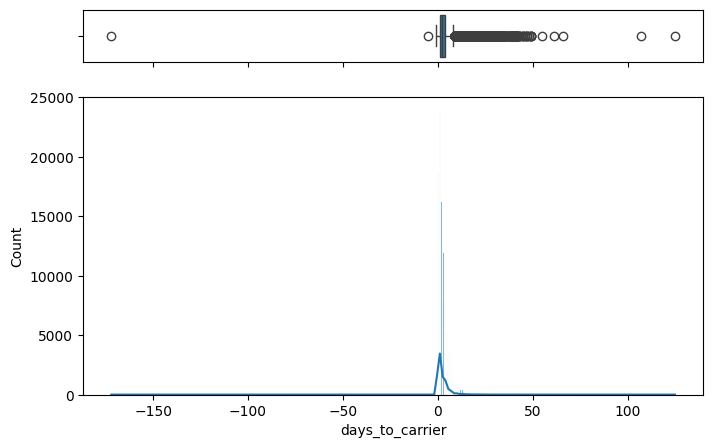

In [22]:
plot_box_hist(dataset_final_agrupado, 'days_to_carrier')

Vemos que hay órdenes donde la fecha en que el vendedor entregó el paquete al flete (despacho) fue previa a la compra, lo cual es un error. Veamos esas órdenes:

In [23]:
dataset_final_agrupado.loc[(dataset_final_agrupado['days_to_carrier'] < 0),['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','days_to_carrier']].sort_values(by='days_to_carrier')

order_purchase_timestamp   order_approved_at  \
46179      2018-07-16 18:40:53 2018-07-16 18:50:22   
23762      2018-08-18 11:49:40 2018-08-18 12:10:30   
1672       2018-08-08 13:18:36 2018-08-08 13:30:15   
301        2018-06-11 12:24:48 2018-06-11 13:32:18   
3254       2018-06-27 11:16:44 2018-06-27 11:30:56   
...                        ...                 ...   
93972      2018-08-16 16:28:13 2018-08-16 16:49:04   
94213      2018-04-25 13:02:26 2018-04-25 13:15:26   
94517      2018-06-25 15:05:27 2018-06-25 15:18:59   
95097      2018-08-13 14:32:07 2018-08-13 14:45:15   
95115      2018-06-29 14:41:28 2018-06-29 14:50:16   

      order_delivered_carrier_date  days_to_carrier  
46179          2018-01-26 13:35:00             -172  
23762          2018-08-14 06:22:00               -5  
1672           2018-08-08 12:19:00               -1  
301            2018-06-11 12:05:00               -1  
3254           2018-06-27 10:57:00               -1  
...                            ...              ...  
93972          2018-08-16 16:27:00               -1  
94213          2018-04-25 12:36:00               -1  
94517          2018-06-25 14:08:00               -1  
95097          2018-08-13 13:55:00               -1  
95115          2018-06-29 14:40:00               -1  

[165 rows x 4 columns]

 Salvo los 2 primeros que son raros (-172 y -5), el resto de todos estos envíos fueron despachados el mismo día, pero el horario anotado de despacho es alrededor de una hora antes de que se efectúe la compra (y por eso obtenemos `days_to_carrier=-1`).

Esto último lo podemos tomar como una problemática particular de como el sistema de la empresa de flete guarda las fechas.

Entonces vamos a borrar los 2 casos extremos, y el resto de los negativos le vamos a cambiar `days_to_carrier` a cero.

In [24]:
dataset_final_agrupado.drop(dataset_final_agrupado[dataset_final_agrupado['days_to_carrier'] < -2].index, inplace=True)

In [25]:
dataset_final_agrupado.loc[dataset_final_agrupado['days_to_carrier'] < 0, 'days_to_carrier'] = 0

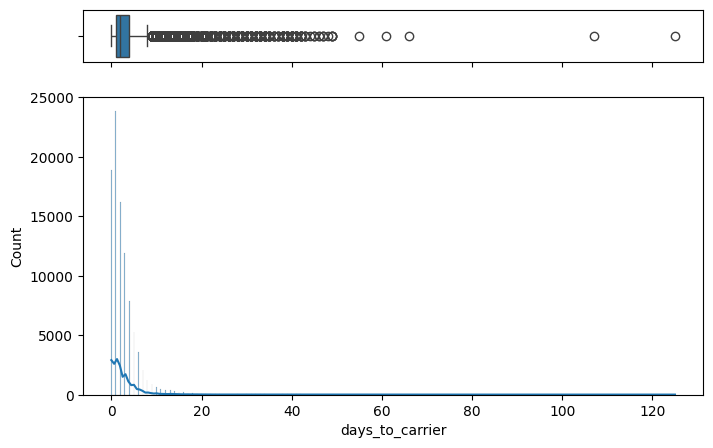

In [26]:
plot_box_hist(dataset_final_agrupado, 'days_to_carrier')

Veamos ahora los que se demoraron mucho en despacharlos (mayor a 50 días):

In [27]:
dataset_final_agrupado[dataset_final_agrupado['days_to_carrier'] > 50]

order_purchase_timestamp   order_approved_at  \
14798      2018-02-19 15:11:50 2018-02-19 15:27:22   
49812      2017-11-16 14:55:04 2017-11-18 02:31:11   
56172      2017-11-29 12:25:00 2017-11-29 12:41:24   
60936      2017-09-06 17:07:29 2017-09-06 17:15:12   
81354      2017-11-14 21:07:55 2017-11-14 21:26:34   

      order_delivered_carrier_date order_delivered_customer_date  \
14798          2018-04-16 13:54:50           2018-04-16 22:16:52   
49812          2018-01-21 16:12:17           2018-01-25 19:38:35   
56172          2018-03-16 13:58:02           2018-03-16 13:58:10   
60936          2017-11-06 20:51:56           2017-12-01 17:09:10   
81354          2018-03-20 15:44:40           2018-03-21 00:18:54   

      order_estimated_delivery_date  order_purchase_year  \
14798                    2018-03-16                 2018   
49812                    2017-12-13                 2017   
56172                    2017-12-26                 2017   
60936                    2017-10-27                 2017   
81354                    2017-12-11                 2017   

       order_purchase_month  order_purchase_dayofmonth  \
14798                     2                         19   
49812                    11                         16   
56172                    11                         29   
60936                     9                          6   
81354                    11                         14   

       order_purchase_dayofweek order_purchase_year_month  ...    price  \
14798                         0                    201802  ...    34.99   
49812                         3                    201711  ...   379.78   
56172                         2                    201711  ...  1259.00   
60936                         2                    201709  ...   975.00   
81354                         1                    201711  ...  1699.00   

       freight_value  product_category_name product_chosen_weight  \
14798          14.10                   toys            213.333333   
49812          21.48  computers_accessories           1125.000000   
56172          95.09        furniture_decor          44916.666667   
60936         108.96                   auto          14100.000000   
81354          56.35                    NaN          10666.666667   

       total_value days_to_approved days_to_carrier  days_to_delivered  \
14798        49.09                0              55                 56   
49812       401.26                1              66                 70   
56172      1354.09                0             107                107   
60936      1083.96                0              61                 86   
81354      1755.35                0             125                126   

       days_estimated days_difference_delivery  
14798              24                      -32  
49812              26                      -44  
56172              26                      -81  
60936              50                      -36  
81354              26                     -101  

[5 rows x 40 columns]

Es medio raro, entre el despacho y la entrega hay muy pocos días.

Parecen pertenecer a problemas de los vendedores.

**A la hora de estimar una fecha de entrega, debemos asumir que los vendedores no tendrán problemas y podrán despachar el producto a tiempo**.

Una posible mejora a futuro: segmentar vendedores en función de sus demoras pasadas y que sea una variable más para entrenar nuestro modelo.

**Por el momento eliminamos las órdenes que tardaron un tiempo excesivo en ser despachadas.**



Vamos a sacar el cuantilo 5 % superior respecto de `days_to_carrier`:

In [28]:
dataset_final_agrupado.shape

(95188, 40)

In [29]:
upper_quantile = dataset_final_agrupado['days_to_carrier'].quantile(0.95)
upper_quantile

np.float64(8.0)

In [30]:
dataset_final_agrupado.drop(dataset_final_agrupado[dataset_final_agrupado['days_to_carrier'] > upper_quantile].index,inplace=True)

In [31]:
dataset_final_agrupado.shape

(90730, 40)

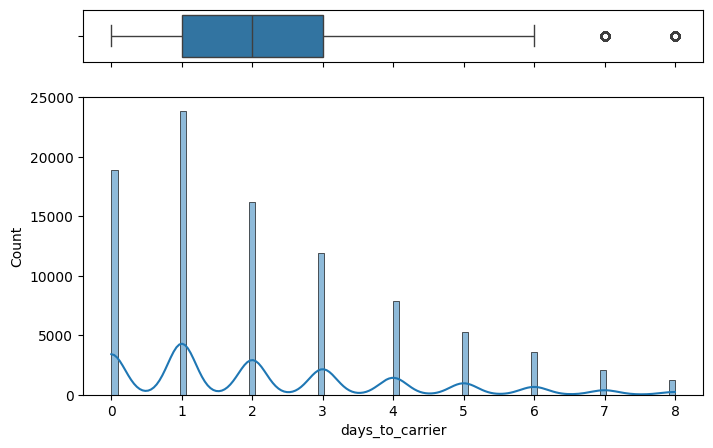

In [32]:
plot_box_hist(dataset_final_agrupado, 'days_to_carrier')

* **Días de demora en aprobar la compra (`days_to_approved`):**

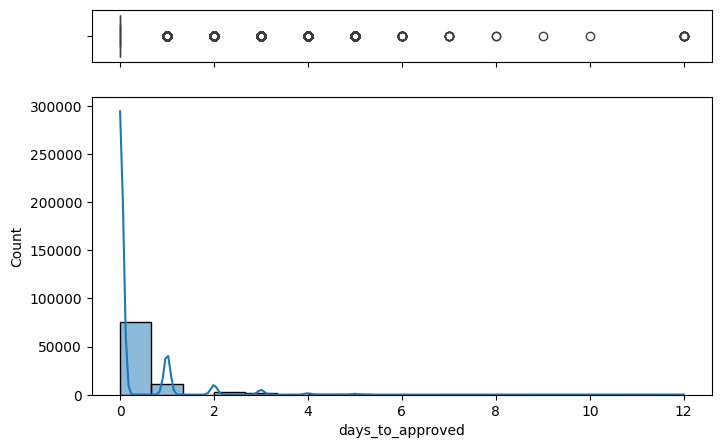

In [33]:
plot_box_hist(dataset_final_agrupado, 'days_to_approved')

Vemos que la mayoría de órdenes donde se demoraba mucho la aprobación no están más, lo cual nos dice que eran las problemáticas/outliers que ya descartamos.

In [34]:
dataset_final_agrupado['days_to_approved'].sort_values(ascending=True).value_counts(sort=False)

days_to_approved
0     75349
1     10997
2      2530
3      1269
4       342
5       203
6        19
7         6
8         2
9         1
10        1
12       11
Name: count, dtype: int64

Vamos a descartar los valores anómalos con 12 días de demora en la aprobación:

In [35]:
dataset_final_agrupado = dataset_final_agrupado[dataset_final_agrupado['days_to_approved'] < 12]

* **Días hasta que el producto fue entregado (`days_to_delivered`):**

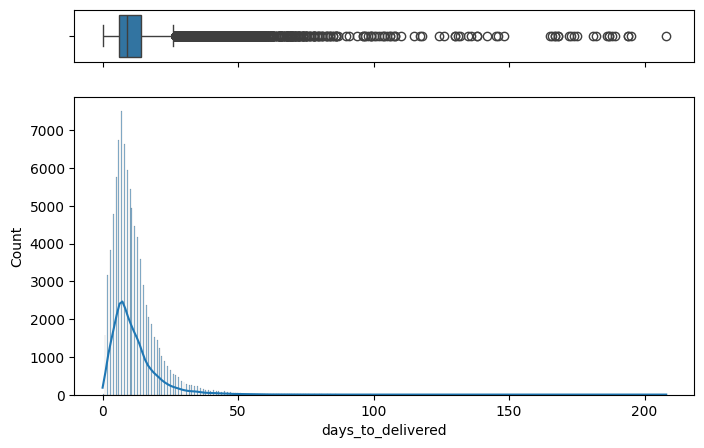

In [36]:
plot_box_hist(dataset_final_agrupado, 'days_to_delivered')

Hay muchos envíos que demoran en llegar varios meses. Aunque en Brasil hay distancias muy grandes, parece excesivo que haya tantos envíos que demoren más de 3 meses.

Veamos cuántas órdenes son:

In [37]:
dataset_final_agrupado['days_to_delivered'].sort_values(ascending=False).value_counts(sort=False).head(20)

days_to_delivered
208    1
195    1
194    2
189    1
188    1
187    2
186    1
182    1
181    1
175    1
174    1
173    1
172    1
168    2
167    2
166    1
165    1
148    1
146    1
145    1
Name: count, dtype: int64

Antes de descartar algún dato, veamos primero los días que fueron estimados para las entregas.

* **Días estimados por el modelo que queremos mejorar (`days_estimated`):**

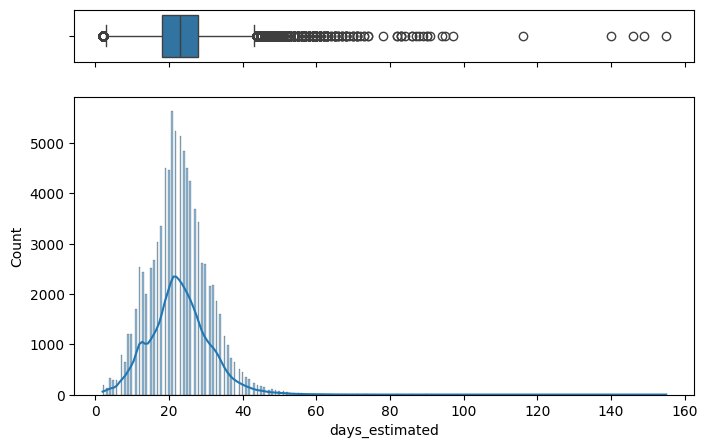

In [38]:
plot_box_hist(dataset_final_agrupado, 'days_estimated')

¿cuántas órdenes son las que se estimaron una excesiva cantidad de días?

In [39]:
dataset_final_agrupado['days_estimated'].sort_values(ascending=False).value_counts(sort=False).head(10)

days_estimated
155    1
149    1
146    1
140    1
116    1
97     1
95     1
94     1
91     1
90     2
Name: count, dtype: int64

Hay órdenes donde la estimación fueron muchos días, por lo cual deben ser distancias largas, y seguramente se corresponden con los envós que tardaron muchos días realmente en llegar.

Exploremos la diferencia entre ambas cantidades

* **Días de diferencia entre fecha estimada de entrega y fecha real de entrega (`days_difference_delivery`):**

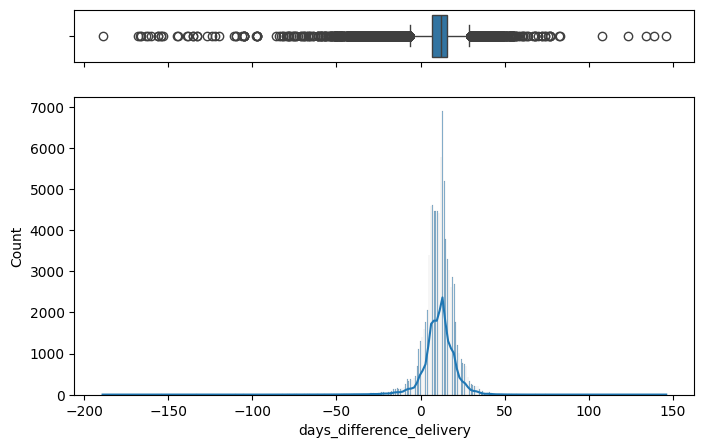

In [40]:
plot_box_hist(dataset_final_agrupado, 'days_difference_delivery')

In [41]:
dataset_final_agrupado['days_difference_delivery'].mean()

np.float64(11.003703744529812)

Vemos que hay órdenes que llegaron meses antes y otras que llegaron meses  después que la fecha estimada, aunque lo primero (positivo) es más común que lo segundo.

De manera general, lo común es que los envíos lleguen antes de lo estimado, la media es de 11 días antes.

Vamos a intentar limpiar aún más los datos con estas dos variables `days_estimated` y `days_to_delivered` (y su resta `days_difference_delivery`)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Análisis bivariado

¿Los envíos que tardaron mucho son los que se estimó que tardarían mucho?

Grafiquemos la relación entre ambas demoras:

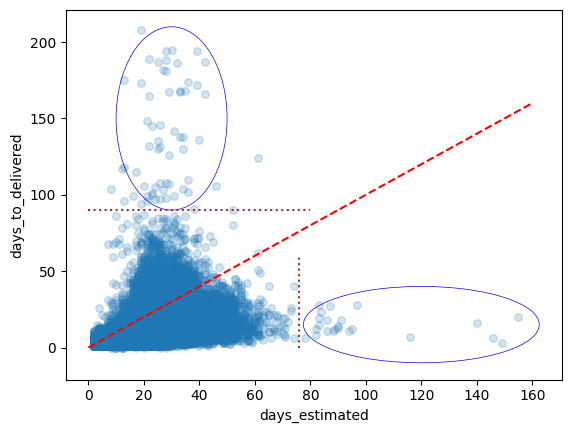

In [42]:
ax=dataset_final_agrupado.plot(kind='scatter', x='days_estimated', y='days_to_delivered', alpha=0.2, s=30)
plt.plot([0, 160], [0, 160], color='red', linestyle='--', label='x=y Line')
plt.plot([0, 80], [90,90], color='brown', linestyle=':', label='y=80 Line')
plt.plot([76, 76], [0,60], color='brown', linestyle=':', label='x=76 Line')

center_x = 30  # X-coordinate of the ellipse center
center_y = 150 # Y-coordinate of the ellipse center
width = 40     # Width of the ellipse (major axis length)
height = 120   # Height of the ellipse (minor axis length)
angle = 0    # Rotation angle of the ellipse in degrees
# Create the Ellipse patch and add to the plot
ellipse1 = Ellipse((center_x, center_y), width, height, angle=angle,
                  edgecolor='blue', facecolor='none', label='Ellipse 1',linewidth=0.5)
ax.add_patch(ellipse1)

center_x = 120 # X-coordinate of the ellipse center
center_y = 15  # Y-coordinate of the ellipse center
width = 85     # Width of the ellipse (major axis length)
height = 50   # Height of the ellipse (minor axis length)
angle = 0    # Rotation angle of the ellipse in degrees
# Create the Ellipse patch and add to the plot
ellipse2 = Ellipse((center_x, center_y), width, height, angle=angle,
                  edgecolor='blue', facecolor='none', label='Ellipse 1',linewidth=0.5)
ax.add_patch(ellipse2)

plt.show()

Puede verse que los puntos que tienen valor de días estimados muy grande no se corresponden con los que tienen valores de días de entrega reales muy grandes.

Pensemos un poco más esto:

- Los envíos que tardaron mucho (arriba de `days_to_delivered=90`, línea punteada), tenían días estimados menores a 50 (salvo un par).

Es decir, los envíos que tardaron más de 90 días reales tenían una estimación de días de envío no mayor a 50. Esos 90 días reales separa verticalmente estos datos que consideramos anómalos del resto de datos que forman el cúmulo principal de abajo a la izquierda.

Los consideramos anómalos porque debe haber ocurrido algo particular para que se demoren tanto (sus fechas estimadas son considerablemente menores). Puede ser algún paro de transporte, una ola de calor o emergencia vehicular que suspenda el transporte por rutas, etc.

- Por otro lado, los datos con días estimados arriba de 76 tienen días reales de demora menores a 25-30, entonces podemos descartarlos con seguridad.

Parecen ser outliers donde el modelo de Olist proveyó una fecha estimada de entrega demasiado alejada, exagerada, tal que no se condijo con lo que luego realmente sucedió.

In [43]:
# # INTENTAMOS AGRUPAR USANDO KMEANS, PERO NO SALIÓ ALGO INTERESANTE QUE NOS APORTE ENTENDIMIENTO
# from sklearn.cluster import KMeans

# # Centroides inciales
# initial_centroids = [[30,170],[150,15],[30,25]]

# kmeans3 = KMeans(n_clusters=3,init=initial_centroids)
# kmeans3.fit(dataset_final_agrupado[['days_estimated','days_to_delivered']])
# # dataset_final_agrupado['cluster'] = kmeans3.labels_
# dataset_final_agrupado['cluster'] = kmeans3.fit_predict(dataset_final_agrupado[['days_estimated','days_to_delivered']])

In [44]:
# dataset_final_agrupado.plot(kind='scatter', x='days_estimated', y='days_to_delivered', c='cluster',cmap='coolwarm', alpha=0.7, s=30)

Eliminamos entonces los outliers:

In [45]:
dataset_final_agrupado.shape

(90719, 40)

In [46]:
dataset_final_agrupado = dataset_final_agrupado[dataset_final_agrupado['days_estimated'] < 76]

In [47]:
dataset_final_agrupado = dataset_final_agrupado[dataset_final_agrupado['days_to_delivered'] < 90]

In [48]:
dataset_final_agrupado.shape

(90634, 40)

Volvemos a graficar:

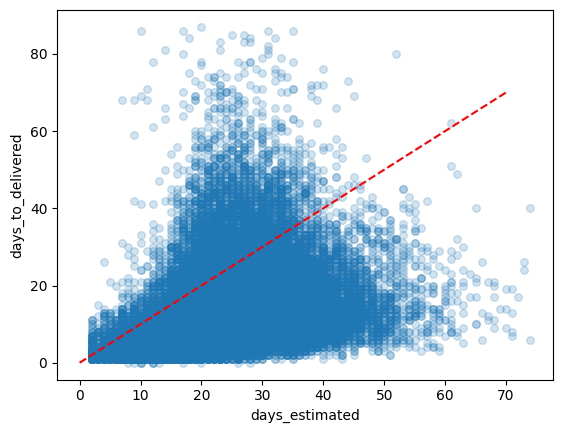

In [49]:
dataset_final_agrupado.plot(kind='scatter', x='days_estimated', y='days_to_delivered', alpha=0.2, s=30)
plt.plot([0, 70], [0, 70], color='red', linestyle='--', label='x=y Line')

¿Nos podrá decir algo graficar la diferencia de días estimados-real versus los días estimados y los días reales?

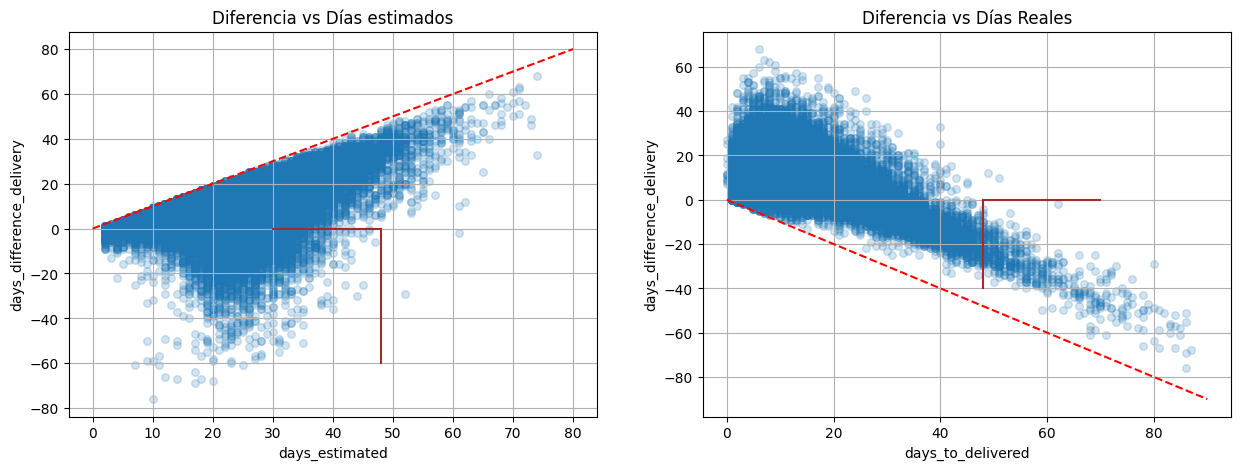

In [50]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.scatter(x=dataset_final_agrupado['days_estimated'] , y=dataset_final_agrupado['days_difference_delivery'], alpha=0.2, s=30)
ax1.plot([0, 80], [0, 80], color='red', linestyle='--', label='x=y Line')
ax1.plot([48, 48], [-60, 0], color='brown', label='x = 48')
ax1.plot([30, 48], [0, 0], color='brown', label='y = 0')
ax1.set_title('Diferencia vs Días estimados')
ax1.set_xlabel('days_estimated')
ax1.set_ylabel('days_difference_delivery')
ax1.grid(True)
ax2.scatter(x=dataset_final_agrupado['days_to_delivered'] , y=dataset_final_agrupado['days_difference_delivery'], alpha=0.2, s=30)
ax2.plot([0, 90], [0, -90], color='red', linestyle='--', label='x=y Line')
ax2.plot([48, 48], [-40, 0], color='brown', label='x = 48')
ax2.plot([48, 70], [0, 0], color='brown', label='y = 0')
ax2.set_title('Diferencia vs Días Reales')
ax2.set_xlabel('days_to_delivered')
ax2.set_ylabel('days_difference_delivery')
ax2.grid(True)
plt.show()

(Recordemos que lo que llamamos "diferencia", la variable `days_difference_delivery` mide los días antes/después que el pedido llegó respecto de la fecha estimada)

Las lineas de trazos rojas son $x=\pm y$.

* **<u>Gráfica de la izquierda</u>**: diferencia vs estimados:
  * La línea roja $x=y$  marca los puntos donde la cantidad de días de envío estimados es igual a la cantidad de días que llegó antes el pedido (antes de la fecha estimada), es decir, los pedidos llegarían el mismo día que efectuada la compra, independientemente de cuánto sea la estimación. Por eso todos los datos caen **<u>debajo</u>** de esta línea, ya que caer arriba significaría que los pedidos habrían llegado antes de efectuada la compra.
  * Otra observación que podemos hacer es que todos (excepto dos) los pedidos que llegaron con demora o atraso (diferencia negativa) pertenecen a compras donde la estimación fue menor de 48 días a partir de la compra (marcada la división con dos líneas marrones)

* **<u>Gráfica de la derecha</u>**: diferencia vs reales:

  * La línea roja $x=-y$ marca los puntos donde los días reales que tardó en llegar el pedido son iguales a la cantidad de días que se demoró en llegar desde la fecha estimada, es decir, como si la fecha estimada de envío fuera 0 días, y todo lo que tardó el pedido en ser entregado se lo cuenta como retraso. Por eso todos los datos caen **<u>arriba</u>** de esta línea, ya que caer abajo significaría que la fecha de entrega estimada es anterior a la fecha de compra.
  * Podemos observar acá también que todos (excepto dos) los pedidos que tardaron mas de 48 días en llegar lo han hecho con retraso (diferencia negativa).


Vamos a intentar otra gráfica que nos permita ver estas características de otra manera:

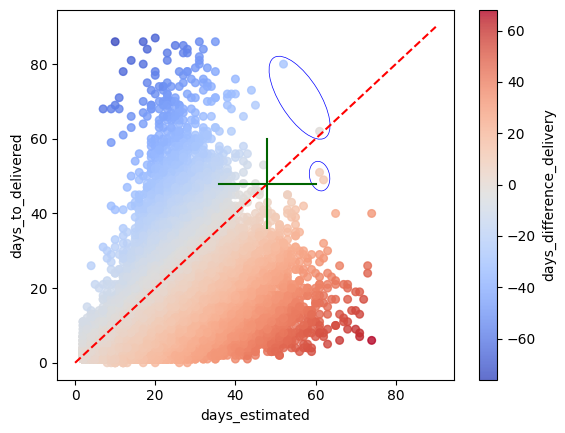

In [51]:
ax= dataset_final_agrupado.plot(kind='scatter', x='days_estimated', y='days_to_delivered', c='days_difference_delivery',cmap='coolwarm', alpha=0.8, s=30)
ax.plot([0, 90], [0, 90], color='red', linestyle='--', label='x=y Line')
ax.plot([36, 60], [48, 48], color='darkgreen', label='y=48 Line')
ax.plot([48, 48], [36, 60], color='darkgreen', label='x=48 Line')

# Define ellipse parameters
center_x = 56  # X-coordinate of the ellipse center
center_y = 71  # Y-coordinate of the ellipse center
width = 10     # Width of the ellipse (major axis length)
height = 25    # Height of the ellipse (minor axis length)
angle = 30    # Rotation angle of the ellipse in degrees
# Create the Ellipse patch
ellipse1 = Ellipse((center_x, center_y), width, height, angle=angle,
                  edgecolor='blue', facecolor='none', label='Ellipse 1',linewidth=0.5)
# Add the ellipse to the plot
ax.add_patch(ellipse1)
# Define ellipse parameters
center_x = 61  # X-coordinate of the ellipse center
center_y = 50  # Y-coordinate of the ellipse center
width = 5     # Width of the ellipse (major axis length)
height = 8    # Height of the ellipse (minor axis length)
angle = 10    # Rotation angle of the ellipse in degrees
# Create the Ellipse patch
ellipse2 = Ellipse((center_x, center_y), width, height, angle=angle,
                  edgecolor='blue', facecolor='none', label='Ellipse 2',linewidth=0.5)
# Add the ellipse to the plot
ax.add_patch(ellipse2)

plt.show()

Los colores midiendo la diferencia es lógico que tomen esa distribución, ya que para cada punto este valor se calcula restando `days_estimated` con `days_to_delivered` (o sea, la coordenada $x$ menos la $y$ de cada punto).

Lo concluido en las gráficas anteriores puede reformularse en función de la actual, considerando la cruz verde centrada en (48,48):
* Todos los datos arriba de la cruz llegaron atrasados
* Todo los datos a la derecha de la cruz llegaron anticipados.

Para cada afirmación hay dos exepciones que están señaladas con las elipses azules.

##### <u>¿Distribución en el tiempo de fecha estimada y fecha real?</u>

Nos preguntamos ahora cómo estas cantidades se distribuyen en el tiempo.

Graficamos `days_to_delivered` versus `order_purchase_timestamp`.

Primero agrupamos volumen de envíos y demora promedio por mes:

In [52]:
monthly_volume = dataset_final_agrupado.groupby('order_purchase_year_month').agg(
    volume_month=('order_purchase_timestamp', 'count'),
    days_to_delivered_mean=('days_to_delivered', 'mean'),
    days_estimated_mean=('days_estimated', 'mean'),
    difference_mean=('days_difference_delivery', 'mean')
)
monthly_volume.head(5)

volume_month  days_to_delivered_mean  \
order_purchase_year_month                                         
201702                             1497               11.262525   
201703                             2395               11.040501   
201704                             2125               13.126118   
201705                             3376               10.128555   
201706                             2995               10.839065   

                           days_estimated_mean  difference_mean  
order_purchase_year_month                                        
201702                               31.217101        19.259853  
201703                               24.022129        12.331524  
201704                               26.635765        12.840941  
201705                               23.600711        12.803910  
201706                               23.452755        12.104174

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\637101958.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


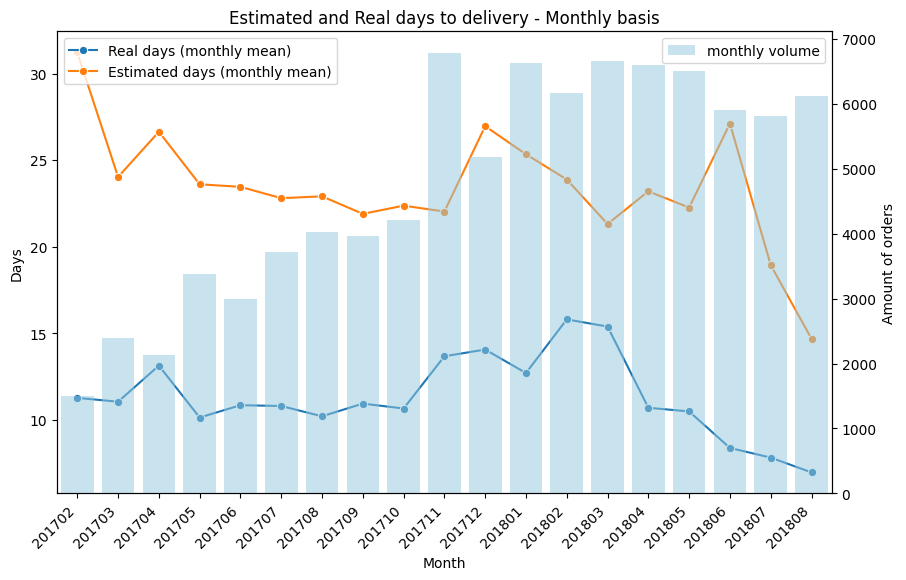

In [53]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=monthly_volume, x=monthly_volume.index, y='days_to_delivered_mean', ax=ax1, marker='o', label='Real days (monthly mean)')
sns.lineplot(data=monthly_volume, x=monthly_volume.index, y='days_estimated_mean', ax=ax1, marker='o', label='Estimated days (monthly mean)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

ax2 = ax1.twinx()
sns.barplot(data=monthly_volume, x=monthly_volume.index, y='volume_month', ax=ax2, color='skyblue', alpha=0.5, label='monthly volume')

ax1.set_xlabel('Month')
ax1.set_ylabel('Days')
ax2.set_ylabel('Amount of orders')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Estimated and Real days to delivery - Monthly basis')
plt.show()

Pueden existir outliers que no estamos viendo debido a que promediamos mensualmente. Veamos los mismos datos pero diariamente:

In [54]:
daily_volume = dataset_final_agrupado.groupby('order_purchase_year_month_day').agg(
    volume_day=('order_purchase_timestamp', 'count'),
    days_to_delivered_mean=('days_to_delivered', 'mean'),
    days_estimated_mean=('days_estimated', 'mean'),
    difference_mean=('days_difference_delivery', 'mean')
)
daily_volume.head(5)

volume_day  days_to_delivered_mean  \
order_purchase_year_month_day                                       
20170201                               57                9.719298   
20170202                               63               11.619048   
20170203                               46                9.804348   
20170204                               55               10.836364   
20170205                               69                9.260870   

                               days_estimated_mean  difference_mean  
order_purchase_year_month_day                                        
20170201                                 34.894737        24.403509  
20170202                                 34.857143        22.523810  
20170203                                 35.434783        25.021739  
20170204                                 33.272727        21.690909  
20170205                                 31.434783        21.376812

In [55]:
daily_volume.shape

(575, 4)

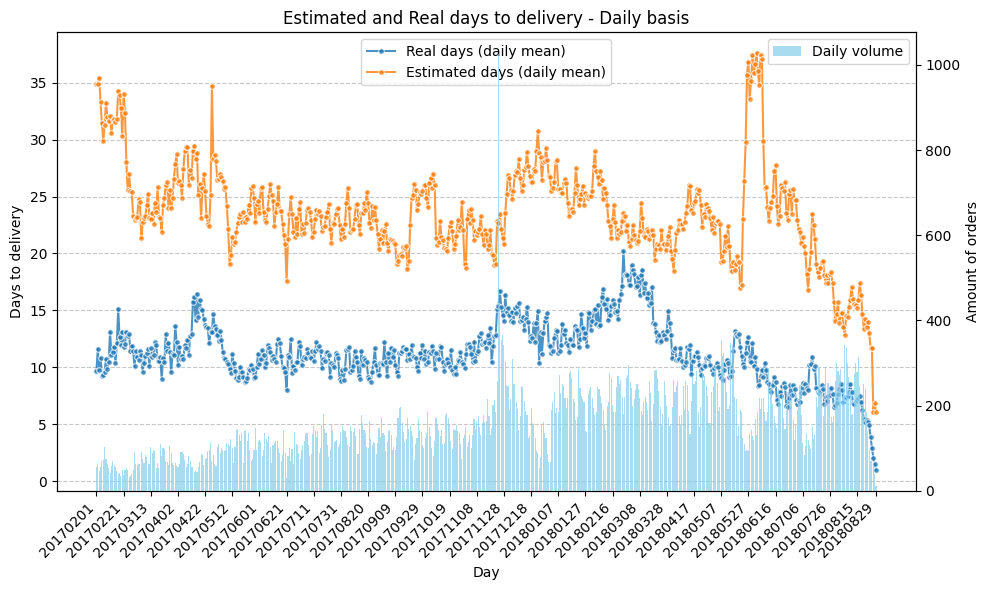

In [56]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Line plots: Real vs Estimated days ---
sns.lineplot(data=daily_volume, x=daily_volume.index, y='days_to_delivered_mean', ax=ax1, marker='o', markersize=4, alpha=0.8, label='Real days (daily mean)')
sns.lineplot(data=daily_volume, x=daily_volume.index, y='days_estimated_mean', ax=ax1, marker='o', markersize=4, alpha=0.8, label='Estimated days (daily mean)')

ax2 = ax1.twinx()
ax2.bar(daily_volume.index, daily_volume['volume_day'], color='skyblue', alpha=0.7, label='Daily volume', width=0.8)

# --- X-axis ticks every ~20 points ---
n = len(daily_volume)
tick_positions = list(range(0, n, 20))
if tick_positions[-1] != n - 1:
    tick_positions.append(n - 1)

# Set corresponding labels
ax1.set_xticks(tick_positions)
ax1.set_xticklabels([str(daily_volume.index[i]) for i in tick_positions], rotation=45, ha='right')

# --- Axis labels & title ---
ax1.set_xlabel('Day'); ax1.set_ylabel('Days to delivery'); ax2.set_ylabel('Amount of orders')
plt.title('Estimated and Real days to delivery - Daily basis')

ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper center'); ax2.legend(loc='upper right')
plt.tight_layout(); plt.show()

Notamos tres particularidades:

1) Los volúmenes diarios no pasan de 350-400 órdenes por día, salvo un día particular donde la demanada fue de 1000 pedidos

2) A fines de Mayo de 2018 hay un incremento abrupto de los días estimados y se mantiene varios días.

3) Hay un descenso marcado en las tres cantidades durante los últimos 6-7 días graficados.

Veamos lo primero:

In [57]:
daily_volume.sort_values(by='volume_day', ascending=False).head(5)

volume_day  days_to_delivered_mean  \
order_purchase_year_month_day                                       
20171124                             1025               15.410732   
20171125                              428               16.735981   
20171127                              366               14.620219   
20171126                              353               15.342776   
20180507                              353                9.039660   

                               days_estimated_mean  difference_mean  
order_purchase_year_month_day                                        
20171124                                 22.678049         6.897561  
20171125                                 23.504673         6.432243  
20171127                                 21.401639         6.437158  
20171126                                 22.141643         6.331445  
20180507                                 19.226629         9.821530

24 de Noviembre de 2017. Fue viernes, el último viernes del mes. Quizás habia una campaña de ofertas de cara a las fiestas, o similar.

De todas formas, los promedios de fechas estimadas de envío y fechas reales de llegada de los productos cambian relativamente poco a partir de ese día. Pegan un pequeño salto que luego parece mantenerse en el tiempo.

No presentan grandes diferencias con los otros promedios diarios, asi que no ahondaremos en el analisis.

---
Respecto de la segunda observación:

Hay un pico alto de fechas estimadas que se mantiene por varios días y que comienza alrededor del 27 de Mayo de 2018. Es probable que se deba al paro de camioneros que hubo en Brasil en esas fechas ([link BBC](https://www.bbc.com/mundo/noticias-america-latina-44259888#:~:text=%C2%BFPor%20qu%C3%A9%20protestan%20los%20camioneros,se%20suspendieran%20por%2015%20d%C3%ADas.&text=Pie%20de%20foto%2C%20Solo%20dos,a%20la%20poblaci%C3%B3n%20como%20reh%C3%A9n.)) y al cual también se le sumó un paro de petroleros.

Lo curioso es que no parece haber afectado mucho los días reales de demora (promedio diario). Creemos que esto se debe a que los pedidos que se atrasaron debido a este evento extraordinario ya los hemos identificado como outliers y descartado en los pasos anteriores.

Exploremos esas fechas un poco más:

In [58]:
datos_paro_camiones = dataset_final_agrupado.loc[(dataset_final_agrupado['order_purchase_timestamp'] >= '2018-05-20') & (dataset_final_agrupado['order_purchase_timestamp'] <= '2018-06-22')].sort_values(by='order_purchase_timestamp')
datos_paro_camiones.shape

(5774, 40)

In [59]:
daily_volume_zoom = datos_paro_camiones.groupby('order_purchase_year_month_day').agg(
    volume_day=('order_purchase_timestamp', 'count'),
    days_to_delivered_mean=('days_to_delivered', 'mean'),
    days_estimated_mean=('days_estimated', 'mean'),
    difference_mean=('days_difference_delivery', 'mean')
)
daily_volume_zoom.head(5)

volume_day  days_to_delivered_mean  \
order_purchase_year_month_day                                       
20180520                              152               12.980263   
20180521                              189               11.820106   
20180522                              186               11.016129   
20180523                              124               10.306452   
20180524                              110               10.027273   

                               days_estimated_mean  difference_mean  
order_purchase_year_month_day                                        
20180520                                 19.223684         5.756579  
20180521                                 16.947090         4.788360  
20180522                                 17.231183         5.833333  
20180523                                 23.064516        12.443548  
20180524                                 26.327273        15.954545

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\2739899103.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


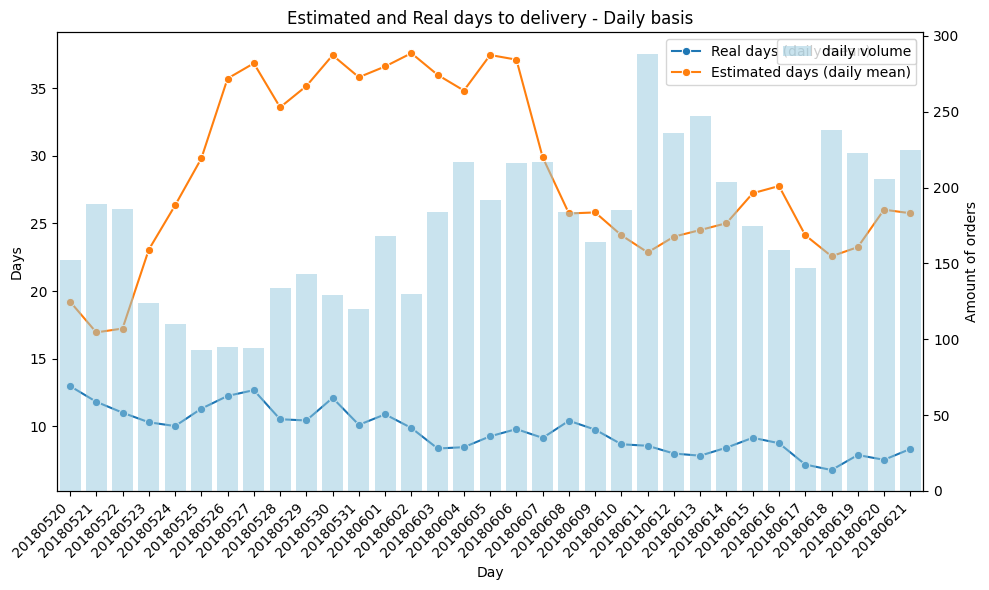

In [60]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=daily_volume_zoom, x=daily_volume_zoom.index, y='days_to_delivered_mean', ax=ax1, marker='o', label='Real days (daily mean)')
sns.lineplot(data=daily_volume_zoom, x=daily_volume_zoom.index, y='days_estimated_mean', ax=ax1, marker='o', label='Estimated days (daily mean)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax2 = ax1.twinx()
sns.barplot(data=daily_volume_zoom, x=daily_volume_zoom.index, y='volume_day', ax=ax2, color='skyblue', alpha=0.5, label='daily volume')
ax1.set_xlabel('Day')
ax1.set_ylabel('Days')
ax2.set_ylabel('Amount of orders')
plt.title('Estimated and Real days to delivery - Daily basis')
plt.tight_layout()
plt.show()

Si miramos todos los datos, sin promediar:

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\1708513267.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


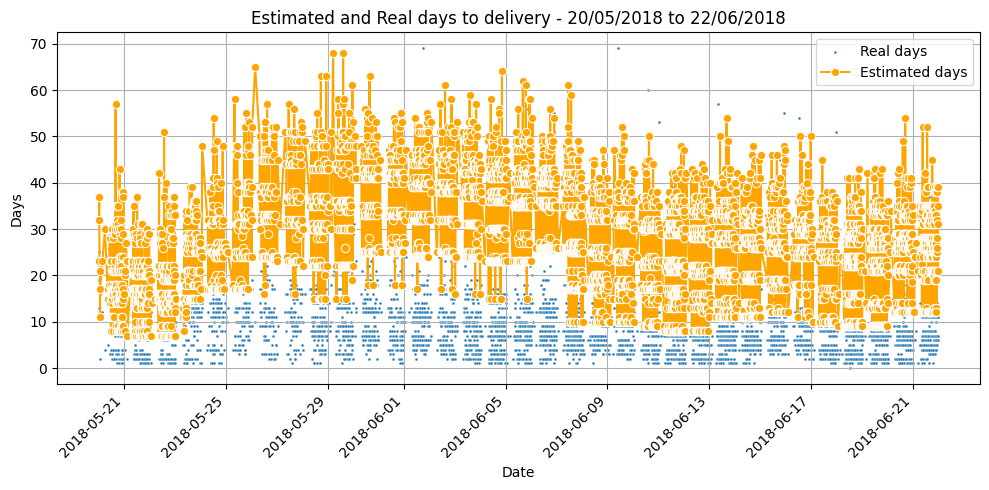

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=datos_paro_camiones, x='order_purchase_timestamp', y='days_to_delivered', ax=ax1, label='Real days',s=4)
sns.lineplot(data=datos_paro_camiones, x='order_purchase_timestamp', y='days_estimated', ax=ax1, label='Estimated days',color='orange', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Days')
plt.title('Estimated and Real days to delivery - 20/05/2018 to 22/06/2018')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


Si bien el modelo usado por Olist sobreestimó **en promedio** la demora del envío en esos días (25/05/2017 al 07/06/2017), la cantidad de días reales de envío se comportó **en promedio** igual que los demás días. Esto último es el dato que nos importa a la hora de modelizar, ya que es nuestro target.

El incremento en la estimación durante estas fechas nos podrá traer problemas a la hora de evaluar cómo nuestro propio modelo se compara con el modelo viejo usado por Olist. Estos días particulares van a empujar el error del modelo viejo hacia arriba, pudiendo hacernos creer que nuestro nuevo modelo estima mejor que el viejo cuando en realidad no estamos compensando por el exceso de estos días de paro.

<u>Opciones:</u>

* Eliminar los datos de esas 2 semanas. Son alrededor de 5000 filas. Tendríamos un agujero temporal de 2 semanas en los datos.
* Renormalizar las fechas estimadas de esos días, restándoles los días necesarios para que su promedio diario se iguale al de los días vecinos a los datos anómalos. Deberíamos restarles aproximadamente 10 días, para que el promedio de 35 días baje a 25, que es lo que tenemos a partir del 8 de Junio (2018-06-08).
* Dejar los datos como están y **asumir** que ese incremento promedio de 10 días en la fecha estimada durante esas dos semanas no modificará de manera sustancial la magnitud del error, ya que este último se calcula con datos de 2 años. De todas maneras, nuestras predicciones vamos a compararlas con algún otro modelo simple que armemos, por lo que el error de esta cantidad no afectará nuestra elección de modelo.

Elegimos la última opción, dejar los datos como están.

---
Por último, el item 3, la baja abrupta de datos en la última semana.

Veamos con mas detalle esos últimos días:

In [62]:
datos_ultimas_semanas = dataset_final_agrupado.loc[dataset_final_agrupado['order_purchase_timestamp'] > '2018-08-15'].sort_values(by='order_purchase_timestamp')
datos_ultimas_semanas.shape

(2389, 40)

In [63]:
daily_volume_zoom = datos_ultimas_semanas.groupby('order_purchase_year_month_day').agg(
    volume_day=('order_purchase_timestamp', 'count'),
    days_to_delivered_mean=('days_to_delivered', 'mean'),
    days_estimated_mean=('days_estimated', 'mean'),
    difference_mean=('days_difference_delivery', 'mean')
)
daily_volume_zoom.head(5)

volume_day  days_to_delivered_mean  \
order_purchase_year_month_day                                       
20180815                              278                7.154676   
20180816                              314                7.337580   
20180817                              247                7.502024   
20180818                              190                6.984211   
20180819                              198                6.237374   

                               days_estimated_mean  difference_mean  
order_purchase_year_month_day                                        
20180815                                 15.255396         7.712230  
20180816                                 15.904459         8.235669  
20180817                                 17.396761         9.627530  
20180818                                 16.342105         8.921053  
20180819                                 14.661616         8.005051

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\2739899103.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


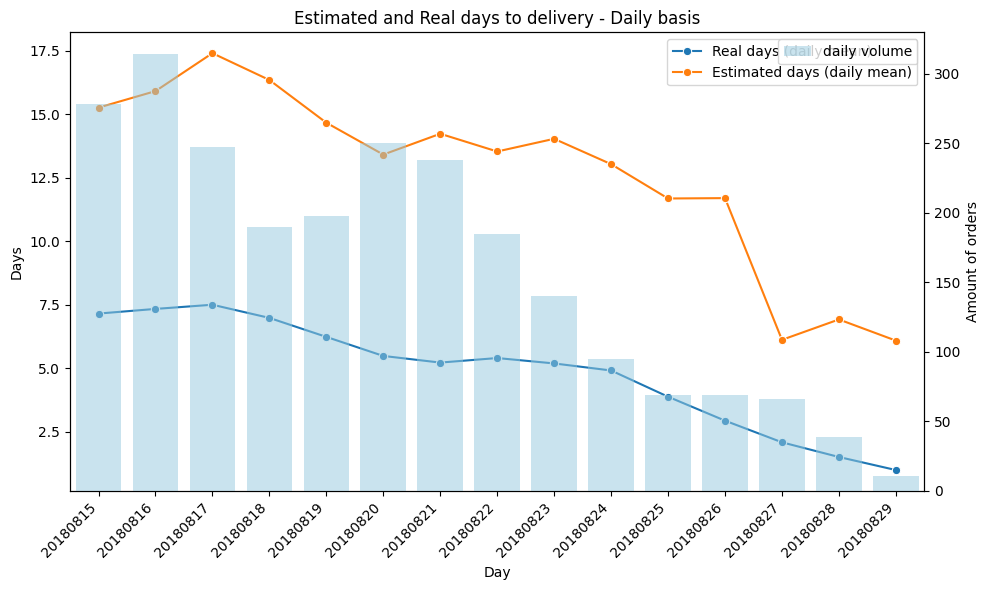

In [64]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=daily_volume_zoom, x=daily_volume_zoom.index, y='days_to_delivered_mean', ax=ax1, marker='o', label='Real days (daily mean)')
sns.lineplot(data=daily_volume_zoom, x=daily_volume_zoom.index, y='days_estimated_mean', ax=ax1, marker='o', label='Estimated days (daily mean)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax2 = ax1.twinx()
sns.barplot(data=daily_volume_zoom, x=daily_volume_zoom.index, y='volume_day', ax=ax2, color='skyblue', alpha=0.5, label='daily volume')
ax1.set_xlabel('Day')
ax1.set_ylabel('Days')
ax2.set_ylabel('Amount of orders')
plt.title('Estimated and Real days to delivery - Daily basis')
plt.tight_layout()
plt.show()

In [65]:
daily_volume_zoom.sort_values(by='volume_day', ascending=True).head(12)

volume_day  days_to_delivered_mean  \
order_purchase_year_month_day                                       
20180829                               11                1.000000   
20180828                               39                1.512821   
20180827                               66                2.090909   
20180826                               69                2.942029   
20180825                               69                3.884058   
20180824                               95                4.915789   
20180823                              140                5.192857   
20180822                              185                5.405405   
20180818                              190                6.984211   
20180819                              198                6.237374   
20180821                              238                5.226891   
20180817                              247                7.502024   

                               days_estimated_mean  difference_mean  
order_purchase_year_month_day                                        
20180829                                  6.090909         5.090909  
20180828                                  6.923077         5.102564  
20180827                                  6.121212         3.651515  
20180826                                 11.695652         8.376812  
20180825                                 11.681159         7.463768  
20180824                                 13.031579         7.863158  
20180823                                 14.028571         8.528571  
20180822                                 13.529730         7.805405  
20180818                                 16.342105         8.921053  
20180819                                 14.661616         8.005051  
20180821                                 14.226891         8.663866  
20180817                                 17.396761         9.627530

Muchas de las órdenes incluidas originalmente en los dataset de fines de Agosto de 2018 (y posteriores) fueron previamente limpiadas. Esto se debió a que pertenecen al extremo temporal del dataset y podríamos decir que son datos que pueden estar incompletos o no curados. Además es probable que la mayoría de esas órdenes no tengan estatus "delivered".

Teniendo esto en cuenta, decidimos eliminar los datos de los últimos 7 días del dataset actual, es decir 23 de Agosto 2018 en adelante.

In [66]:
dataset_final_agrupado.shape

(90634, 40)

In [67]:
dataset_final_agrupado = dataset_final_agrupado[dataset_final_agrupado['order_purchase_timestamp'] < '2018-08-23']

In [68]:
dataset_final_agrupado.shape

(90145, 40)

---
### Distancia seller-customer

Armaremos aqui una nueva columna con la distancia entre customer y seller, en kilómetros.

In [69]:
# !pip install geopy

In [70]:
from geopy.distance import geodesic

In [71]:
dataset_final_agrupado['distance_km'] = dataset_final_agrupado.apply(lambda row: geodesic((row['customer_lat'], row['customer_lng']), (row['seller_lat'], row['seller_lng'])).km, axis=1)

In [72]:
dataset_final_agrupado[['customer_lat','customer_lng','seller_lat','seller_lng','distance_km']]

customer_lat  customer_lng  seller_lat  seller_lng  distance_km
0        -21.763009    -41.310799  -22.499217  -44.125997   301.652715
1        -20.205187    -50.927017  -23.565803  -46.519192   588.109709
2        -19.870095    -44.593984  -22.272310  -46.165743   312.110598
3        -23.106036    -46.592481  -20.554801  -47.387749   294.212074
5        -19.740232    -47.925038  -21.189678  -47.787260   161.110947
...             ...           ...         ...         ...          ...
95185     -2.493805    -44.298702  -26.912555  -48.674423  2742.231847
95186    -25.589281    -49.315098  -23.536609  -46.642445   353.535031
95187    -23.598457    -46.642119  -25.469292  -49.289370   338.942563
95188    -23.037661    -46.979720  -23.636657  -46.694780    72.455870
95189    -22.916039    -48.441094  -21.757538  -48.829262   134.373964

[90145 rows x 5 columns]

In [73]:
# # Otra forma para calcular la distancia más rápida, pero menos precisa, es con la fórmula de Haversine

# !pip install haversine
# import haversine as hs
# from haversine import Unit

# loc1=(-25.766121, -49.720209)
# loc2=(-20.496391, -47.417730)

# result=hs.haversine(loc1,loc2,unit=Unit.KILOMETERS)
# print("The distance calculated is:",result)

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Análisis univariado

Grafiquemos un histograma con las distancias seller-customer:

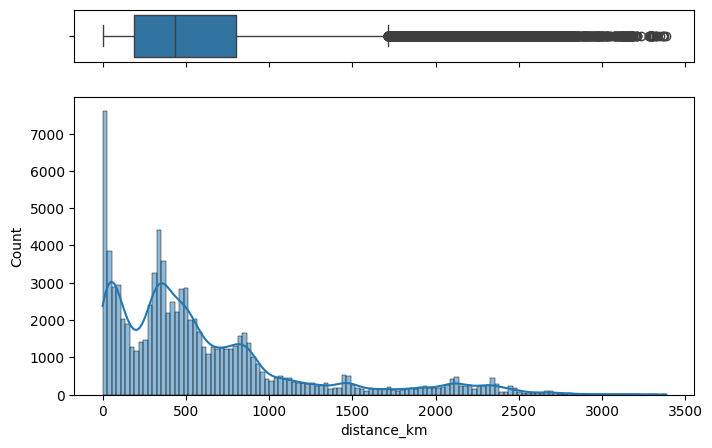

In [74]:
plot_box_hist(dataset_final_agrupado, 'distance_km')

Veamos que no hay diferencias marcadas entre la distribución de 2017 o 2018:

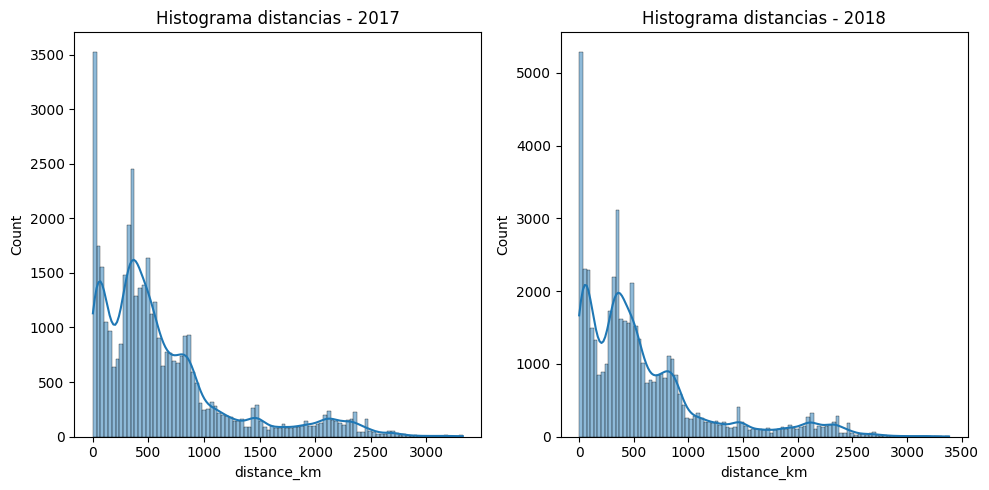

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=dataset_final_agrupado[dataset_final_agrupado['order_purchase_year']==2017], x='distance_km',ax=axes[0],kde=True)
axes[0].set_title('Histograma distancias - 2017')
sns.histplot(data=dataset_final_agrupado[dataset_final_agrupado['order_purchase_year']==2018], x='distance_km', ax=axes[1],kde=True)
axes[1].set_title('Histograma distancias - 2018')
plt.tight_layout()
plt.show()

Esta repetición en la distribución de las distancias para cada año nos hace concluir que los valores extremos (arriba de 2500 km) no son outliers azarosos, sino que representan compras que suceden año a año (aunque son pocas).

¿Y la distribución de distancias para envíos que llegan atrasados vs adelantados?

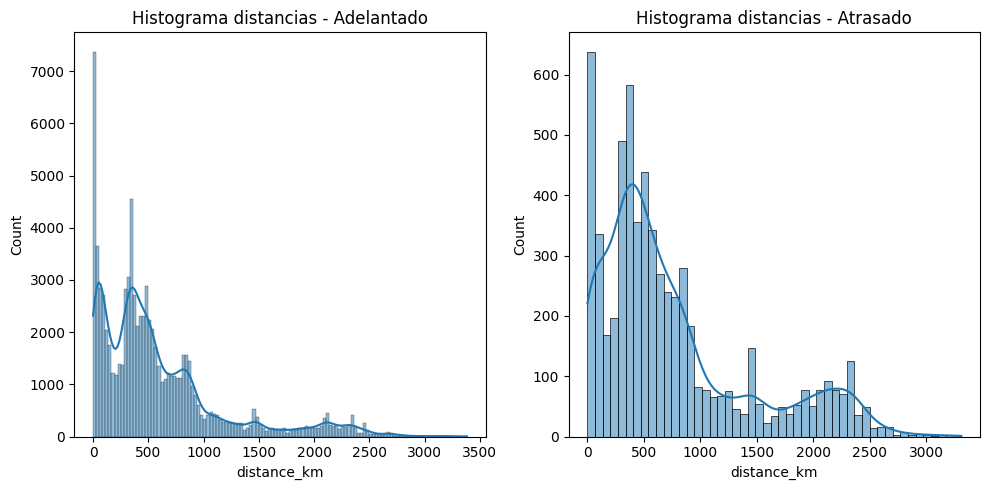

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=dataset_final_agrupado[dataset_final_agrupado['days_difference_delivery']>=0], x='distance_km',ax=axes[0],kde=True)
axes[0].set_title('Histograma distancias - Adelantado')
sns.histplot(data=dataset_final_agrupado[dataset_final_agrupado['days_difference_delivery']<0], x='distance_km', ax=axes[1],kde=True)
axes[1].set_title('Histograma distancias - Atrasado')
plt.tight_layout()
plt.show()

Por un lado podemos ver claramente que la mayoría de los envíos llegan a tiempo o antes del tiempo estimado (adelantado).

Pero además podemos notar que no hay indicios de que la distancia sea la causa del atraso o adelanto, ya que los histogramas para ambas situaciones son muy similares.

Los picos seguramente están relacionados con las rutas más usadas.
En particular, el pico cercano a cero nos dice algo un poco obvio: muchas compras ocurren entre customers y sellers de la misma ciudad o cercanos.

¿Cómo podemos explorar estos picos en la distribución de distancia?

Agrupemos por ciudad y estado tanto de seller como customer, y veamos

* cantidad de envíos
* distancia promedio
* días de demora promedio
* días estimado promedio
* días de adelanto/atraso respecto de estimado, promedio

In [77]:
agrupado_ciudades_estados = dataset_final_agrupado.groupby(['seller_city','seller_state','customer_city','customer_state']).agg(
    distance_km_mean=('distance_km', 'mean'),
    # distance_km_min=('distance_km', 'min'),
    # distance_km_max=('distance_km', 'max'),
    count=('distance_km', 'count'),
    days_to_delivered_mean=('days_to_delivered', 'mean'),
    days_difference_delivery_mean=('days_difference_delivery', 'mean'),
    days_estimated_mean=('days_estimated', 'mean')
).sort_values(by='count', ascending=False).reset_index()

agrupado_ciudades_estados.head(20)

seller_city seller_state          customer_city customer_state  \
0        sao paulo           SP              sao paulo             SP   
1        sao paulo           SP         rio de janeiro             RJ   
2         ibitinga           SP              sao paulo             SP   
3        sao paulo           SP         belo horizonte             MG   
4         ibitinga           SP         rio de janeiro             RJ   
5        sao paulo           SP               brasilia             DF   
6      santo andre           SP              sao paulo             SP   
7         curitiba           PR              sao paulo             SP   
8   ribeirao preto           SP              sao paulo             SP   
9        sao paulo           SP               campinas             SP   
10       sao paulo           SP               curitiba             PR   
11      piracicaba           SP              sao paulo             SP   
12       sao paulo           SP           porto alegre             RS   
13       sao paulo           SP               salvador             BA   
14       guarulhos           SP              sao paulo             SP   
15       sao paulo           SP              guarulhos             SP   
16         maringa           PR              sao paulo             SP   
17  rio de janeiro           RJ              sao paulo             SP   
18  rio de janeiro           RJ         rio de janeiro             RJ   
19       sao paulo           SP  sao bernardo do campo             SP   

    distance_km_mean  count  days_to_delivered_mean  \
0          15.325358   3817                4.820278   
1         345.084214   1301               13.640277   
2         302.197227   1044               10.020115   
3         490.825067    540                9.453704   
4         579.226417    458               16.639738   
5         874.513647    446               11.008969   
6          18.286495    415                4.718072   
7         340.663661    352                8.392045   
8         291.915683    339               10.277286   
9          89.334967    337                6.762611   
10        342.290289    329                9.404255   
11        142.203857    317                5.287066   
12        849.271894    307               14.830619   
13       1458.026632    307               17.596091   
14         19.635170    294                5.159864   
15         20.628156    294                5.125850   
16        539.836557    267                9.516854   
17        345.411627    260                9.361538   
18         18.653142    255                5.058824   
19         19.950079    252                4.345238   

    days_difference_delivery_mean  days_estimated_mean  
0                        8.185486            13.402410  
1                       12.199078            26.198309  
2                        9.969349            20.424330  
3                       10.805556            20.644444  
4                        8.949782            25.993450  
5                       10.901345            22.282511  
6                        9.142169            14.286747  
7                       13.184659            21.988636  
8                        8.702065            19.407080  
9                        6.789318            13.988131  
10                      11.738602            21.522796  
11                       9.690852            15.400631  
12                      10.804560            26.042345  
13                       8.560261            26.534202  
14                       7.625850            13.180272  
15                       8.088435            13.615646  
16                      16.074906            25.955056  
17                      10.657692            20.446154  
18                      12.180392            17.580392  
19                       9.055556            13.809524

Como esperábamos, las rutas más usadas son sao paulo/sao paulo y sao paulo/rio de janiero.

Exploremos un poco más la distribución geográfica.

Podemos hacer una tabla similar pero solamente a nivel de estados:

In [78]:
agrupado_estados = agrupado_ciudades_estados.groupby(['seller_state','customer_state']).agg(
    distance_km_mean=('distance_km_mean', 'mean'),
    count=('count', 'sum'),
    days_to_delivered_mean=('days_to_delivered_mean', 'mean'),
    days_difference_delivery_mean=('days_difference_delivery_mean', 'mean'),
    days_estimated_mean=('days_estimated_mean', 'mean')
).sort_values(by='count', ascending=False).reset_index()
agrupado_estados.head(10)

seller_state customer_state  distance_km_mean  count  \
0           SP             SP        210.238785  28498   
1           SP             RJ        487.553204   7481   
2           SP             MG        501.516944   6860   
3           SP             RS        910.777189   3367   
4           SP             PR        493.956047   2901   
5           PR             SP        484.454501   2736   
6           MG             SP        402.891134   2422   
7           SP             SC        587.288222   2167   
8           SP             BA       1361.204155   2155   
9           MG             MG        308.837293   1468   

   days_to_delivered_mean  days_difference_delivery_mean  days_estimated_mean  
0                7.843200                      10.128590            18.367529  
1               15.464497                       9.596635            25.455697  
2               11.901410                      11.902981            24.212114  
3               14.727352                      14.558606            29.728615  
4               12.777969                      12.304746            25.519332  
5               10.202160                      15.277624            25.885284  
6               10.280188                      12.706034            23.395657  
7               14.937202                      10.710946            26.053805  
8               19.173469                      10.684730            30.280133  
9                8.113431                      11.839236            20.388879

El estado de Sao Paulo es dominante tanto en compradores como vendedores.

In [79]:
print('Porcentaje órdenes con vendedores de SP:')
print((100*agrupado_estados[agrupado_estados['seller_state']=='SP']['count'].sum() / agrupado_estados['count'].sum()).round(2))

print('Porcentaje órdenes con compradores de SP:')
print((100*agrupado_estados[agrupado_estados['customer_state']=='SP']['count'].sum() / agrupado_estados['count'].sum()).round(2))

print('Porcentaje órdenes con compradores y vendedores de SP:')
print((100*agrupado_estados.loc[0,'count'] / agrupado_estados['count'].sum()).round(2))

print('Porcentaje órdenes con compradores o vendedores de SP:')
print((100*agrupado_estados[(agrupado_estados['customer_state']=='SP') | (agrupado_estados['seller_state']=='SP')]['count'].sum() / agrupado_estados['count'].sum()).round(2))


Porcentaje órdenes con vendedores de SP:
70.34
Porcentaje órdenes con compradores de SP:
41.97
Porcentaje órdenes con compradores y vendedores de SP:
31.61
Porcentaje órdenes con compradores o vendedores de SP:
80.7


&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

#### Mapas y distribución geográfica

**NOTA: LOS MAPAS OCUPAN MUCHA MEMORIA Y NO HEMOS CONCLUIDO NADA FUNDAMENTAL DE MIRARLOS.**

**Entonces insertamos imágenes captura de pantalla y solamente dejamos los códigos comentados para que estén disponibles.**

Recordemos que el 70% de las órdenes salen desde vendedores que se encuentran en el estado de Sao Paulo, asi como el 42% de las órdenes llegan a compradores en Sao Paulo. Comparemos con los otros estados usando gráficos de torta:

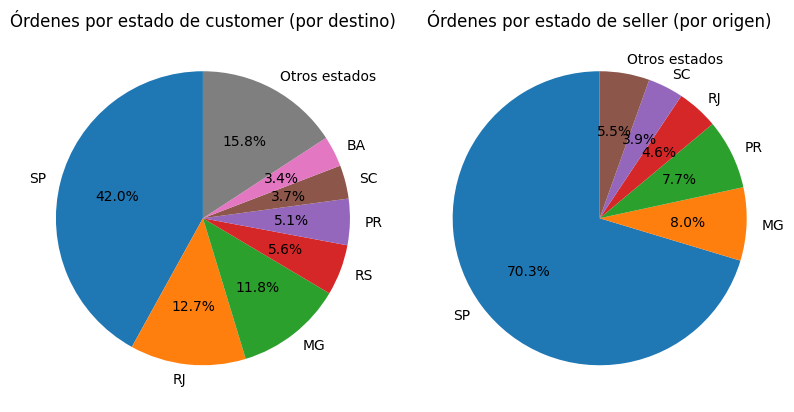

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

order_counts = dataset_final_agrupado['customer_state'].value_counts()
order_percent = order_counts / order_counts.sum()
mask_otros = order_percent < 0.03
order_counts_grouped = order_counts[~mask_otros].copy()
order_counts_grouped['Otros estados'] = order_counts[mask_otros].sum()
axes[0].pie(order_counts_grouped, labels=order_counts_grouped.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Órdenes por estado de customer (por destino)')

order_counts_seller = dataset_final_agrupado['seller_state'].value_counts()
order_percent_seller = order_counts_seller / order_counts_seller.sum()
mask_otros_seller = order_percent_seller < 0.03
order_counts_seller_grouped = order_counts_seller[~mask_otros_seller].copy()
order_counts_seller_grouped['Otros estados'] = order_counts_seller[mask_otros_seller].sum()
axes[1].pie(order_counts_seller_grouped, labels=order_counts_seller_grouped.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Órdenes por estado de seller (por origen)')

plt.tight_layout()
plt.show()

Intentemos ver esta distribución en un mapa

In [81]:
from folium.plugins import MiniMap, MarkerCluster

Primero veamos las compras como una línea que une customer con seller. Como son demasiados puntos, tomaremos una pequeña muestra de 100 compras:

In [82]:
muestra = dataset_final_agrupado.sample(200,random_state=808)

In [83]:
sellers_y_customers = muestra[['customer_unique_id','customer_lat','customer_lng','seller_id','seller_lat','seller_lng','freight_value']]

In [84]:
latitud_customers = sellers_y_customers.iloc[:,[2]].values
latitud_customers.astype(list);

longitud_customers = sellers_y_customers.iloc[:,[3]].values
longitud_customers.astype(list);

latitud_sellers = sellers_y_customers.iloc[:,[5]].values
latitud_sellers.astype(list);

longitud_sellers = sellers_y_customers.iloc[:,[6]].values
longitud_sellers.astype(list);


In [85]:
# BRASIL = folium.Map(location=[-11.5,-51.5], zoom_start=4)
# marker_cluster = MarkerCluster().add_to(BRASIL)

# for _, row in sellers_y_customers.iterrows():
#     folium.CircleMarker([row['seller_lat'], row['seller_lng']],
#                         radius=3,
#                         color="blue",
#                         stroke=False,
#                         fill=True,
#                         fill_opacity=0.6,
#                        ).add_to(BRASIL)
#     folium.CircleMarker([row['customer_lat'], row['customer_lng']],
#                         radius=3,
#                         color="green",
#                         stroke=False,
#                         fill=True,
#                         fill_opacity=0.6,
#                        ).add_to(BRASIL)
#     folium.PolyLine([[row['seller_lat'], row['seller_lng']],
#                      [row['customer_lat'], row['customer_lng']]],
#                     color='red',
#                     opacity = 0.6,
#                     weight=1).add_to(BRASIL)

# BRASIL

CAPTURA DE PANTALLA:

![alt text](Brasil_rutas.png)

Vamos a mostrar en un mapa la localización de los customers y en otro la de los sellers:

In [86]:
# BRASIL_customers = folium.Map(location=[-11.5,-51.5], zoom_start=4)
# marker_cluster = MarkerCluster().add_to(BRASIL_customers)

# for _, row in dataset_final_agrupado.iterrows():
#     coords = (row['customer_lat'], row['customer_lng'])
#     popup = folium.Popup(f"""
#         <b>ID:</b> {row['customer_unique_id']}<br>
#         <b>Ciudad:</b> {row.get('customer_city', 'N/D')}<br>
#         <b>Estado:</b> {row.get('customer_state', 'N/D')}
#     """, max_width=250)
#     folium.Marker(location=coords, popup=popup).add_to(marker_cluster)
# BRASIL_customers

CAPTURA DE PANTALLA:

![alt text](Brasil_customers.png)

In [87]:
# BRASIL_sellers = folium.Map(location=[-11.5,-51.5], zoom_start=4)
# marker_cluster = MarkerCluster().add_to(BRASIL_sellers)

# for _, row in dataset_final_agrupado.iterrows():
#     coords = (row['seller_lat'], row['seller_lng'])
#     popup = folium.Popup(f"""
#         <b>ID:</b> {row['seller_id']}<br>
#         <b>Ciudad:</b> {row.get('seller_city', 'N/D')}<br>
#         <b>Estado:</b> {row.get('seller_state', 'N/D')}
#     """, max_width=250)
#     folium.Marker(location=coords, popup=popup).add_to(marker_cluster)
# BRASIL_sellers

CAPTURA DE PANTALLA:

![alt text](Brasil_sellers.png)

Vemos en este último mapa que hay un seller cuya ciudad es "Porto Velho" pero algún error en el cálculo de coordenadas se lo posicionó más al sur (dentro de Bolivia).

No sabemos qué sucedió, pero hay otros 5 sellers en Porto Velho que sí están correctamente localizados.

Veamos las transacciones en cuestion:

In [89]:
dataset_final_agrupado.loc[(dataset_final_agrupado['seller_city']=='porto velho'),['seller_id','seller_lat','seller_lng']]

seller_id  seller_lat  seller_lng
7039   3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
32369  3364a91ec4d56c98e44174de954b94f6  -21.124489   -63.89326
36687  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
50866  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
54772  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
81559  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326

Vemos que es siempre el mismo seller!

Entonces claramente es un error de tipeo en el cálculo de la latitud.

Corregimos la celda correspondiente, con el cuidado de recalcular las distancias seller-customer luego de la modificación.

In [90]:
dataset_final_agrupado.loc[32369,'seller_lat'] = dataset_final_agrupado.loc[36687,'seller_lat']

In [91]:
dataset_final_agrupado.loc[(dataset_final_agrupado['seller_city']=='porto velho'),['seller_id','seller_lat','seller_lng']]

seller_id  seller_lat  seller_lng
7039   3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
32369  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
36687  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
50866  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
54772  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326
81559  3364a91ec4d56c98e44174de954b94f6   -8.765999   -63.89326

In [92]:
dataset_final_agrupado['distance_km'] = dataset_final_agrupado.apply(lambda row: geodesic((row['customer_lat'], row['customer_lng']), (row['seller_lat'], row['seller_lng'])).km, axis=1)

---

### Precio, flete, valor total

Vamos a graficar `price`, `freight_value` y `total_value`, las tres en escala logarítmica, frente a otras cantidades:

In [94]:
# Variables to plot
variables = ["price", "freight_value", "total_value"]

C:\Users\Ale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


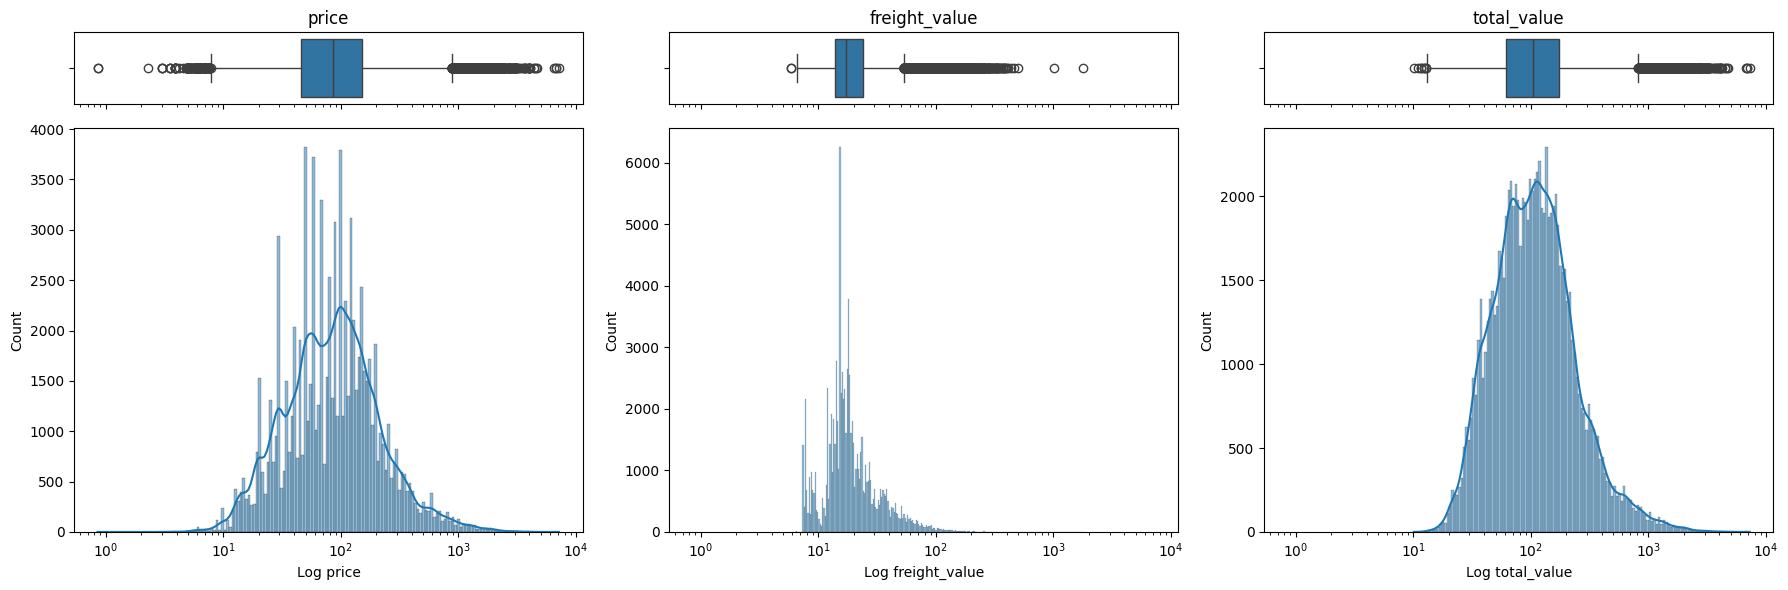

In [96]:
fig, axes = plt.subplots(
    2, 3, sharex=True, figsize=(18, 6),
    gridspec_kw={"height_ratios": (.15, .85)})

for i, var in enumerate(variables):
    ax_box = axes[0, i]   # boxplot row
    ax_hist = axes[1, i]  # histogram row
    sns.boxplot(dataset_final_agrupado[var],orient="h",ax=ax_box,log_scale=True)
    sns.histplot(data=dataset_final_agrupado,x=var,ax=ax_hist,kde=True,log_scale=True)
    ax_box.set(xlabel='')
    ax_hist.set_xlabel(f'Log {var}')
    ax_box.set_title(var)
plt.tight_layout()
plt.show()

Hay dos envíos con flete mayor a 1000 reales:

In [98]:
dataset_final_agrupado[[
    'price','freight_value','total_value','days_estimated','days_to_delivered',
    'days_difference_delivery','distance_km','product_chosen_weight','product_category_name'
    ]].sort_values(by='freight_value',ascending=False).head(5)

price  freight_value  total_value  days_estimated  days_to_delivered  \
77125  1050.0        1794.96      2844.96              29                 13   
13469   419.4        1002.29      1421.69              21                 10   
8682    840.0         502.98      1342.98              26                 14   
73329  1161.0         458.73      1619.73              22                  8   
49599  1767.8         436.24      2204.04              27                 18   

       days_difference_delivery  distance_km  product_chosen_weight  \
77125                        15  2127.236047           22680.000000   
13469                        11   378.993957           42000.000000   
8682                         11  1448.853728           11812.500000   
73329                        13   670.472589            9333.333333   
49599                         9  1763.334754           30000.000000   

        product_category_name  
77125  signaling_and_security  
13469         furniture_decor  
8682          furniture_decor  
73329              housewares  
49599          sports_leisure

Ambos envíos con precio de flete alto tienen un precio de producto menor. El de flete más caro recorre una distancia larga de 2000 km, entonces tiene sentido, pero el otro son 380 km.
Quizás son objetos muy particulares, por ejemplo son pesados (22,7 y 42 kg).

Veamos más adelante qué hacer con ellos.

¿Hay alguna dependencia con la distancia de envío?

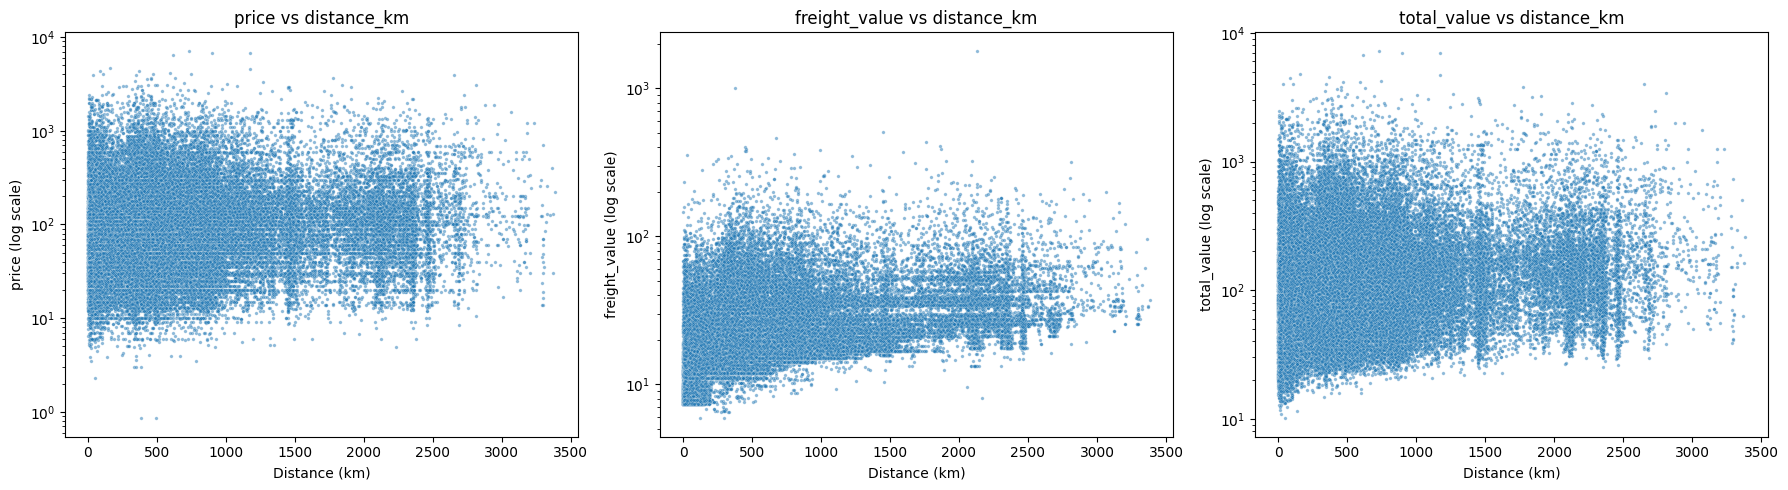

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(variables):
    ax = axes[i]
    sns.scatterplot(data=dataset_final_agrupado,x="distance_km",y=var,ax=ax,alpha=0.5,s=6)
    ax.set_yscale("log")
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel(f"{var} (log scale)")
    ax.set_title(f"{var} vs distance_km")
plt.tight_layout()
plt.show()

Podemos ver que el precio de flete tiene una relación positiva con la distancia en kilómetros. El valor total es la suma de precio+flete, asi que también captura algo de esa relación.

¿Y cómo se relacionan con el adelanto/atraso en la entrega?

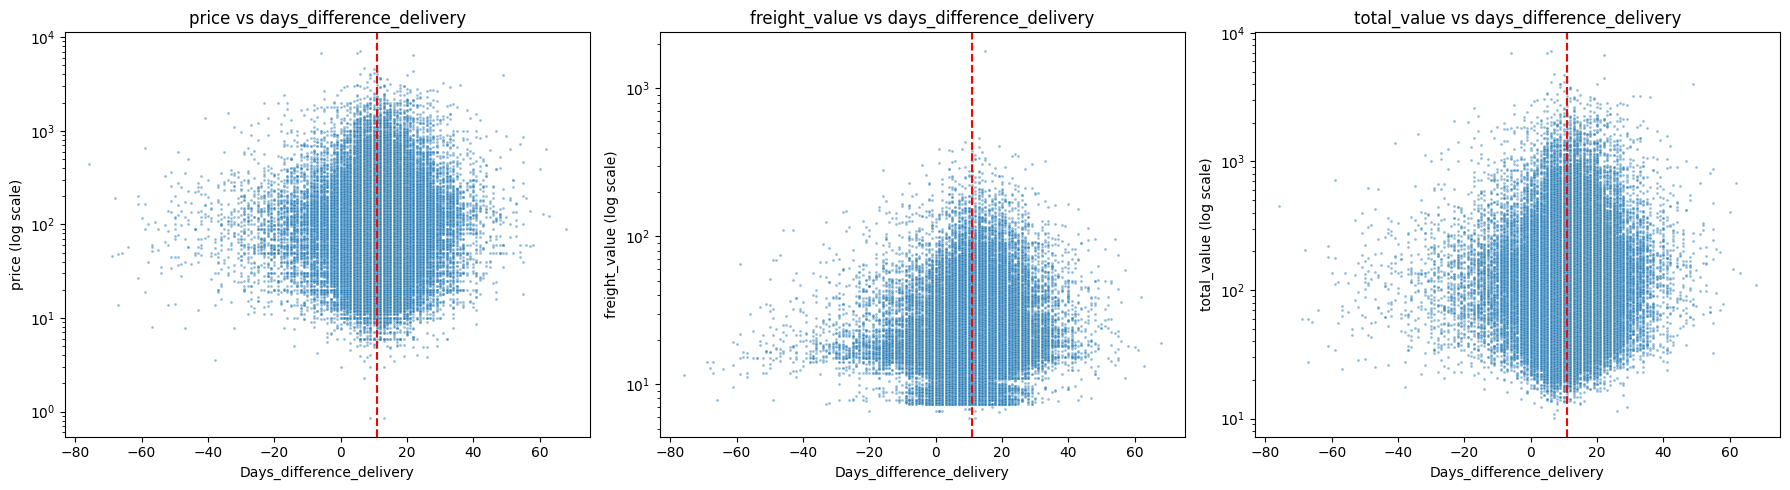

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(variables):
    ax = axes[i]
    sns.scatterplot(data=dataset_final_agrupado,x="days_difference_delivery",y=var,ax=ax,alpha=0.5,s=4)
    ax.axvline(x=11, color='red', linestyle='--')
    ax.set_yscale("log")
    ax.set_xlabel("Days_difference_delivery")
    ax.set_ylabel(f"{var} (log scale)")
    ax.set_title(f"{var} vs days_difference_delivery")
plt.tight_layout()
plt.show()

De estas gráficas podemos decir algo sobre la amplitud del rango que mide los días de adelanto/atraso respecto de la fecha estimada.

Por ejemplo, los valores de fletes más altos, arriba de 100 Reales, son pedidos cuyo adelanto en la entrega no varía mucho respecto de la media de ~11 días (línea roja a trazos). Valores de flete menores tienen un rango de variación más amplio, teniendo además mayores casos donde el envío llega atrasado. Pero también, valores de flete más bajos (10 Reales y menos) vuelven a tener una distribución alrededor de la media con variación más baja.

Entonces el precio de flete es una cantidad relevante para la estimación de los días de entrega.

Algo similar podemos ver respecto del precio de los productos:

- Precio muy pequeños ($< 10$ Reales) o muy grandes ($>1000$ Reales) no tienen mucha variación respecto de los días promedio de adelanto. Toda la variación respecto de la media parece estar en los productos cuyo precio está en el rango $[10,1000]$.

Veamos entonces estas cantidades frente a `days_to_delivered`, la variable que queremos predecir:

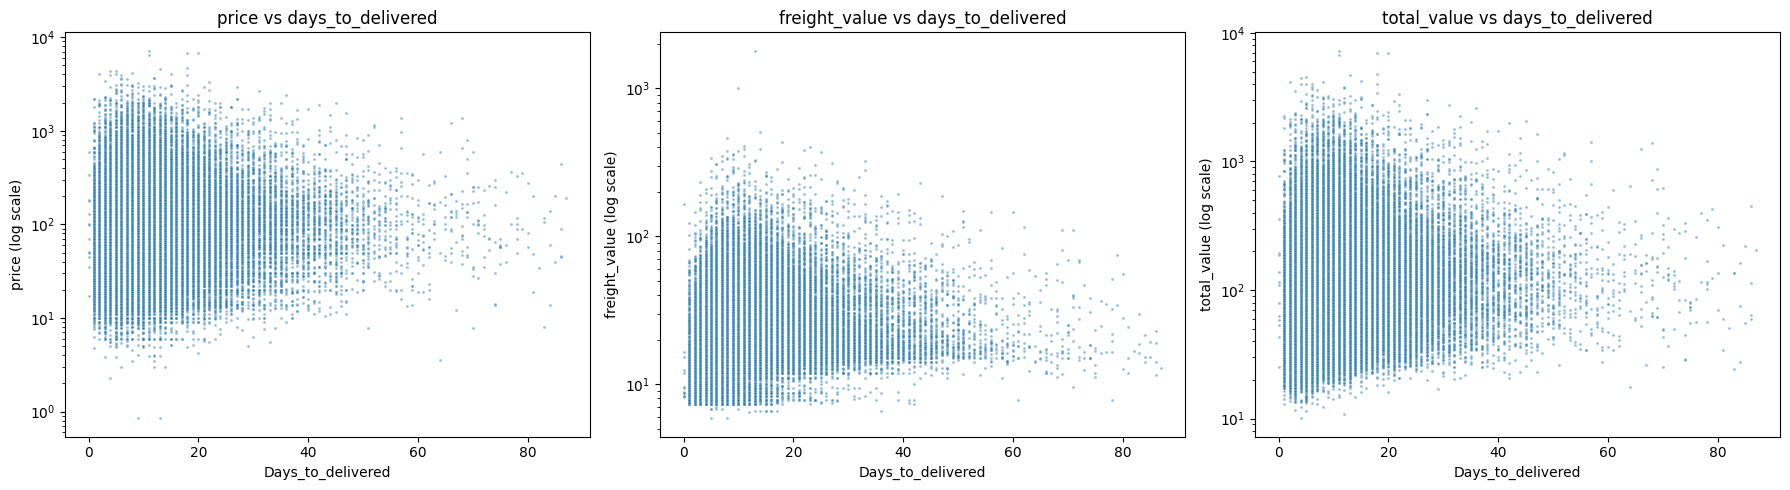

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, var in enumerate(variables):
    ax = axes[i]
    sns.scatterplot(data=dataset_final_agrupado,x="days_to_delivered",y=var,ax=ax,alpha=0.5,s=4)
    ax.set_yscale("log")
    ax.set_xlabel("Days_to_delivered")
    ax.set_ylabel(f"{var} (log scale)")
    ax.set_title(f"{var} vs days_to_delivered")
plt.tight_layout()
plt.show()

En todo el rango de precios y valores de flete tenemos pedidos que llegan en pocos días (20 o menos?).

Los que tardan más días en llegar parecen pertencer a un rango más acotado tanto de precio de producto como valor de flete.

Concluimos que debemos uncluir la variable `freight_value` en nuestro modelo, asi como probar incluyendo también `price`.

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Surge la pregunta si el costo de envío está relacionado con el precio del producto, asi como el supuesto de que los envíos tienen un costo fijo. También dicha relación podría haber cambiado a lo largo de los 2 años de datos.

Podemos entonces graficar el valor medio mes a mes de costo de envío por rango de precio del producto:

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\3290864499.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  envio_por_precio = df_envios.groupby(['order_purchase_year_month', 'price_range'])['freight_value'].mean().reset_index()


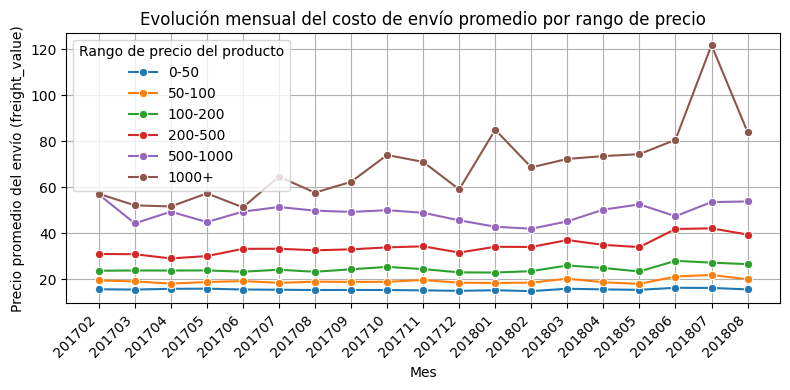

In [103]:
bins_precio = [0, 50, 100, 200, 500, 1000, float('inf')]
labels_precio = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']
df_envios = dataset_final_agrupado[['price', 'freight_value', 'order_purchase_year_month']]
df_envios['price_range'] = pd.cut(df_envios['price'], bins=bins_precio, labels=labels_precio)

envio_por_precio = df_envios.groupby(['order_purchase_year_month', 'price_range'])['freight_value'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(data=envio_por_precio, x='order_purchase_year_month', y='freight_value', hue='price_range', marker='o')
plt.title('Evolución mensual del costo de envío promedio por rango de precio')
plt.xlabel('Mes')
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Precio promedio del envío (freight_value)')
plt.legend(title='Rango de precio del producto')
plt.grid(True)
plt.tight_layout()
plt.show()

No parece haber grandes cambios en los valores promedio de flete en el tiempo, salvo el rango de productos más caros que parece haberse incrementado un poco.

También se nota que al incrementarse el precio del producto se incrementa el valor promedio de flete. Esto último tiene sentido, ya que productos más grandes y/o pesados tendrán un mayor precio de flete.

Veamos un gráfico de dispersión:

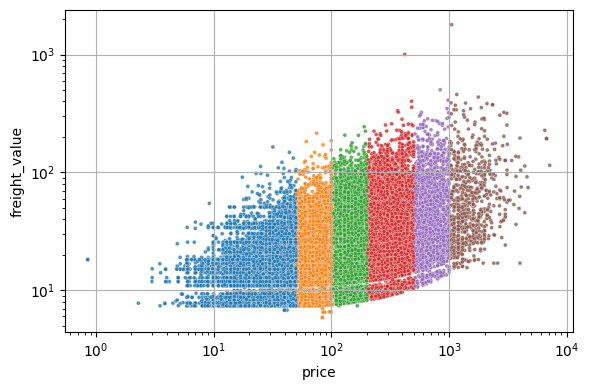

In [104]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_envios, x='price', y='freight_value', hue='price_range', alpha=0.8,s=8,legend=False)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

Veamos que la relación es que a mayor precio del producto el rango de valores de fletes se ensancha y aumenta su valor medio.

De todas maneras, `price`, `freight_value` y `total_value` las usaremos como variables reales, no las agruparemos.

En esta última gráfica notamos la existencia de varios outliers alejados del cúmulo principal:

- 2 puntos con `freight_value` más alto
- Dos puntos (solapados) con `price` menor a 1 y `freight_value` aproximadamente 20.
- 4 puntos con mayor `price` (parece ser mayor a $ 5000) y `freight_value` entre 100 y 200.

Vamos a eliminarlos:

In [116]:
dataset_final_agrupado[['price','freight_value']].sort_values(by='freight_value',ascending=False).head(3)

price  freight_value
77125  1050.0        1794.96
13469   419.4        1002.29
8682    840.0         502.98

In [109]:
dataset_final_agrupado[['price','freight_value']].sort_values(by='price',ascending=False).head(6)

price  freight_value
42896  7160.0         114.88
3024   6735.0         194.31
94827  6729.0         193.21
91110  6499.0         227.66
9524   4690.0          74.34
52446  4590.0          91.78

In [108]:
dataset_final_agrupado[['price','freight_value']].sort_values(by='price',ascending=True).head(3)

price  freight_value
41062   0.85          18.23
23324   0.85          18.23
86605   2.29           7.78

In [119]:
indices_eliminar = [77125, 13469,
                    42896, 3024, 94827, 91110,
                    41062,23324]
dataset_final_agrupado.drop(indices_eliminar, inplace=True)

Chequeamos:

In [120]:
dataset_final_agrupado[['price','freight_value']].sort_values(by='freight_value',ascending=False).head(3), dataset_final_agrupado[['price','freight_value']].sort_values(by='price',ascending=False).head(6), dataset_final_agrupado[['price','freight_value']].sort_values(by='price',ascending=True).head(3)


(        price  freight_value
 8682    840.0         502.98
 73329  1161.0         458.73
 49599  1767.8         436.24,
          price  freight_value
 9524   4690.00          74.34
 52446  4590.00          91.78
 78578  4400.00          45.50
 24632  4399.87         113.45
 38691  4099.99          75.27
 66129  4059.00         104.51,
        price  freight_value
 86605   2.29           7.78
 82689   2.99          11.85
 92849   3.00          15.23)

---

### Categorías por productos

In [121]:
print("Categorías únicas:", dataset_final_agrupado['product_category_name'].nunique())

Categorías únicas: 73


Si queremos explorar como afecta el tipo/categoría de producto a la demora del envío debemos explorar la incorporación de la variable `product_category_name` en el modelo de predicción.

Pero esta variable categórica tiene 73 categorías distintas, lo cual nos agregaría 72 variables binarias al hacer "dummy encoding". Esto es mucho, corremos riesgo de overfitting y además sería difícil darnos cuenta por qué tenemos overfitting.

Por eso vamos a agrupar `product_category_name` en menos cantidad de segmentos.

&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;
&#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688; &#9688;

Exploremos la relación de la categoría de producto con el volumen vendido y los días de entrega:

In [122]:
# Agrupamos por 'product_category_name'
# medimos volumen de ventas, 'days_to_delivered' y 'days_difference_delivery'
df = dataset_final_agrupado.groupby('product_category_name',observed=True).agg(
    avg_days=('days_to_delivered', 'mean'),
    total_productos=('product_id', 'count'),
    avg_days_diff=('days_difference_delivery', 'mean')
).sort_values(by='total_productos', ascending=False).reset_index()
# me quedo con los que tengan total_productos mayor a 500
df = df.loc[df['total_productos'] > 500]

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\1662419947.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


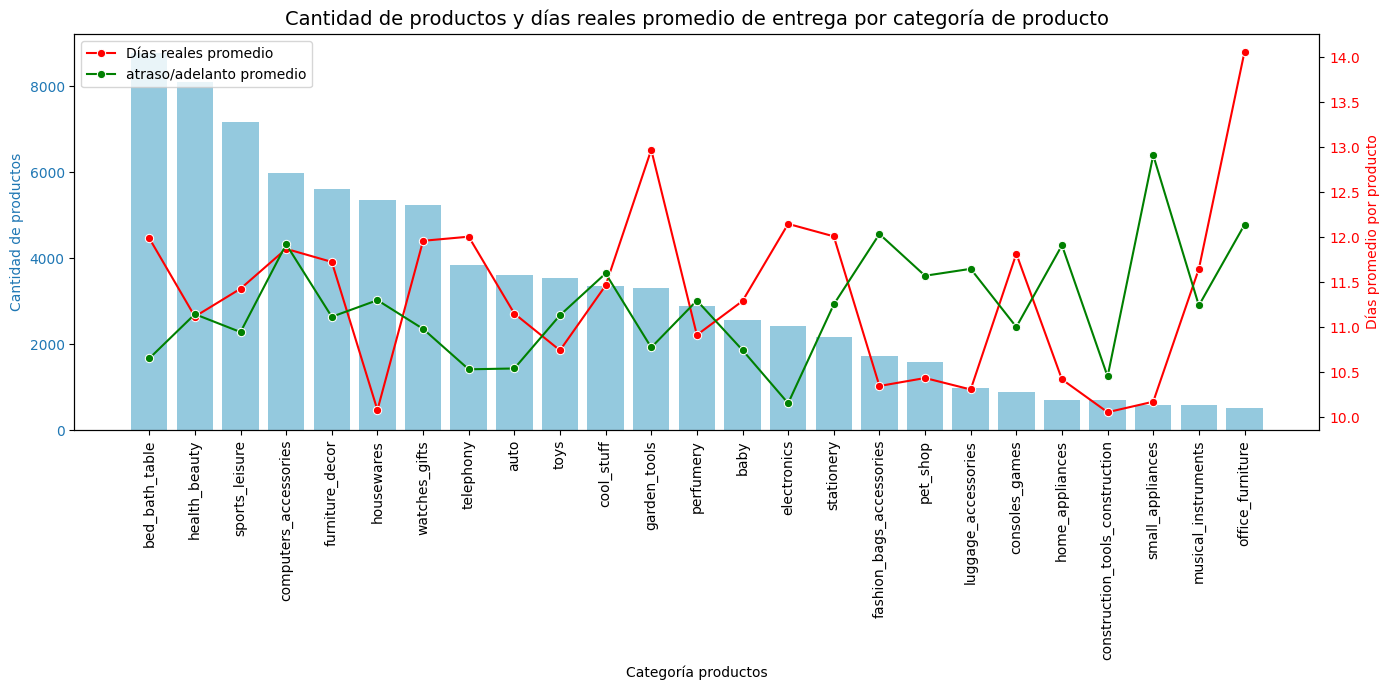

In [123]:
fig, ax1 = plt.subplots(figsize=(14, 7))
order = df.sort_values("total_productos", ascending=False)["product_category_name"]

sns.barplot(data=df, x='product_category_name', y='total_productos', ax=ax1, color='skyblue',order=order)
ax1.set_ylabel('Cantidad de productos', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Categoría productos')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

ax2 = ax1.twinx()
sns.lineplot(data=df, x='product_category_name', y='avg_days', ax=ax2, color='red', marker='o',label='Días reales promedio')
sns.lineplot(data=df, x='product_category_name', y='avg_days_diff', ax=ax2, color='green', marker='o',label='atraso/adelanto promedio')
ax2.set_ylabel('Días promedio por producto', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Cantidad de productos y días reales promedio de entrega por categoría de producto', fontsize=14)
fig.tight_layout(); plt.show()

La línea roja mide el promedio por categoría de los dias reales de envío. La línea verde da cuenta de los días antes/después que el producto llegó respecto de la estimación inicial.

Ninguna de estas categorías parece alejarse mucho de los valores promedios para ambas cantidades de tiempo. Por lo tanto no podemos usar el "historial" de tiempos de envíos por categoría para agruparlas.

Tampoco el volumen de ventas parece ser muy determinante.

Por eso agruparemos en 8 grandes rubros:

In [124]:
# Diccionario de mapeo de categorías a rubros
rubro_map = {
    # Artículos del hogar
    'bed_bath_table': 'articulos_del_hogar',
    'garden_tools': 'articulos_del_hogar',
    'housewares': 'articulos_del_hogar',
    'home_confort': 'articulos_del_hogar',
    'home_confort_2': 'articulos_del_hogar',
    'flowers': 'articulos_del_hogar',
    'furniture_bedroom': 'articulos_del_hogar',
    'furniture_decor': 'articulos_del_hogar',
    'furniture_living_room': 'articulos_del_hogar',
    'furniture_mattress_and_upholstery': 'articulos_del_hogar',
    'kitchen_dining_laundry_garden_furniture': 'articulos_del_hogar',
    'pet_shop': 'articulos_del_hogar',
    'portable_kitchen_and_food_preparation': 'articulos_del_hogar',
    'christmas_supplies': 'articulos_del_hogar',


    # Electrodomésticos
    'air_conditioning': 'electrodomesticos',
    'audio': 'electrodomesticos',
    'home_appliances': 'electrodomesticos',
    'home_appliances_2': 'electrodomesticos',
    'small_appliances': 'electrodomesticos',
    'small_appliances_home_oven_and_coffee': 'electrodomesticos',

    # Ropa y accesorios
    'fashio_female_clothing': 'ropa_y_accesorios',
    'fashion_bags_accessories': 'ropa_y_accesorios',
    'fashion_childrens_clothes': 'ropa_y_accesorios',
    'fashion_male_clothing': 'ropa_y_accesorios',
    'fashion_shoes': 'ropa_y_accesorios',
    'fashion_sport': 'ropa_y_accesorios',
    'fashion_underwear_beach': 'ropa_y_accesorios',

    # Tecnología
    'computers': 'tecnologia',
    'computers_accessories': 'tecnologia',
    'electronics': 'tecnologia',
    'fixed_telephony': 'tecnologia',
    'tablets_printing_image': 'tecnologia',
    'telephony': 'tecnologia',
    'pc_gamer': 'tecnologia',

    # Deportes y ocio
    'books_general_interest': 'deportes_y_ocio',
    'books_imported': 'deportes_y_ocio',
    'cds_dvds_musicals': 'deportes_y_ocio',
    'console_games': 'deportes_y_ocio',
    'dvds_blu_ray': 'deportes_y_ocio',
    'sports_leisure': 'deportes_y_ocio',
    'toys': 'deportes_y_ocio',

    # Salud y belleza
    'baby': 'salud_y_belleza',
    'diapers_and_hygiene': 'salud_y_belleza',
    'health_beauty': 'salud_y_belleza',
    'perfumery': 'salud_y_belleza',

    # Alimentos y bebidas
    'drinks': 'alimentos_y_ bebidas',
    'food': 'alimentos_y_ bebidas',
    'food_drink': 'alimentos_y_ bebidas',
}

# Crear nueva columna con el rubro
dataset_final_agrupado['product_rubro'] = dataset_final_agrupado['product_category_name'].map(rubro_map).fillna('otros')

In [125]:
# Revisar distribución de los nuevos rubros
print(dataset_final_agrupado['product_rubro'].value_counts())

product_rubro
articulos_del_hogar     25806
otros                   21636
salud_y_belleza         13579
tecnologia              12665
deportes_y_ocio         11272
ropa_y_accesorios        2174
electrodomesticos        2108
alimentos_y_ bebidas      897
Name: count, dtype: int64


En el siguiente grafico se pretende observar si existen grandes desvios de días entre lo estimado y real por categoría de producto.
Sirve para analizar si cierto tipos de productos que requieren un tiempo de trabajo previo al despacho se ven reflejados en los tiempos de desvios.

C:\Users\Ale\AppData\Local\Temp\ipykernel_17984\1157476216.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diferencia_por_categoria.values, y=diferencia_por_categoria.index, palette='viridis')


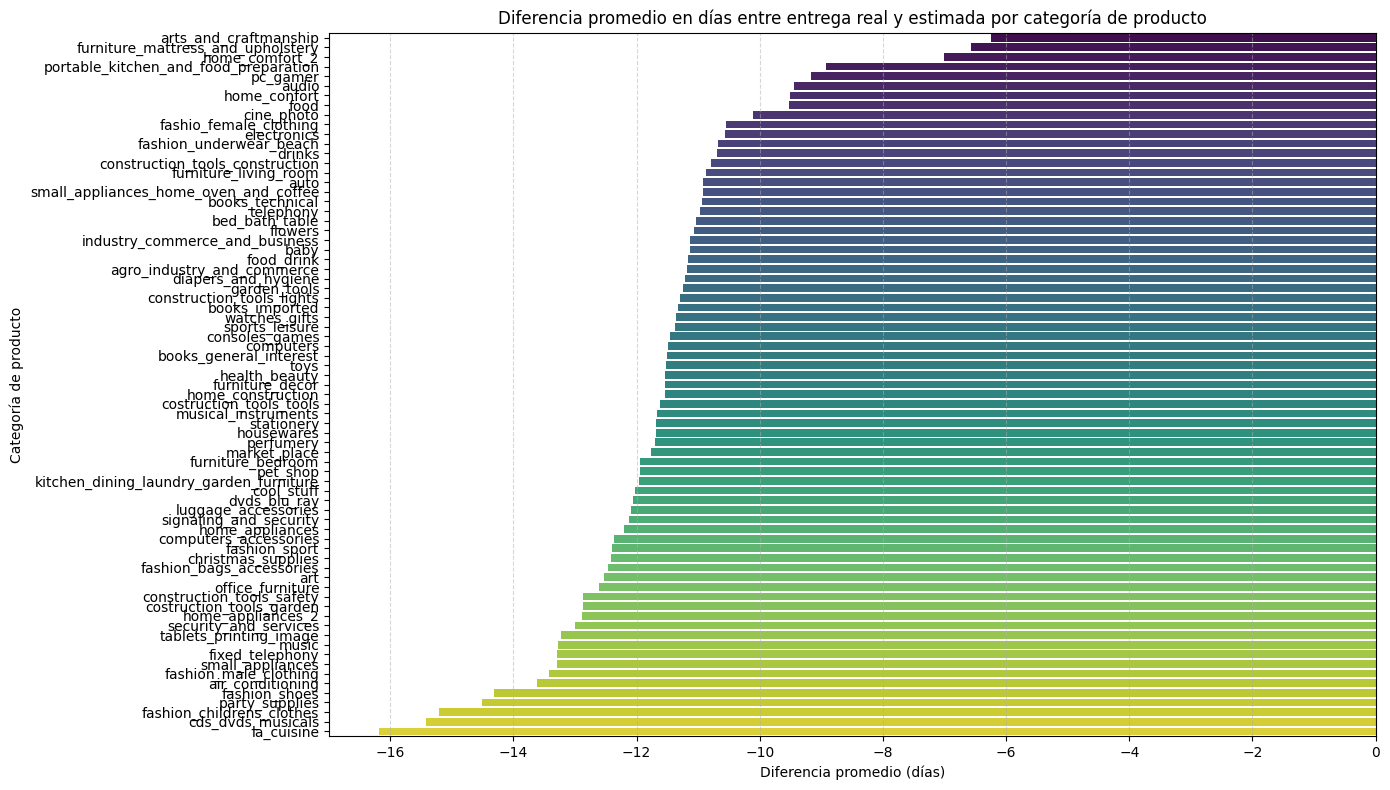

In [126]:
# @title
# Asegurar formato datetime en las columnas de fechas necesarias
fechas = [
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_delivered_carrier_date'
]
dataset_final_agrupado[fechas] = dataset_final_agrupado[fechas].apply(pd.to_datetime)

# Filtrar filas sin valores nulos en fechas y categoría de producto
df_productos = dataset_final_agrupado.dropna(subset=fechas + ['product_category_name']).copy()

# Calcular días estimados y reales
df_productos['estimated_days'] = (df_productos['order_estimated_delivery_date'] - df_productos['order_delivered_carrier_date']).dt.days
df_productos['actual_days'] = (df_productos['order_delivered_customer_date'] - df_productos['order_delivered_carrier_date']).dt.days

# Calcular diferencia
df_productos['difference_days'] = df_productos['actual_days'] - df_productos['estimated_days']

# Agrupar por categoría de producto y calcular diferencia promedio
diferencia_por_categoria = df_productos.groupby('product_category_name')['difference_days'].mean().sort_values(ascending=False)

# Graficar
plt.figure(figsize=(14, 8))
sns.barplot(x=diferencia_por_categoria.values, y=diferencia_por_categoria.index, palette='viridis')
plt.title('Diferencia promedio en días entre entrega real y estimada por categoría de producto')
plt.xlabel('Diferencia promedio (días)')
plt.ylabel('Categoría de producto')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Cada categoría tiene en promedio entrega "adelantada", es decir que en promedio llegan antes que la fecha estimada previamente.

---

### Categoría por volumen

Podría también ser util agrupar cada categoría según su volumen de venta:

In [129]:
volumen_categoría = dataset_final_agrupado['product_category_name'].value_counts()
volumen_categoría.head(20)

product_category_name
bed_bath_table              8775
health_beauty               8098
sports_leisure              7154
computers_accessories       5973
furniture_decor             5605
housewares                  5351
watches_gifts               5225
telephony                   3844
auto                        3608
toys                        3549
cool_stuff                  3356
garden_tools                3305
perfumery                   2891
baby                        2567
electronics                 2429
stationery                  2163
fashion_bags_accessories    1720
pet_shop                    1585
luggage_accessories          985
consoles_games               896
Name: count, dtype: int64

In [128]:
volumen_categoría.tail(54)

product_category_name
consoles_games                             896
home_appliances                            710
construction_tools_construction            701
small_appliances                           583
musical_instruments                        576
office_furniture                           518
books_general_interest                     458
food                                       412
home_construction                          390
furniture_living_room                      361
home_confort                               337
audio                                      332
drinks                                     273
books_technical                            248
market_place                               242
air_conditioning                           220
construction_tools_lights                  220
industry_commerce_and_business             220
kitchen_dining_laundry_garden_furniture    220
food_drink                                 212
fashion_shoes                         

Vamos a utilizar la siguiente agrupación de volumen:
- Alto: mayor a 5000 (son 7 categorías)
- Medio: entre 500 y 5000 (son 18 categorías)
- Bajo: menor a 500 (son 48 categorías)

In [130]:
dataset_final_agrupado['product_venta_count'] = dataset_final_agrupado['product_category_name'].map(volumen_categoría)

def classify_count(x):
    if x <= 500:
        return 'low'
    elif x <= 5000:
        return 'medium'
    else:
        return 'high'

dataset_final_agrupado['product_venta'] = dataset_final_agrupado['product_venta_count'].apply(classify_count)

In [131]:
dataset_final_agrupado.head(30)

order_purchase_timestamp   order_approved_at order_delivered_carrier_date  \
0       2017-09-13 08:59:02 2017-09-13 09:45:35          2017-09-19 18:34:16   
1       2017-04-26 10:53:06 2017-04-26 11:05:13          2017-05-04 14:35:00   
2       2018-01-14 14:33:31 2018-01-14 14:48:30          2018-01-16 12:36:48   
3       2018-08-08 10:00:35 2018-08-08 10:10:18          2018-08-10 13:28:00   
5       2017-05-15 21:42:34 2017-05-17 03:55:27          2017-05-17 11:05:55   
6       2017-12-10 11:53:48 2017-12-10 12:10:31          2017-12-12 01:07:48   
7       2018-07-04 12:08:27 2018-07-05 16:35:48          2018-07-05 12:15:00   
8       2018-03-19 18:40:33 2018-03-20 18:35:21          2018-03-28 00:37:42   
9       2018-07-02 13:59:39 2018-07-02 14:10:56          2018-07-03 14:25:00   
10      2018-03-24 22:16:10 2018-03-24 22:28:09          2018-03-27 05:26:55   
11      2018-07-27 17:21:27 2018-07-27 18:00:06          2018-07-30 14:52:00   
12      2018-07-24 17:04:17 2018-07-24 17:24:20          2018-07-25 11:02:00   
13      2018-02-13 22:10:21 2018-02-15 03:55:52          2018-02-20 18:23:28   
14      2018-08-14 20:43:09 2018-08-15 12:15:10          2018-08-15 15:28:00   
15      2018-04-25 09:10:41 2018-04-25 09:33:19          2018-04-27 15:14:00   
16      2018-05-11 20:33:38 2018-05-11 20:57:03          2018-05-16 14:26:00   
17      2017-08-12 10:08:57 2017-08-15 03:35:32          2017-08-15 15:32:51   
18      2018-02-22 11:54:42 2018-02-22 12:08:37          2018-02-26 14:18:32   
19      2018-03-23 19:48:26 2018-03-23 20:07:49          2018-03-26 21:38:48   
20      2017-11-21 18:54:23 2017-11-21 19:09:02          2017-11-22 20:46:54   
22      2018-02-27 09:27:14 2018-02-27 09:35:41          2018-02-27 21:43:46   
23      2017-09-11 17:39:33 2017-09-11 18:04:37          2017-09-12 17:02:57   
24      2017-08-06 00:42:49 2017-08-07 00:35:12          2017-08-07 21:12:34   
25      2018-01-16 21:43:23 2018-01-16 21:51:25          2018-01-23 22:08:06   
26      2017-03-23 12:21:17 2017-03-23 13:05:42          2017-03-27 08:58:04   
27      2018-06-11 21:17:00 2018-06-12 05:16:24          2018-06-12 14:22:00   
28      2017-12-05 23:40:59 2017-12-07 03:16:36          2017-12-07 22:59:30   
29      2017-11-24 16:50:38 2017-11-25 06:30:55          2017-11-28 19:43:52   
30      2018-04-07 18:51:22 2018-04-07 19:08:28          2018-04-09 23:29:32   
31      2017-10-16 15:29:43 2017-10-16 16:07:52          2017-10-16 23:04:43   

   order_delivered_customer_date order_estimated_delivery_date  \
0            2017-09-20 23:43:48                    2017-09-29   
1            2017-05-12 16:04:24                    2017-05-15   
2            2018-01-22 13:19:16                    2018-02-05   
3            2018-08-14 13:32:39                    2018-08-20   
5            2017-05-22 13:44:35                    2017-06-06   
6            2017-12-18 22:03:38                    2018-01-04   
7            2018-07-09 14:04:07                    2018-07-25   
8            2018-03-29 18:17:31                    2018-03-29   
9            2018-07-04 17:28:31                    2018-07-23   
10           2018-03-29 00:04:19                    2018-04-09   
11           2018-08-07 13:56:52                    2018-08-07   
12           2018-07-31 01:04:15                    2018-08-22   
13           2018-02-26 13:55:22                    2018-03-06   
14           2018-08-22 12:02:27                    2018-08-28   
15           2018-04-30 17:54:25                    2018-05-09   
16           2018-05-18 16:46:31                    2018-05-22   
17           2017-08-19 15:22:17                    2017-09-01   
18           2018-03-12 18:46:34                    2018-03-19   
19           2018-03-27 14:51:47                    2018-04-05   
20           2017-12-09 17:27:23                    2017-12-07   
22           2018-03-08 20:06:33                    2018-03-23   
23           2017-09-23 13:21:21                    2017-09-27   
24  

---

### Categorías por estados

In [132]:
top15 = dataset_final_agrupado.groupby(['seller_state', 'customer_state']).size().sort_values(ascending=False).head(15)
top15= top15.reset_index()

In [133]:
top15

seller_state customer_state      0
0            SP             SP  28498
1            SP             RJ   7481
2            SP             MG   6860
3            SP             RS   3367
4            SP             PR   2900
5            PR             SP   2736
6            MG             SP   2421
7            SP             SC   2167
8            SP             BA   2155
9            MG             MG   1468
10           SP             ES   1370
11           SP             GO   1325
12           SC             SP   1309
13           RJ             SP   1294
14           SP             DF   1291

Se realiza el siguiente grafico resumiendo las 10 principales rutas ordenadas por cantidad de ordenes:

In [ ]:
top10 = dataset_final_agrupado.groupby(['seller_state', 'customer_state']).agg({
    'product_id': 'count',
    'days_estimated': 'mean',
    'days_to_delivered': 'mean'
}).sort_values(by='product_id', ascending=False).head(10)

top10.reset_index(inplace=True)

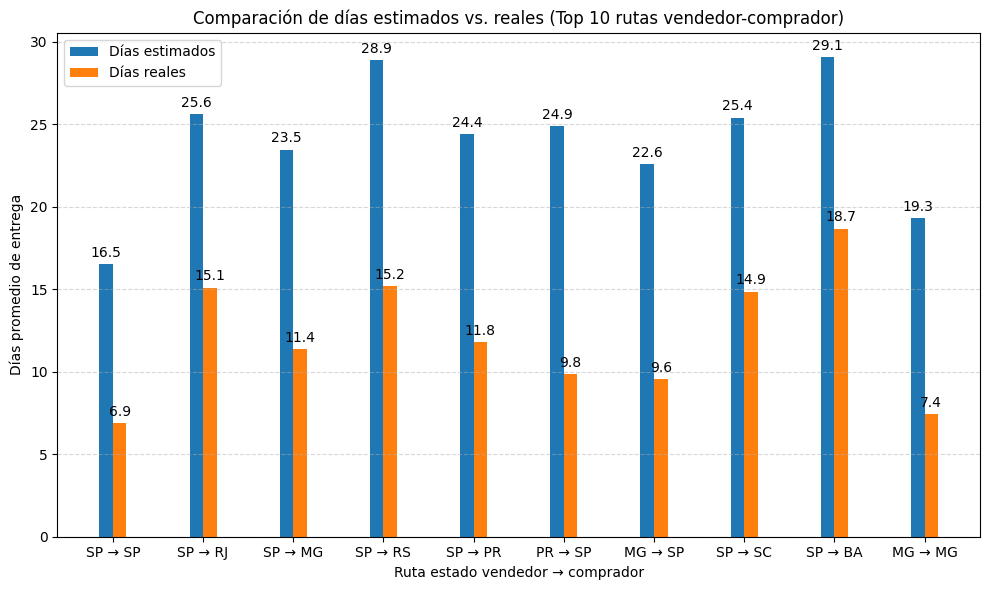

In [135]:
# Crear etiquetas tipo "SP → SP"
top10['ruta'] = top10['seller_state'] + ' → ' + top10['customer_state']

# Paso 2: Crear el gráfico de barras
x = np.arange(len(top10))  # posiciones
width = 0.15  # ancho de barra

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, top10['days_estimated'], width, label='Días estimados')
bars2 = ax.bar(x + width/2, top10['days_to_delivered'], width, label='Días reales')

# Etiquetas y formato
ax.set_title('Comparación de días estimados vs. reales (Top 10 rutas vendedor-comprador)')
ax.set_xlabel('Ruta estado vendedor → comprador')
ax.set_ylabel('Días promedio de entrega')
ax.set_xticks(x)
ax.set_xticklabels(top10['ruta'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar valores sobre las barras
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [136]:
print("Estados únicos por vendedor:", dataset_final_agrupado['seller_state'].nunique())
print("Estados únicos por comprador:", dataset_final_agrupado['customer_state'].nunique())

print("Ciudades únicas por vendedor:", dataset_final_agrupado['seller_city'].nunique())
print("Ciudades únicas por comprador:", dataset_final_agrupado['customer_city'].nunique())

Estados únicos por vendedor: 21
Estados únicos por comprador: 27
Ciudades únicas por vendedor: 537
Ciudades únicas por comprador: 4003


Similarmente a `product_category_name`, vemos que hay una gran variedad de estados y ciudades, tanto para vendedores como compradores.

Lo que vamos a hacer es agrupar las rutas entre estados quedándonos con las 10 primeras en cantidad de ventas.

In [137]:
# Diccionario con rutas específicas top 10
rutas_especificas = {
    ("SP", "SP"): "SP-SP",
    ("SP", "RJ"): "SP-RJ",
    ("SP", "MG"): "SP-MG",
    ("SP", "RS"): "SP-RS",
    ("SP", "PR"): "SP-PR",
    ("PR", "SP"): "PR-SP",
    ("MG", "SP"): "MG-SP",
    ("SP", "SC"): "SP-SC",
    ("SP", "BA"): "SP-BA",
    ("MG", "MG"): "MG-MG" }


In [138]:
# Crear columna RUTA
dataset_final_agrupado["rutas"] = [
    rutas_especificas.get((s, c), "otra_ruta")
    for s, c in zip(dataset_final_agrupado["seller_state"], dataset_final_agrupado["customer_state"])
]

In [139]:
dataset_final_agrupado['rutas'].value_counts()

rutas
otra_ruta    30084
SP-SP        28498
SP-RJ         7481
SP-MG         6860
SP-RS         3367
SP-PR         2900
PR-SP         2736
MG-SP         2421
SP-SC         2167
SP-BA         2155
MG-MG         1468
Name: count, dtype: int64

---

### Categoría intra Estado

Vamos a crear una variable dummy que sea 1 si vendedor y comprador son del mismo estado (provincia), y 0 si son diferentes.

In [140]:
dataset_final_agrupado['sales_same_state'] = (dataset_final_agrupado['seller_state'] == dataset_final_agrupado['customer_state']).astype(int)


---
### Guardado de data set final

In [141]:
dataset_final_agrupado_datatypes = dataset_final_agrupado.dtypes.astype(str).to_dict()
with open('./bbdd_limpia/dataset_final_agrupado_datatypes.txt', "w") as file:
    json.dump(dataset_final_agrupado_datatypes, file, indent=4)
dataset_final_agrupado.to_csv('./bbdd_limpia/dataset_final_agrupado.csv', index=False)